# Прогнозирование стоимости автомобиля на вторичном рынке

## План работы 

1. Загрузка и ознакомление с данными.
2. Подготовка данных.
3. Разведочный анализ.
4. Feature engineering & feature extraction.
5. Обучение моделей и формирование предсказаний.
6. Изучение важности признаков итоговой модели.
7. Добавление новых признаков.
8. Подготовка выводов по исследованию.


### 1. Знакомство с данными

In [243]:
#импортирую все нужные библиотеки и методы 
import pandas as pd
import ydata_profiling
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
import category_encoders as ce
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline


print('Импорты готовы!')

Импорты готовы!


In [181]:
#открываю датасеты

data_test = pd.read_csv('C:/Users/evdov/OneDrive/Рабочий стол/Практикум/Мастерская 1/auto_cost/test.csv')
data_train = pd.read_csv('C:/Users/evdov/OneDrive/Рабочий стол/Практикум/Мастерская 1/auto_cost/train.csv')
       
print('Данные загружены!')

Данные загружены!


In [182]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [183]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


In [184]:
#знакомлюсь с данными
profile = data_train.profile_report(title='Сar Report', progress_bar=False, explorative=False)

In [185]:
profile.to_widgets()

### По итогам анализа¶

В основном категориальные признаки - придется их кодировать. 

**Тип данных**

В столбце saledate надо поправить тип данных на datetime и потом посмотрю, чтобы не было неадекватных значений. 

**Выбросы**

В столбце sellingprice есть подозрительные минимальные значения, их отрежем. По столбцу odometer тоже есть подозрительно низкие значения, посмотрю на графике, возможно их подчищу тоже.  

**Пропуски**

Пропусков в данных 1.5%, все они в основном в столбце transmission. Заполняю так: выбираю все модели и смотрю, какой у них тип трансмиссии. Если тип трансмисси на модель только один, беру его для заполнения пропусков по этой модели. Остальные пропуски заполняю как "unknown". 

В столбцах make, model, trim и body заполняем пропуски как "unknown", потому что судя по матрице эти признаки как правило отсутсвуют в связке друг с другом. Поэтому сложно делать какие-то предложения по заполнению, значения могут быть любыми, и тем более пропусков очень мало. 

Пропуски по condition заменим на "unknown", потому что мы не знаем, как считали этот показатель. По этой логике заменим на "unknown" пропуски в столбцахх color и interior - цвет салона и кузова могут бть любыми. 

**Дубликаты**

В столбце body сразу видны дубликаты Sedan и sedan, посмотрю уникальные значения, чтобы привести все в одному виду. По той же логике проверю столбцы make и trim. 

### 2. Обработка данных

In [186]:
#меняем формат данных в saledate, чтобы удобнее было работать
data_train['saledate'] = data_train['saledate'].apply(lambda x: x.split(" GMT")[0])
data_train['saledate'] = pd.to_datetime(data_train['saledate'], format='%a %b %d %Y %H:%M:%S')

In [187]:
data_train['saledate'].head()

0   2015-06-02 02:30:00
1   2015-02-25 02:00:00
2   2015-06-10 02:30:00
3   2015-06-17 03:00:00
4   2015-02-03 04:00:00
Name: saledate, dtype: datetime64[ns]

Проверим данные на адекватность - отфильтруем те строки, ге год выпуска машины меньше года продажи. 

In [188]:
#добавляем столбец с годом продажи
data_train['year_sell'] = data_train['saledate'].dt.year
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          440236 non-null  int64         
 1   make          432193 non-null  object        
 2   model         432113 non-null  object        
 3   trim          431899 non-null  object        
 4   body          429843 non-null  object        
 5   transmission  388775 non-null  object        
 6   vin           440236 non-null  object        
 7   state         440236 non-null  object        
 8   condition     430831 non-null  float64       
 9   odometer      440167 non-null  float64       
 10  color         439650 non-null  object        
 11  interior      439650 non-null  object        
 12  seller        440236 non-null  object        
 13  sellingprice  440236 non-null  int64         
 14  saledate      440236 non-null  datetime64[ns]
 15  year_sell     440

In [189]:
#фильтруем
data_train = data_train[data_train['year'] < data_train['year_sell']]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428659 entries, 0 to 440235
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          428659 non-null  int64         
 1   make          420776 non-null  object        
 2   model         420734 non-null  object        
 3   trim          420482 non-null  object        
 4   body          418435 non-null  object        
 5   transmission  378533 non-null  object        
 6   vin           428659 non-null  object        
 7   state         428659 non-null  object        
 8   condition     419551 non-null  float64       
 9   odometer      428591 non-null  float64       
 10  color         428098 non-null  object        
 11  interior      428098 non-null  object        
 12  seller        428659 non-null  object        
 13  sellingprice  428659 non-null  int64         
 14  saledate      428659 non-null  datetime64[ns]
 15  year_sell     428

Отрезали 12 тыс строк, возможно заполненных с ошибкой. 

In [190]:
#все то же делаем на тестовой выборке, кроме отрезания по условию
data_test['saledate'] = data_test['saledate'].apply(lambda x: x.split(" GMT")[0])
data_test['saledate'] = pd.to_datetime(data_test['saledate'], format='%a %b %d %Y %H:%M:%S')
data_test['year_sell'] = data_test['saledate'].dt.year
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          110058 non-null  int64         
 1   make          107997 non-null  object        
 2   model         107979 non-null  object        
 3   trim          107944 non-null  object        
 4   body          107464 non-null  object        
 5   transmission  97047 non-null   object        
 6   vin           110058 non-null  object        
 7   state         110058 non-null  object        
 8   condition     107679 non-null  float64       
 9   odometer      110039 non-null  float64       
 10  color         109900 non-null  object        
 11  interior      109900 non-null  object        
 12  seller        110058 non-null  object        
 13  saledate      110058 non-null  datetime64[ns]
 14  year_sell     110058 non-null  int64         
dtypes: datetime64[ns]

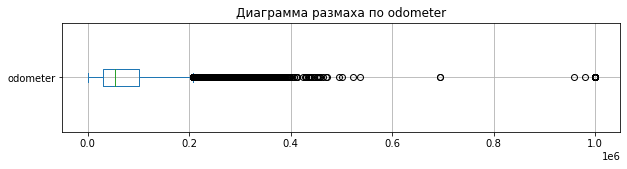

In [191]:
#смотрю выбросы по odometer
(
    data_train['odometer']
    .plot(kind='box', figsize=(10, 2), 
    grid=True, vert = False, title='Диаграмма размаха по odometer')

);

In [192]:
#отфильтровать аномалии
data_train = data_train[data_train['odometer'] < 500000]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428529 entries, 0 to 440235
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          428529 non-null  int64         
 1   make          420650 non-null  object        
 2   model         420608 non-null  object        
 3   trim          420359 non-null  object        
 4   body          418316 non-null  object        
 5   transmission  378433 non-null  object        
 6   vin           428529 non-null  object        
 7   state         428529 non-null  object        
 8   condition     419471 non-null  float64       
 9   odometer      428529 non-null  float64       
 10  color         427976 non-null  object        
 11  interior      427976 non-null  object        
 12  seller        428529 non-null  object        
 13  sellingprice  428529 non-null  int64         
 14  saledate      428529 non-null  datetime64[ns]
 15  year_sell     428

Отрезали еще около 100 строк с выбросами

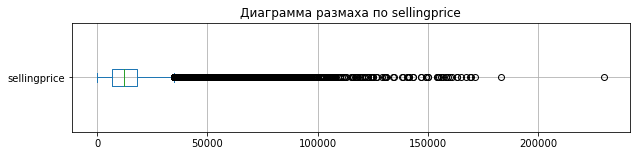

In [193]:
#смотрю выбросы по sellingprice
(
    data_train['sellingprice']
    .plot(kind='box', figsize=(10, 2), 
    grid=True, vert = False, title='Диаграмма размаха по sellingprice')

);

Кроме аномально высоких и редких значений, отсекаем машины, проданные дешевле 200 долларов, это не похоже на рыночную цену. Если нам нужна адекватная модель которая учитывает рынок, такие данные лучше удалить. 

In [194]:
#отфильтровать аномалии
data_train = data_train[(data_train['sellingprice'] < 170000) & (data_train['sellingprice'] > 200)]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428327 entries, 0 to 440235
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          428327 non-null  int64         
 1   make          420471 non-null  object        
 2   model         420429 non-null  object        
 3   trim          420181 non-null  object        
 4   body          418139 non-null  object        
 5   transmission  378262 non-null  object        
 6   vin           428327 non-null  object        
 7   state         428327 non-null  object        
 8   condition     419286 non-null  float64       
 9   odometer      428327 non-null  float64       
 10  color         427774 non-null  object        
 11  interior      427774 non-null  object        
 12  seller        428327 non-null  object        
 13  sellingprice  428327 non-null  int64         
 14  saledate      428327 non-null  datetime64[ns]
 15  year_sell     428

In [195]:
#проверка выбросов
data_train.describe()

,year,condition,odometer,sellingprice,year_sell
count,428327.000000,419286.000000,428327.000000,428327.000000,428327.000000
mean,2009.922466,3.406855,69635.189685,13319.866700,2014.910008
std,3.948432,0.942378,52308.175239,9465.953623,0.286171
min,1982.000000,1.000000,1.000000,225.000000,2014.000000
25%,2007.000000,2.700000,29699.000000,6700.000000,2015.000000
50%,2012.000000,3.600000,53706.000000,12000.000000,2015.000000
75%,2013.000000,4.200000,100622.000000,17900.000000,2015.000000
max,2014.000000,5.000000,495757.000000,169500.000000,2015.000000


<div class="alert alert-info">
    написала код по той логике, что описала выше, но пропуски не заполняет. если подскажете, в чем его проблем, буду благодарна. возможно конечно что пропуски есть тоько по тем моделм, у которых нет уникального варианта трансмиссии на модель. но верится с трудом))
</div>

In [196]:
#заполняю пропуски в transmission
#делаю список моделей, для которых transmission имеет только одно значение
grouped_transmission = data_train.groupby('model')['transmission'].nunique()
single_transmission = grouped_transmission[grouped_transmission == 1].index.tolist()

#заполняю пропуски
for x in single_transmission:
    transmission_value = data_train.loc[data_train['model'] == x, 'transmission'].dropna().unique()[0]
    data_train.loc[data_train['model'] == x, 'transmission'].fillna(transmission_value, inplace=True)

data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428327 entries, 0 to 440235
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          428327 non-null  int64         
 1   make          420471 non-null  object        
 2   model         420429 non-null  object        
 3   trim          420181 non-null  object        
 4   body          418139 non-null  object        
 5   transmission  378262 non-null  object        
 6   vin           428327 non-null  object        
 7   state         428327 non-null  object        
 8   condition     419286 non-null  float64       
 9   odometer      428327 non-null  float64       
 10  color         427774 non-null  object        
 11  interior      427774 non-null  object        
 12  seller        428327 non-null  object        
 13  sellingprice  428327 non-null  int64         
 14  saledate      428327 non-null  datetime64[ns]
 15  year_sell     428

In [197]:
data_train['transmission'].fillna('unknown', inplace=True)

data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428327 entries, 0 to 440235
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          428327 non-null  int64         
 1   make          420471 non-null  object        
 2   model         420429 non-null  object        
 3   trim          420181 non-null  object        
 4   body          418139 non-null  object        
 5   transmission  428327 non-null  object        
 6   vin           428327 non-null  object        
 7   state         428327 non-null  object        
 8   condition     419286 non-null  float64       
 9   odometer      428327 non-null  float64       
 10  color         427774 non-null  object        
 11  interior      427774 non-null  object        
 12  seller        428327 non-null  object        
 13  sellingprice  428327 non-null  int64         
 14  saledate      428327 non-null  datetime64[ns]
 15  year_sell     428

In [198]:
#заполняю пропуски по той же логике в тестовой выборке
grouped_transmission = data_test.groupby('model')['transmission'].nunique()
single_transmission = grouped_transmission[grouped_transmission == 1].index.tolist()

for x in single_transmission:
    transmission_value = data_test.loc[data_test['model'] == x, 'transmission'].dropna().unique()[0]
    data_test.loc[data_test['model'] == x, 'transmission'].fillna(transmission_value, inplace=True)

data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          110058 non-null  int64         
 1   make          107997 non-null  object        
 2   model         107979 non-null  object        
 3   trim          107944 non-null  object        
 4   body          107464 non-null  object        
 5   transmission  97047 non-null   object        
 6   vin           110058 non-null  object        
 7   state         110058 non-null  object        
 8   condition     107679 non-null  float64       
 9   odometer      110039 non-null  float64       
 10  color         109900 non-null  object        
 11  interior      109900 non-null  object        
 12  seller        110058 non-null  object        
 13  saledate      110058 non-null  datetime64[ns]
 14  year_sell     110058 non-null  int64         
dtypes: datetime64[ns]

In [199]:
data_test['transmission'].fillna('unknown', inplace=True)

data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          110058 non-null  int64         
 1   make          107997 non-null  object        
 2   model         107979 non-null  object        
 3   trim          107944 non-null  object        
 4   body          107464 non-null  object        
 5   transmission  110058 non-null  object        
 6   vin           110058 non-null  object        
 7   state         110058 non-null  object        
 8   condition     107679 non-null  float64       
 9   odometer      110039 non-null  float64       
 10  color         109900 non-null  object        
 11  interior      109900 non-null  object        
 12  seller        110058 non-null  object        
 13  saledate      110058 non-null  datetime64[ns]
 14  year_sell     110058 non-null  int64         
dtypes: datetime64[ns]

In [200]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428327 entries, 0 to 440235
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          428327 non-null  int64         
 1   make          420471 non-null  object        
 2   model         420429 non-null  object        
 3   trim          420181 non-null  object        
 4   body          418139 non-null  object        
 5   transmission  428327 non-null  object        
 6   vin           428327 non-null  object        
 7   state         428327 non-null  object        
 8   condition     419286 non-null  float64       
 9   odometer      428327 non-null  float64       
 10  color         427774 non-null  object        
 11  interior      427774 non-null  object        
 12  seller        428327 non-null  object        
 13  sellingprice  428327 non-null  int64         
 14  saledate      428327 non-null  datetime64[ns]
 15  year_sell     428

In [201]:
#заполняю пропуски в condition медианным значением для кажддой модели, выпущенной в каждый год
condition_median = data_train.groupby(['model', 'year'])['condition'].median()

missing_condition_mask = data_train['condition'].isna()

for idx, row in data_train.loc[missing_condition_mask].iterrows():
    model = row['model']
    year = row['year']
    if pd.notnull(model) and pd.notnull(year):
        if (model, year) in condition_median:
            data_train.at[idx, 'condition'] = condition_median[(model, year)]

In [202]:
data_train['condition'] = data_train['condition'].fillna(data_train['condition'].median())

In [203]:
#check
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428327 entries, 0 to 440235
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          428327 non-null  int64         
 1   make          420471 non-null  object        
 2   model         420429 non-null  object        
 3   trim          420181 non-null  object        
 4   body          418139 non-null  object        
 5   transmission  428327 non-null  object        
 6   vin           428327 non-null  object        
 7   state         428327 non-null  object        
 8   condition     428327 non-null  float64       
 9   odometer      428327 non-null  float64       
 10  color         427774 non-null  object        
 11  interior      427774 non-null  object        
 12  seller        428327 non-null  object        
 13  sellingprice  428327 non-null  int64         
 14  saledate      428327 non-null  datetime64[ns]
 15  year_sell     428

In [204]:
#заполняю пропуски в condition медианным значением для кажддой модели, выпущенной в каждый год
condition_median = data_test.groupby(['model', 'year'])['condition'].median()

missing_condition_mask = data_test['condition'].isna()

for idx, row in data_test.loc[missing_condition_mask].iterrows():
    model = row['model']
    year = row['year']
    if pd.notnull(model) and pd.notnull(year):
        if (model, year) in condition_median:
            data_test.at[idx, 'condition'] = condition_median[(model, year)]

In [205]:
data_test['condition'] = data_test['condition'].fillna(data_test['condition'].median())

In [206]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          110058 non-null  int64         
 1   make          107997 non-null  object        
 2   model         107979 non-null  object        
 3   trim          107944 non-null  object        
 4   body          107464 non-null  object        
 5   transmission  110058 non-null  object        
 6   vin           110058 non-null  object        
 7   state         110058 non-null  object        
 8   condition     110058 non-null  float64       
 9   odometer      110039 non-null  float64       
 10  color         109900 non-null  object        
 11  interior      109900 non-null  object        
 12  seller        110058 non-null  object        
 13  saledate      110058 non-null  datetime64[ns]
 14  year_sell     110058 non-null  int64         
dtypes: datetime64[ns]

In [207]:
#заполняю пропуски везде, где не получается заполнить логически
columns_to_fill = ['make', 'model', 'trim', 'body', 'color', 'interior']  

data_train[columns_to_fill] = data_train[columns_to_fill].fillna('unknown')

data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428327 entries, 0 to 440235
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          428327 non-null  int64         
 1   make          428327 non-null  object        
 2   model         428327 non-null  object        
 3   trim          428327 non-null  object        
 4   body          428327 non-null  object        
 5   transmission  428327 non-null  object        
 6   vin           428327 non-null  object        
 7   state         428327 non-null  object        
 8   condition     428327 non-null  float64       
 9   odometer      428327 non-null  float64       
 10  color         428327 non-null  object        
 11  interior      428327 non-null  object        
 12  seller        428327 non-null  object        
 13  sellingprice  428327 non-null  int64         
 14  saledate      428327 non-null  datetime64[ns]
 15  year_sell     428

In [208]:
#делаю то же самое на data_test
data_test[columns_to_fill] = data_test[columns_to_fill].fillna('unknown')
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          110058 non-null  int64         
 1   make          110058 non-null  object        
 2   model         110058 non-null  object        
 3   trim          110058 non-null  object        
 4   body          110058 non-null  object        
 5   transmission  110058 non-null  object        
 6   vin           110058 non-null  object        
 7   state         110058 non-null  object        
 8   condition     110058 non-null  float64       
 9   odometer      110039 non-null  float64       
 10  color         110058 non-null  object        
 11  interior      110058 non-null  object        
 12  seller        110058 non-null  object        
 13  saledate      110058 non-null  datetime64[ns]
 14  year_sell     110058 non-null  int64         
dtypes: datetime64[ns]

In [209]:
#смотрю дубликаты в body
data_train['body'].unique()

array(['suv', 'Sedan', 'sedan', 'unknown', 'SUV', 'wagon', 'Minivan',
       'Extended Cab', 'Regular Cab', 'Coupe', 'SuperCrew', 'Wagon',
       'convertible', 'Crew Cab', 'SuperCab', 'Convertible', 'Hatchback',
       'minivan', 'hatchback', 'G Coupe', 'G Convertible', 'coupe',
       'Access Cab', 'G Sedan', 'regular cab', 'e-series van',
       'supercrew', 'Quad Cab', 'tsx sport wagon', 'Van', 'g sedan',
       'E-Series Van', 'CTS Coupe', 'Koup', 'King Cab', 'extended cab',
       'double cab', 'Elantra Coupe', 'koup', 'access cab', 'Double Cab',
       'crew cab', 'quad cab', 'g coupe', 'CrewMax Cab', 'supercab',
       'g convertible', 'Genesis Coupe', 'van', 'G37 Coupe', 'club cab',
       'Beetle Convertible', 'Mega Cab', 'regular-cab', 'Xtracab',
       'cts coupe', 'genesis coupe', 'Club Cab', 'q60 coupe', 'mega cab',
       'crewmax cab', 'Promaster Cargo Van', 'king cab', 'CTS-V Coupe',
       'TSX Sport Wagon', 'CTS Wagon', 'Cab Plus 4', 'G37 Convertible',
       'elantr

In [210]:
#убираю неявные дубликаты переводом в нижний регистр
data_train['body'] = data_train['body'].str.lower()
print(sorted(data_train['body'].unique()))

['access cab', 'beetle convertible', 'cab plus', 'cab plus 4', 'club cab', 'convertible', 'coupe', 'crew cab', 'crewmax cab', 'cts coupe', 'cts wagon', 'cts-v coupe', 'cts-v wagon', 'double cab', 'e-series van', 'elantra coupe', 'extended cab', 'g convertible', 'g coupe', 'g sedan', 'g37 convertible', 'g37 coupe', 'genesis coupe', 'granturismo convertible', 'hatchback', 'king cab', 'koup', 'mega cab', 'minivan', 'promaster cargo van', 'q60 convertible', 'q60 coupe', 'quad cab', 'ram van', 'regular cab', 'regular-cab', 'sedan', 'supercab', 'supercrew', 'suv', 'tsx sport wagon', 'unknown', 'van', 'wagon', 'xtracab']


Нашлись еще дубликаты 'regular cab', 'regular-cab', смотрю на модели машин по ним. 

In [211]:
regular_rows = data_train[data_train['body'].isin(['regular cab', 'regular-cab'])]
grouped = regular_rows.groupby('body')['model'].unique()

for b, m in grouped.items():
    print(f"Body: {b}")
    print()
    print(f"Models: {', '.join(m)}")
    print()

Body: regular cab

Models: Silverado 1500, F-150, Silverado 2500HD, F-250 Super Duty, Ranger, S-10, Colorado, Sierra 1500, Ram Pickup 2500, 2500, Ram Pickup 1500, 1500, Tacoma, F-150 Heritage, SSR, Tundra, Frontier, Dakota, Silverado 1500 Classic, Sierra 2500HD, Pickup, Truck, C/K 1500 Series, Silverado 2500HD Classic, F-350 Super Duty, 3500, Canyon, Sonoma, F-150 SVT Lightning, B-Series Pickup, Sierra 1500 Classic, Silverado 2500, C/K 3500 Series, Silverado 3500HD, F-250

Body: regular-cab

Models: F-150



In [212]:
#исправляю
data_train['body'] = data_train['body'].replace('regular-cab', 'regular cab')
print(sorted(data_train['body'].unique()))

['access cab', 'beetle convertible', 'cab plus', 'cab plus 4', 'club cab', 'convertible', 'coupe', 'crew cab', 'crewmax cab', 'cts coupe', 'cts wagon', 'cts-v coupe', 'cts-v wagon', 'double cab', 'e-series van', 'elantra coupe', 'extended cab', 'g convertible', 'g coupe', 'g sedan', 'g37 convertible', 'g37 coupe', 'genesis coupe', 'granturismo convertible', 'hatchback', 'king cab', 'koup', 'mega cab', 'minivan', 'promaster cargo van', 'q60 convertible', 'q60 coupe', 'quad cab', 'ram van', 'regular cab', 'sedan', 'supercab', 'supercrew', 'suv', 'tsx sport wagon', 'unknown', 'van', 'wagon', 'xtracab']


In [213]:
#то же самое делаю на тестовой выборке
data_test['body'] = data_test['body'].str.lower()
print(sorted(data_test['body'].unique()))

['access cab', 'beetle convertible', 'cab plus', 'club cab', 'convertible', 'coupe', 'crew cab', 'crewmax cab', 'cts coupe', 'cts wagon', 'cts-v coupe', 'double cab', 'e-series van', 'elantra coupe', 'extended cab', 'g convertible', 'g coupe', 'g sedan', 'g37 convertible', 'g37 coupe', 'genesis coupe', 'granturismo convertible', 'hatchback', 'king cab', 'koup', 'mega cab', 'minivan', 'promaster cargo van', 'q60 convertible', 'q60 coupe', 'quad cab', 'regular cab', 'regular-cab', 'sedan', 'supercab', 'supercrew', 'suv', 'transit van', 'tsx sport wagon', 'unknown', 'van', 'wagon', 'xtracab']


In [214]:
data_test['body'] = data_test['body'].replace('regular-cab', 'regular cab')
print(sorted(data_test['body'].unique()))

['access cab', 'beetle convertible', 'cab plus', 'club cab', 'convertible', 'coupe', 'crew cab', 'crewmax cab', 'cts coupe', 'cts wagon', 'cts-v coupe', 'double cab', 'e-series van', 'elantra coupe', 'extended cab', 'g convertible', 'g coupe', 'g sedan', 'g37 convertible', 'g37 coupe', 'genesis coupe', 'granturismo convertible', 'hatchback', 'king cab', 'koup', 'mega cab', 'minivan', 'promaster cargo van', 'q60 convertible', 'q60 coupe', 'quad cab', 'regular cab', 'sedan', 'supercab', 'supercrew', 'suv', 'transit van', 'tsx sport wagon', 'unknown', 'van', 'wagon', 'xtracab']


In [215]:
#ищу и убираю дубликаты в столбцах make и trim
print(sorted(data_train['make'].unique()))
print()
print(sorted(data_train['trim'].unique()))
data_train['trim'].nunique()

['Acura', 'Aston Martin', 'Audi', 'BMW', 'Bentley', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Daewoo', 'Dodge', 'FIAT', 'Ferrari', 'Fisker', 'Ford', 'GMC', 'Geo', 'HUMMER', 'Honda', 'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar', 'Jeep', 'Kia', 'Lamborghini', 'Land Rover', 'Lexus', 'Lincoln', 'MINI', 'Maserati', 'Mazda', 'Mercedes-Benz', 'Mercury', 'Mitsubishi', 'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche', 'Ram', 'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Subaru', 'Suzuki', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo', 'acura', 'airstream', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'dodge', 'dodge tk', 'dot', 'ford', 'ford truck', 'gmc', 'gmc truck', 'honda', 'hyundai', 'jeep', 'kia', 'land rover', 'landrover', 'lexus', 'lincoln', 'maserati', 'mazda', 'mazda tk', 'mercedes', 'mercedes-b', 'mercury', 'mitsubishi', 'nissan', 'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'smart', 'subaru', 'suzuki', 'toyota', 'unknown', 'volkswagen', 'vw']

['!', '& coun fwd',

1874

In [216]:
data_train[['make', 'trim']] = data_train[['make', 'trim']].apply(lambda x: x.str.lower())
print(sorted(data_train['make'].unique()))
print()
print(sorted(data_train['trim'].unique()))
data_train['trim'].nunique()

['acura', 'airstream', 'aston martin', 'audi', 'bentley', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'daewoo', 'dodge', 'dodge tk', 'dot', 'ferrari', 'fiat', 'fisker', 'ford', 'ford truck', 'geo', 'gmc', 'gmc truck', 'honda', 'hummer', 'hyundai', 'infiniti', 'isuzu', 'jaguar', 'jeep', 'kia', 'lamborghini', 'land rover', 'landrover', 'lexus', 'lincoln', 'maserati', 'mazda', 'mazda tk', 'mercedes', 'mercedes-b', 'mercedes-benz', 'mercury', 'mini', 'mitsubishi', 'nissan', 'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'ram', 'rolls-royce', 'saab', 'saturn', 'scion', 'smart', 'subaru', 'suzuki', 'tesla', 'toyota', 'unknown', 'volkswagen', 'volvo', 'vw']

['!', '& coun fwd', '& coun fwd limited', '& coun fwd lx', '& country lx', '(1999.5) xe', '+', '1', '1.6', '1.6 base', '1.6 s', '1.6 s plus', '1.6 sv', '1.8', '1.8 base', '1.8 krom', '1.8 s', '1.8 s krom edition', '1.8 sl', '1.8t', '1.8t avant quattro', '1.8t quattro', '1.9', '10th anniversary', '128i', '128i sulev', '135i', '13

1802

In [217]:
#исправляю дубликаты в написании двух марок машин
data_train['make'] = data_train['make'].replace('landrover', 'land rover')
data_train['make'] = data_train['make'].replace(['mercedes', 'mercedes-b'], 'mercedes-benz')
print(sorted(data_train['make'].unique()))

['acura', 'airstream', 'aston martin', 'audi', 'bentley', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'daewoo', 'dodge', 'dodge tk', 'dot', 'ferrari', 'fiat', 'fisker', 'ford', 'ford truck', 'geo', 'gmc', 'gmc truck', 'honda', 'hummer', 'hyundai', 'infiniti', 'isuzu', 'jaguar', 'jeep', 'kia', 'lamborghini', 'land rover', 'lexus', 'lincoln', 'maserati', 'mazda', 'mazda tk', 'mercedes-benz', 'mercury', 'mini', 'mitsubishi', 'nissan', 'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'ram', 'rolls-royce', 'saab', 'saturn', 'scion', 'smart', 'subaru', 'suzuki', 'tesla', 'toyota', 'unknown', 'volkswagen', 'volvo', 'vw']


In [218]:
#то же делаю на тестовой выборке
data_test[['make', 'trim']] = data_test[['make', 'trim']].apply(lambda x: x.str.lower())
data_test['make'] = data_test['make'].replace('landrover', 'land rover')
data_test['make'] = data_test['make'].replace(['mercedes', 'mercedes-b'], 'mercedes-benz')

In [219]:
#проверяю, нет ли полных дубликатов
duplicates = data_train.duplicated(keep=False)
if duplicates.any():
    print("Есть полные дубликаты")
else:
    print("Нет полных дубликатов")

Нет полных дубликатов


In [220]:
#смотрю результат обработки
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428327 entries, 0 to 440235
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          428327 non-null  int64         
 1   make          428327 non-null  object        
 2   model         428327 non-null  object        
 3   trim          428327 non-null  object        
 4   body          428327 non-null  object        
 5   transmission  428327 non-null  object        
 6   vin           428327 non-null  object        
 7   state         428327 non-null  object        
 8   condition     428327 non-null  float64       
 9   odometer      428327 non-null  float64       
 10  color         428327 non-null  object        
 11  interior      428327 non-null  object        
 12  seller        428327 non-null  object        
 13  sellingprice  428327 non-null  int64         
 14  saledate      428327 non-null  datetime64[ns]
 15  year_sell     428

In [222]:
data_train_new = data_train
data_test_new = data_test

### 3. Разведочный анализ

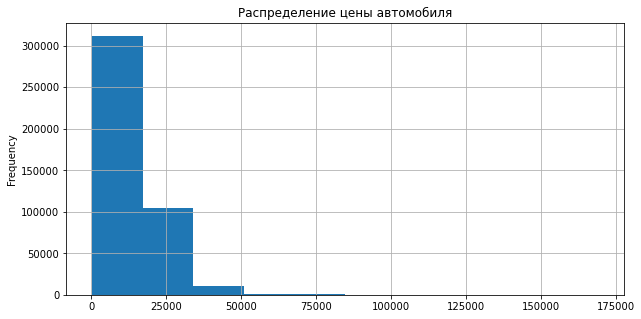

In [140]:
#смотрю гистограмму распределения цены автомобиля
(
    data_train['sellingprice']
    .plot(kind='hist', figsize=(10, 5), 
    grid=True, title='Распределение цены автомобиля')

);

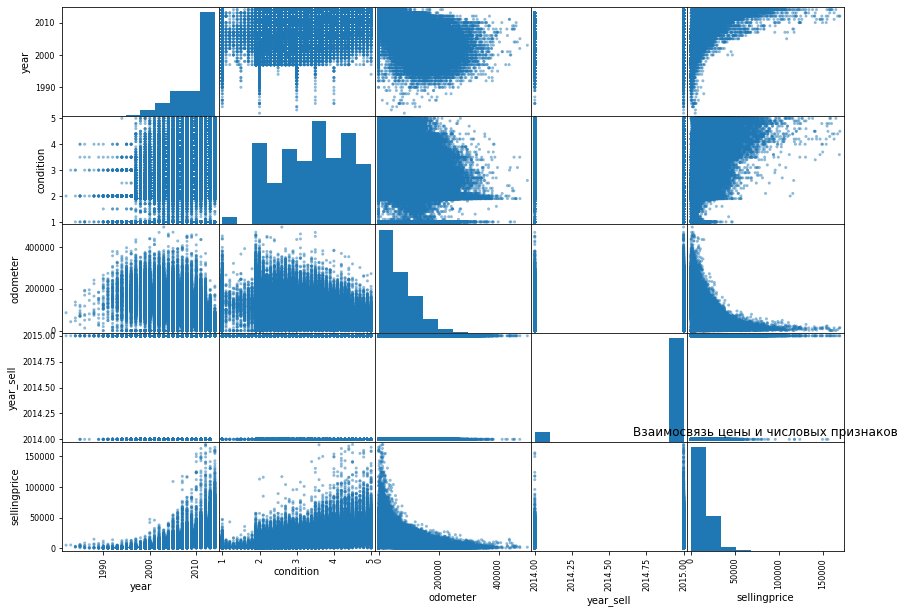

In [141]:
#смотрю взаимосвязь между числовыми признаками и ценой
numeric_features = ['year', 'condition', 'odometer', 'year_sell']
subset_data = data_train[numeric_features + ['sellingprice']]

pd.plotting.scatter_matrix(subset_data, figsize=(14, 10))
plt.title('Взаимосвязь цены и числовых признаков')
plt.show()

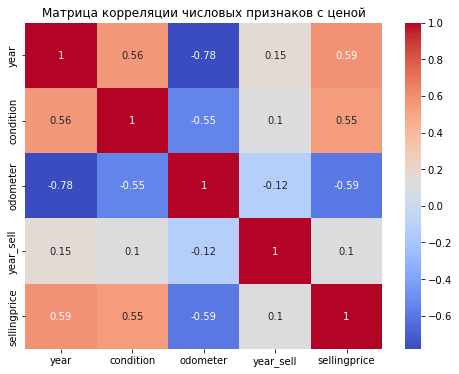

In [142]:
corr_matrix = subset_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции числовых признаков с ценой')
plt.show()

Цена авто держится до 80 тыс, причем основная масса авто - до 20 тыс.

На цену авто из числовых признаков влияют - год выпуска, состояние и пробег. Причем степень влияния примерно равна. Также эти три признака сильно коррелируют между собой. 

### 4. Feature engineering & feature extraction

#### Получение признаков

In [143]:
#отделяем признаки
target_train = data_train['sellingprice']
features_train = data_train.drop(['sellingprice', 'vin'], axis=1)

features_test = data_test.drop(['vin'], axis=1)

print('Поздравляю! Признаки готовы')

Поздравляю! Признаки готовы


In [144]:
#приводим формат данных к Unix timestamp и потом к числу, чтобы можно было использовать в обучении
features_train['saledate'] = features_train['saledate'].apply(
    lambda x: x.timestamp()).astype(int) // 10**9
features_test['saledate'] = features_test['saledate'].apply(
    lambda x: x.timestamp()).astype(int) // 10**9

In [145]:
#check
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428327 entries, 0 to 440235
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          428327 non-null  int64  
 1   make          428327 non-null  object 
 2   model         428327 non-null  object 
 3   trim          428327 non-null  object 
 4   body          428327 non-null  object 
 5   transmission  428327 non-null  object 
 6   state         428327 non-null  object 
 7   condition     428327 non-null  float64
 8   odometer      428327 non-null  float64
 9   color         428327 non-null  object 
 10  interior      428327 non-null  object 
 11  seller        428327 non-null  object 
 12  saledate      428327 non-null  int32  
 13  year_sell     428327 non-null  int64  
dtypes: float64(2), int32(1), int64(2), object(9)
memory usage: 63.5+ MB


In [146]:
#проверяю, нужно ли масштабировать признаки
features_train.agg([min, max])

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,saledate,year_sell
min,1982,acura,1 Series,!,access cab,automatic,ab,1.0,1.0,beige,beige,1 cochran of monroeville,1,2014
max,2014,vw,yukon,zxw ses,xtracab,unknown,wi,5.0,495757.0,—,—,zygi auto corp,1,2015


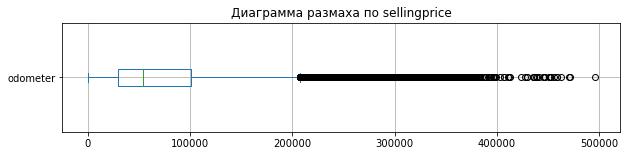

In [147]:
#этот признак сомтрю внимателбнее, большой разброс значений 
(
    features_train['odometer']
    .plot(kind='box', figsize=(10, 2), 
    grid=True, vert = False, title='Диаграмма размаха по sellingprice')

);

Вижу много выбросов. Сделаю стандартизацию. 

In [148]:
#масштабирование признаков
scaler = StandardScaler()
scaler.fit(features_train[['odometer']])
features_train['odometer'] = scaler.transform(features_train[['odometer']])
features_test['odometer'] = scaler.transform(features_test[['odometer']])
print('Поздравляю! Признаки приведены к одному масштабу')

Поздравляю! Признаки приведены к одному масштабу


In [149]:
#check
features_train['odometer'].agg([min, max])

min   -1.331231
max    8.146381
Name: odometer, dtype: float64

In [150]:
features_test['odometer'].agg([min, max])

min    -1.331231
max    17.786224
Name: odometer, dtype: float64

In [151]:
#выбираем продавцов, которые продали от 5 машин
seller_counts = features_train['seller'].value_counts()  
frequent_sellers = seller_counts[seller_counts >= 5].index  

filtered_train_indices = features_train[features_train['seller'].isin(frequent_sellers)].index

features_train = features_train.loc[filtered_train_indices]

target_train = target_train.loc[filtered_train_indices]

print('Значения из признака "seller", которые встречаются не менее 5 раз, успешно отделены!')

Значения из признака "seller", которые встречаются не менее 5 раз, успешно отделены!


In [152]:
features_train.shape

(414424, 14)

In [153]:
features_test.shape

(110058, 14)

In [154]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size = 0.25, random_state = 12345)

print('Данные для валидации готовы')

Данные для валидации готовы


In [155]:
#check
features_train.shape

(310818, 14)

In [156]:
features_valid.shape

(103606, 14)

In [157]:
features_train.head(2)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,saledate,year_sell
147872,2012,toyota,Camry,l,sedan,unknown,tn,4.3,0.020376,gray,gray,td auto finance,1,2015
214703,2011,honda,CR-V,ex-l,suv,unknown,fl,3.5,-0.300263,blue,gray,honda of ocala,1,2015


#### Кодирование признаков

In [158]:
#отделяем категориальные признаки
categorical = ['model', 'trim', 'body', 'transmission', 'make', 'state', 'color', 
               'interior', 'seller']

numeric = ['year', 'condition', 'odometer', 'saledate', 'year_sell']



print('Категориальные признаки отобраны')

Категориальные признаки отобраны


In [159]:
encoder = ce.TargetEncoder()
encoder.fit(features_train[categorical], target_train)

features_train_encoded = encoder.transform(features_train[categorical]).add_suffix('_encoded')

features_train = pd.concat([features_train[numeric], features_train_encoded], axis=1)

print('Тренировочную выборку закодировали!')

Тренировочную выборку закодировали!


In [160]:
#check
features_train.head(2)

,year,condition,odometer,saledate,year_sell,model_encoded,trim_encoded,body_encoded,transmission_encoded,make_encoded,state_encoded,color_encoded,interior_encoded,seller_encoded
147872,2012,4.3,0.020376,1,2015,11089.946978,13235.332353,11592.245494,14688.63125,12100.228795,16822.830756,13747.457473,10884.772598,13698.116883
214703,2011,3.5,-0.300263,1,2015,13278.442880,14635.308601,15763.081865,14688.63125,10908.685546,13575.959477,11329.803350,10884.772598,15255.313077


In [161]:
#кодируем валидационную выборку
features_valid_encoded = encoder.transform(features_valid[categorical]).add_suffix('_encoded')

features_valid = pd.concat([features_valid[numeric], features_valid_encoded], axis=1)

print('Валидационную выборку закодировали!')

Валидационную выборку закодировали!


In [162]:
#check
features_valid.head(2)

,year,condition,odometer,saledate,year_sell,model_encoded,trim_encoded,body_encoded,transmission_encoded,make_encoded,state_encoded,color_encoded,interior_encoded,seller_encoded
266245,2013,2.8,-0.951978,1,2015,17833.198017,15654.960111,15763.081865,13303.622831,14418.731487,13241.407052,15259.08937,15378.750619,17778.526343
349086,2014,3.7,-0.715304,1,2015,11089.946978,10439.207062,11592.245494,13303.622831,12100.228795,13575.959477,15259.08937,10884.772598,16118.936382


### 5. Обучение моделей и формирование предсказаний.

**Линейная регрессия**

In [163]:
model_regr = LinearRegression()

model_regr.fit(features_train, target_train)
predictions_regr_valid = pd.Series(model_regr.predict(features_valid))
result_regr = mean_squared_error(target_valid, predictions_regr_valid)**0.5

print('RMSE модели на валидационной выборке:', result_regr)

RMSE модели на валидационной выборке: 4606.049186927783


**HistGradientBoostingRegressor**

In [164]:
model_grad = HistGradientBoostingRegressor()

model_grad.fit(features_train, target_train)

predictions_grad_valid = model_grad.predict(features_valid)

result_grad = mean_squared_error(target_valid, predictions_grad_valid) ** 0.5
print('RMSE модели на валидационной выборке:', result_grad)

RMSE модели на валидационной выборке: 2649.708482149792


**LightGBM**

In [165]:
model_lgbm = LGBMRegressor()

model_lgbm.fit(features_train, target_train)

predictions_lgbm_valid = model_lgbm.predict(features_valid)

result_lgbm = mean_squared_error(target_valid, predictions_lgbm_valid) ** 0.5
print('RMSE модели на валидационной выборке:', result_lgbm)

RMSE модели на валидационной выборке: 2597.9980324269463


**eXtreme Gradient Boosting**

In [166]:
model_xgb = XGBRegressor()
model_xgb.fit(features_train, target_train)
predictions_xgb_valid = model_xgb.predict(features_valid)
result_xgb = mean_squared_error(target_valid, predictions_xgb_valid) ** 0.5
print('RMSE модели на валидационной выборке:', result_xgb)

RMSE модели на валидационной выборке: 2168.1928809816723


<div class="alert alert-info">
    попробовала подобрать параметры здесь, прошло несколько часов результата нет, я сдалась. Посмотрите подалуйста код, может что -то не так написано?
</div>

In [167]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [2, 4, 6, 8, 10]
}

model_xgb = XGBRegressor()

grid_search = GridSearchCV(model_xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(features_train, target_train)

best_model_xgb = grid_search.best_estimator_
predictions_xgb_valid = best_model_xgb.predict(features_valid)
result_xgb = mean_squared_error(target_valid, predictions_xgb_valid) ** 0.5

print('RMSE модели на валидационной выборке:', result_xgb)
print('Лучшие параметры:', grid_search.best_params_)

KeyboardInterrupt: 

**CatBoost**

In [168]:
model_cat = CatBoostRegressor()

model_cat.fit(features_train, target_train)

predictions_cat_valid = model_cat.predict(features_valid)

result_cat = mean_squared_error(target_valid, predictions_cat_valid) ** 0.5
print('RMSE модели на валидационной выборке:', result_cat)

Learning rate set to 0.10139
0:	learn: 8692.4818214	total: 54ms	remaining: 54s
1:	learn: 8101.7426015	total: 85ms	remaining: 42.4s
2:	learn: 7581.7347208	total: 120ms	remaining: 39.8s
3:	learn: 7130.9338330	total: 153ms	remaining: 38.1s
4:	learn: 6723.9365875	total: 190ms	remaining: 37.9s
5:	learn: 6369.2233040	total: 220ms	remaining: 36.5s
6:	learn: 6045.6089450	total: 250ms	remaining: 35.5s
7:	learn: 5769.2598193	total: 278ms	remaining: 34.5s
8:	learn: 5522.0298484	total: 308ms	remaining: 33.9s
9:	learn: 5298.5206534	total: 336ms	remaining: 33.3s
10:	learn: 5101.8197184	total: 374ms	remaining: 33.6s
11:	learn: 4922.5830115	total: 416ms	remaining: 34.3s
12:	learn: 4769.6736244	total: 460ms	remaining: 34.9s
13:	learn: 4630.8351265	total: 495ms	remaining: 34.9s
14:	learn: 4516.7394867	total: 528ms	remaining: 34.7s
15:	learn: 4400.8553768	total: 571ms	remaining: 35.1s
16:	learn: 4301.4214951	total: 632ms	remaining: 36.6s
17:	learn: 4211.4727347	total: 673ms	remaining: 36.7s
18:	learn: 41

153:	learn: 2824.1419327	total: 8.89s	remaining: 48.8s
154:	learn: 2821.3453860	total: 8.95s	remaining: 48.8s
155:	learn: 2820.2797938	total: 8.98s	remaining: 48.6s
156:	learn: 2816.5547160	total: 9.03s	remaining: 48.5s
157:	learn: 2813.1359988	total: 9.09s	remaining: 48.4s
158:	learn: 2810.6009674	total: 9.14s	remaining: 48.4s
159:	learn: 2805.4608234	total: 9.2s	remaining: 48.3s
160:	learn: 2803.2663633	total: 9.25s	remaining: 48.2s
161:	learn: 2800.7146431	total: 9.3s	remaining: 48.1s
162:	learn: 2796.1704220	total: 9.36s	remaining: 48.1s
163:	learn: 2792.9537581	total: 9.41s	remaining: 48s
164:	learn: 2790.6516774	total: 9.45s	remaining: 47.8s
165:	learn: 2789.6416904	total: 9.49s	remaining: 47.7s
166:	learn: 2785.6775338	total: 9.53s	remaining: 47.6s
167:	learn: 2784.3626114	total: 9.58s	remaining: 47.4s
168:	learn: 2780.1677228	total: 9.62s	remaining: 47.3s
169:	learn: 2777.0254944	total: 9.66s	remaining: 47.2s
170:	learn: 2773.1036973	total: 9.71s	remaining: 47.1s
171:	learn: 27

306:	learn: 2502.5902950	total: 16s	remaining: 36.2s
307:	learn: 2501.3188283	total: 16.1s	remaining: 36.1s
308:	learn: 2499.2379388	total: 16.1s	remaining: 36s
309:	learn: 2498.0136598	total: 16.2s	remaining: 36s
310:	learn: 2496.4142259	total: 16.2s	remaining: 35.9s
311:	learn: 2494.9652795	total: 16.3s	remaining: 35.9s
312:	learn: 2493.1594893	total: 16.3s	remaining: 35.8s
313:	learn: 2492.3149379	total: 16.4s	remaining: 35.7s
314:	learn: 2491.8211698	total: 16.4s	remaining: 35.6s
315:	learn: 2489.6038205	total: 16.4s	remaining: 35.6s
316:	learn: 2489.0610618	total: 16.5s	remaining: 35.5s
317:	learn: 2488.6761590	total: 16.5s	remaining: 35.4s
318:	learn: 2487.3102968	total: 16.6s	remaining: 35.4s
319:	learn: 2485.6635141	total: 16.6s	remaining: 35.3s
320:	learn: 2483.9816578	total: 16.6s	remaining: 35.2s
321:	learn: 2482.3932417	total: 16.7s	remaining: 35.1s
322:	learn: 2481.0829757	total: 16.7s	remaining: 35.1s
323:	learn: 2480.0489519	total: 16.8s	remaining: 35s
324:	learn: 2478.2

459:	learn: 2313.9718450	total: 23.1s	remaining: 27.2s
460:	learn: 2313.4689369	total: 23.2s	remaining: 27.1s
461:	learn: 2311.9505395	total: 23.3s	remaining: 27.1s
462:	learn: 2311.0555542	total: 23.3s	remaining: 27.1s
463:	learn: 2310.5209020	total: 23.4s	remaining: 27s
464:	learn: 2310.1224080	total: 23.5s	remaining: 27s
465:	learn: 2309.6950283	total: 23.5s	remaining: 26.9s
466:	learn: 2308.9480409	total: 23.6s	remaining: 26.9s
467:	learn: 2307.6409285	total: 23.6s	remaining: 26.8s
468:	learn: 2306.6520683	total: 23.6s	remaining: 26.8s
469:	learn: 2304.2635768	total: 23.7s	remaining: 26.7s
470:	learn: 2303.1181177	total: 23.7s	remaining: 26.6s
471:	learn: 2302.5571743	total: 23.8s	remaining: 26.6s
472:	learn: 2302.1829630	total: 23.8s	remaining: 26.5s
473:	learn: 2300.3245503	total: 23.8s	remaining: 26.5s
474:	learn: 2298.7161934	total: 23.9s	remaining: 26.4s
475:	learn: 2297.7989789	total: 23.9s	remaining: 26.3s
476:	learn: 2296.7394767	total: 24s	remaining: 26.3s
477:	learn: 2295

611:	learn: 2181.2841343	total: 31.7s	remaining: 20.1s
612:	learn: 2180.6359254	total: 31.8s	remaining: 20.1s
613:	learn: 2179.6642330	total: 31.8s	remaining: 20s
614:	learn: 2179.1636863	total: 31.9s	remaining: 19.9s
615:	learn: 2178.6376287	total: 31.9s	remaining: 19.9s
616:	learn: 2177.9168910	total: 32s	remaining: 19.8s
617:	learn: 2176.3576908	total: 32s	remaining: 19.8s
618:	learn: 2175.7447504	total: 32.1s	remaining: 19.7s
619:	learn: 2174.7019220	total: 32.1s	remaining: 19.7s
620:	learn: 2173.9638512	total: 32.2s	remaining: 19.6s
621:	learn: 2173.2237525	total: 32.2s	remaining: 19.6s
622:	learn: 2172.6247975	total: 32.3s	remaining: 19.5s
623:	learn: 2170.7536668	total: 32.3s	remaining: 19.5s
624:	learn: 2169.8705396	total: 32.4s	remaining: 19.4s
625:	learn: 2168.7892981	total: 32.4s	remaining: 19.4s
626:	learn: 2168.4965676	total: 32.5s	remaining: 19.3s
627:	learn: 2167.6499985	total: 32.5s	remaining: 19.3s
628:	learn: 2166.7860485	total: 32.6s	remaining: 19.2s
629:	learn: 2166

762:	learn: 2084.8397617	total: 39.7s	remaining: 12.3s
763:	learn: 2084.1970874	total: 39.7s	remaining: 12.3s
764:	learn: 2083.7481069	total: 39.8s	remaining: 12.2s
765:	learn: 2083.2403165	total: 39.8s	remaining: 12.2s
766:	learn: 2082.4725932	total: 39.9s	remaining: 12.1s
767:	learn: 2082.0318035	total: 40s	remaining: 12.1s
768:	learn: 2081.7938869	total: 40s	remaining: 12s
769:	learn: 2081.3726064	total: 40s	remaining: 12s
770:	learn: 2080.8311287	total: 40.1s	remaining: 11.9s
771:	learn: 2080.4663059	total: 40.1s	remaining: 11.9s
772:	learn: 2079.9181123	total: 40.2s	remaining: 11.8s
773:	learn: 2079.5337159	total: 40.2s	remaining: 11.8s
774:	learn: 2079.1503598	total: 40.3s	remaining: 11.7s
775:	learn: 2078.6391311	total: 40.3s	remaining: 11.6s
776:	learn: 2078.0663998	total: 40.4s	remaining: 11.6s
777:	learn: 2076.7758470	total: 40.4s	remaining: 11.5s
778:	learn: 2076.4402666	total: 40.5s	remaining: 11.5s
779:	learn: 2076.0590898	total: 40.5s	remaining: 11.4s
780:	learn: 2075.384

912:	learn: 2014.0210993	total: 46.7s	remaining: 4.45s
913:	learn: 2013.8248009	total: 46.7s	remaining: 4.4s
914:	learn: 2013.2536407	total: 46.8s	remaining: 4.34s
915:	learn: 2013.0087441	total: 46.8s	remaining: 4.29s
916:	learn: 2012.4953886	total: 46.9s	remaining: 4.24s
917:	learn: 2012.2524709	total: 46.9s	remaining: 4.19s
918:	learn: 2011.9396421	total: 47s	remaining: 4.14s
919:	learn: 2011.6879739	total: 47s	remaining: 4.09s
920:	learn: 2011.2109506	total: 47.1s	remaining: 4.04s
921:	learn: 2010.7825266	total: 47.1s	remaining: 3.98s
922:	learn: 2010.0665970	total: 47.2s	remaining: 3.93s
923:	learn: 2009.7673094	total: 47.2s	remaining: 3.88s
924:	learn: 2009.4833469	total: 47.2s	remaining: 3.83s
925:	learn: 2009.2223411	total: 47.3s	remaining: 3.78s
926:	learn: 2008.2965248	total: 47.4s	remaining: 3.73s
927:	learn: 2007.6808206	total: 47.4s	remaining: 3.68s
928:	learn: 2007.3798032	total: 47.4s	remaining: 3.63s
929:	learn: 2007.0497172	total: 47.5s	remaining: 3.57s
930:	learn: 200

In [169]:
#на той же модели подбираю лучшие параметры
param_grid = {
    'iterations': [100, 200, 300, 400, 500],
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [2, 4, 6, 8, 10]
}

random_search = RandomizedSearchCV(model_cat, param_distributions=param_grid, n_iter=10, cv=5, scoring='neg_mean_squared_error')
random_search.fit(features_train, target_train)

best_estimator_cat = random_search.best_estimator_

predictions_cat_valid = best_estimator_cat.predict(features_valid)
result_cat = mean_squared_error(target_valid, predictions_cat_valid) ** 0.5

print('Лучшие параметры:', random_search.best_params_)
print('RMSE модели на валидационной выборке:', result_cat)

0:	learn: 8663.5630964	total: 39.6ms	remaining: 15.8s
1:	learn: 8057.3048589	total: 70.8ms	remaining: 14.1s
2:	learn: 7509.7537987	total: 98ms	remaining: 13s
3:	learn: 7031.7288049	total: 126ms	remaining: 12.5s
4:	learn: 6610.4363989	total: 156ms	remaining: 12.4s
5:	learn: 6240.5464776	total: 187ms	remaining: 12.3s
6:	learn: 5907.4455637	total: 217ms	remaining: 12.2s
7:	learn: 5613.0369772	total: 248ms	remaining: 12.2s
8:	learn: 5357.1771301	total: 282ms	remaining: 12.3s
9:	learn: 5131.2624030	total: 311ms	remaining: 12.1s
10:	learn: 4930.0899703	total: 337ms	remaining: 11.9s
11:	learn: 4752.1272634	total: 363ms	remaining: 11.8s
12:	learn: 4598.0487015	total: 389ms	remaining: 11.6s
13:	learn: 4450.5151284	total: 414ms	remaining: 11.4s
14:	learn: 4325.1090528	total: 441ms	remaining: 11.3s
15:	learn: 4215.3507796	total: 474ms	remaining: 11.4s
16:	learn: 4115.5363812	total: 513ms	remaining: 11.6s
17:	learn: 4021.6954320	total: 548ms	remaining: 11.6s
18:	learn: 3943.3556751	total: 586ms	re

155:	learn: 2561.7434136	total: 5.96s	remaining: 9.31s
156:	learn: 2560.3476334	total: 5.99s	remaining: 9.28s
157:	learn: 2557.0347917	total: 6.03s	remaining: 9.23s
158:	learn: 2553.1982996	total: 6.06s	remaining: 9.18s
159:	learn: 2550.4232819	total: 6.09s	remaining: 9.14s
160:	learn: 2544.2730328	total: 6.12s	remaining: 9.09s
161:	learn: 2541.7623966	total: 6.16s	remaining: 9.05s
162:	learn: 2537.9303984	total: 6.19s	remaining: 9s
163:	learn: 2535.9416143	total: 6.23s	remaining: 8.96s
164:	learn: 2533.6033382	total: 6.26s	remaining: 8.92s
165:	learn: 2531.4678554	total: 6.3s	remaining: 8.88s
166:	learn: 2525.8760521	total: 6.33s	remaining: 8.83s
167:	learn: 2523.3539821	total: 6.36s	remaining: 8.78s
168:	learn: 2522.0984062	total: 6.38s	remaining: 8.73s
169:	learn: 2520.5160032	total: 6.41s	remaining: 8.68s
170:	learn: 2517.8731931	total: 6.45s	remaining: 8.63s
171:	learn: 2515.7718889	total: 6.48s	remaining: 8.59s
172:	learn: 2512.3671686	total: 6.5s	remaining: 8.54s
173:	learn: 250

310:	learn: 2227.2812537	total: 11.1s	remaining: 3.18s
311:	learn: 2225.1528350	total: 11.2s	remaining: 3.15s
312:	learn: 2224.3261949	total: 11.2s	remaining: 3.12s
313:	learn: 2222.3991540	total: 11.3s	remaining: 3.09s
314:	learn: 2221.0329610	total: 11.4s	remaining: 3.06s
315:	learn: 2219.8160431	total: 11.4s	remaining: 3.04s
316:	learn: 2218.4530234	total: 11.5s	remaining: 3.02s
317:	learn: 2217.9750512	total: 11.6s	remaining: 2.98s
318:	learn: 2216.2124605	total: 11.6s	remaining: 2.96s
319:	learn: 2214.5671157	total: 11.7s	remaining: 2.92s
320:	learn: 2211.6511460	total: 11.8s	remaining: 2.89s
321:	learn: 2210.0991714	total: 11.8s	remaining: 2.86s
322:	learn: 2207.6810623	total: 11.9s	remaining: 2.83s
323:	learn: 2206.0542530	total: 11.9s	remaining: 2.79s
324:	learn: 2204.7206208	total: 11.9s	remaining: 2.76s
325:	learn: 2203.1508097	total: 12s	remaining: 2.73s
326:	learn: 2201.8048602	total: 12.1s	remaining: 2.69s
327:	learn: 2199.2900551	total: 12.1s	remaining: 2.66s
328:	learn: 

64:	learn: 3015.2187103	total: 2.6s	remaining: 13.4s
65:	learn: 3007.4711213	total: 2.64s	remaining: 13.4s
66:	learn: 3001.8428601	total: 2.69s	remaining: 13.4s
67:	learn: 2993.0576280	total: 2.73s	remaining: 13.3s
68:	learn: 2983.3840651	total: 2.77s	remaining: 13.3s
69:	learn: 2974.2962628	total: 2.8s	remaining: 13.2s
70:	learn: 2970.3954686	total: 2.83s	remaining: 13.1s
71:	learn: 2965.6356821	total: 2.86s	remaining: 13s
72:	learn: 2960.6674050	total: 2.9s	remaining: 13s
73:	learn: 2955.4706734	total: 2.93s	remaining: 12.9s
74:	learn: 2950.3637201	total: 2.96s	remaining: 12.8s
75:	learn: 2945.2290593	total: 2.99s	remaining: 12.8s
76:	learn: 2939.6471075	total: 3.02s	remaining: 12.7s
77:	learn: 2933.6757283	total: 3.05s	remaining: 12.6s
78:	learn: 2930.4417518	total: 3.08s	remaining: 12.5s
79:	learn: 2927.0094384	total: 3.12s	remaining: 12.5s
80:	learn: 2921.7304606	total: 3.15s	remaining: 12.4s
81:	learn: 2909.2119737	total: 3.18s	remaining: 12.3s
82:	learn: 2904.8627119	total: 3.22

221:	learn: 2396.2736372	total: 8.21s	remaining: 6.59s
222:	learn: 2395.3285387	total: 8.25s	remaining: 6.54s
223:	learn: 2391.2805251	total: 8.28s	remaining: 6.5s
224:	learn: 2390.0645204	total: 8.31s	remaining: 6.46s
225:	learn: 2387.4805662	total: 8.34s	remaining: 6.42s
226:	learn: 2387.1966008	total: 8.35s	remaining: 6.37s
227:	learn: 2385.0683485	total: 8.39s	remaining: 6.33s
228:	learn: 2382.8789511	total: 8.42s	remaining: 6.29s
229:	learn: 2379.9795766	total: 8.46s	remaining: 6.25s
230:	learn: 2378.5721483	total: 8.49s	remaining: 6.21s
231:	learn: 2374.6846146	total: 8.52s	remaining: 6.17s
232:	learn: 2369.9882860	total: 8.56s	remaining: 6.14s
233:	learn: 2367.3084887	total: 8.59s	remaining: 6.1s
234:	learn: 2364.7786125	total: 8.63s	remaining: 6.06s
235:	learn: 2362.7865357	total: 8.66s	remaining: 6.02s
236:	learn: 2358.1443534	total: 8.7s	remaining: 5.98s
237:	learn: 2357.0315568	total: 8.73s	remaining: 5.95s
238:	learn: 2355.8199087	total: 8.77s	remaining: 5.91s
239:	learn: 2

376:	learn: 2125.4557562	total: 13.5s	remaining: 823ms
377:	learn: 2124.6376414	total: 13.5s	remaining: 787ms
378:	learn: 2123.8089753	total: 13.6s	remaining: 753ms
379:	learn: 2122.4561706	total: 13.7s	remaining: 720ms
380:	learn: 2121.7467887	total: 13.7s	remaining: 684ms
381:	learn: 2120.6684738	total: 13.8s	remaining: 650ms
382:	learn: 2119.3671716	total: 13.8s	remaining: 614ms
383:	learn: 2118.0683940	total: 13.9s	remaining: 578ms
384:	learn: 2117.2617173	total: 13.9s	remaining: 542ms
385:	learn: 2116.0828127	total: 13.9s	remaining: 506ms
386:	learn: 2115.1142492	total: 14s	remaining: 470ms
387:	learn: 2114.3415468	total: 14s	remaining: 434ms
388:	learn: 2113.4085304	total: 14.1s	remaining: 398ms
389:	learn: 2112.3308088	total: 14.1s	remaining: 362ms
390:	learn: 2110.1750936	total: 14.2s	remaining: 326ms
391:	learn: 2109.2158294	total: 14.2s	remaining: 290ms
392:	learn: 2108.3205190	total: 14.3s	remaining: 254ms
393:	learn: 2107.6148869	total: 14.3s	remaining: 218ms
394:	learn: 21

129:	learn: 2671.9658161	total: 5.83s	remaining: 12.1s
130:	learn: 2669.4195077	total: 5.87s	remaining: 12.1s
131:	learn: 2661.4389045	total: 5.92s	remaining: 12s
132:	learn: 2658.7706898	total: 5.96s	remaining: 12s
133:	learn: 2653.6215954	total: 6s	remaining: 11.9s
134:	learn: 2650.9386518	total: 6.04s	remaining: 11.9s
135:	learn: 2646.9763011	total: 6.07s	remaining: 11.8s
136:	learn: 2641.2476055	total: 6.11s	remaining: 11.7s
137:	learn: 2637.3465503	total: 6.14s	remaining: 11.7s
138:	learn: 2632.7294264	total: 6.18s	remaining: 11.6s
139:	learn: 2626.6471677	total: 6.22s	remaining: 11.6s
140:	learn: 2622.9233639	total: 6.27s	remaining: 11.5s
141:	learn: 2620.7136961	total: 6.31s	remaining: 11.5s
142:	learn: 2614.2786020	total: 6.38s	remaining: 11.5s
143:	learn: 2608.0450523	total: 6.44s	remaining: 11.4s
144:	learn: 2603.4771751	total: 6.49s	remaining: 11.4s
145:	learn: 2598.7696450	total: 6.54s	remaining: 11.4s
146:	learn: 2597.0310709	total: 6.58s	remaining: 11.3s
147:	learn: 2593.

283:	learn: 2274.7288239	total: 12s	remaining: 4.88s
284:	learn: 2273.2514569	total: 12s	remaining: 4.84s
285:	learn: 2272.0700359	total: 12s	remaining: 4.8s
286:	learn: 2270.5950389	total: 12.1s	remaining: 4.76s
287:	learn: 2269.7307543	total: 12.1s	remaining: 4.72s
288:	learn: 2267.6679974	total: 12.2s	remaining: 4.68s
289:	learn: 2265.9541453	total: 12.2s	remaining: 4.64s
290:	learn: 2263.9680533	total: 12.3s	remaining: 4.6s
291:	learn: 2262.2895541	total: 12.3s	remaining: 4.56s
292:	learn: 2260.1126083	total: 12.4s	remaining: 4.52s
293:	learn: 2258.2004392	total: 12.4s	remaining: 4.48s
294:	learn: 2256.5506924	total: 12.5s	remaining: 4.43s
295:	learn: 2255.3501790	total: 12.5s	remaining: 4.39s
296:	learn: 2253.7491602	total: 12.5s	remaining: 4.35s
297:	learn: 2252.0302598	total: 12.6s	remaining: 4.3s
298:	learn: 2250.5832502	total: 12.6s	remaining: 4.26s
299:	learn: 2248.6985009	total: 12.7s	remaining: 4.22s
300:	learn: 2247.2349700	total: 12.7s	remaining: 4.18s
301:	learn: 2244.41

35:	learn: 3308.7240090	total: 2.23s	remaining: 22.6s
36:	learn: 3293.9805982	total: 2.28s	remaining: 22.4s
37:	learn: 3271.8452951	total: 2.33s	remaining: 22.2s
38:	learn: 3256.7238576	total: 2.38s	remaining: 22s
39:	learn: 3241.3882726	total: 2.43s	remaining: 21.9s
40:	learn: 3230.5084179	total: 2.48s	remaining: 21.7s
41:	learn: 3220.6717950	total: 2.52s	remaining: 21.4s
42:	learn: 3207.3960916	total: 2.55s	remaining: 21.2s
43:	learn: 3193.2498658	total: 2.59s	remaining: 21s
44:	learn: 3180.8784994	total: 2.63s	remaining: 20.7s
45:	learn: 3167.0302123	total: 2.67s	remaining: 20.5s
46:	learn: 3155.0712421	total: 2.7s	remaining: 20.3s
47:	learn: 3145.9494778	total: 2.73s	remaining: 20.1s
48:	learn: 3130.3474514	total: 2.77s	remaining: 19.8s
49:	learn: 3118.2525378	total: 2.81s	remaining: 19.6s
50:	learn: 3105.1336242	total: 2.84s	remaining: 19.4s
51:	learn: 3097.2728455	total: 2.88s	remaining: 19.2s
52:	learn: 3085.8229209	total: 2.91s	remaining: 19.1s
53:	learn: 3077.3101173	total: 2.

188:	learn: 2477.4731862	total: 9.14s	remaining: 10.2s
189:	learn: 2474.2717752	total: 9.18s	remaining: 10.1s
190:	learn: 2469.6536269	total: 9.22s	remaining: 10.1s
191:	learn: 2464.3787132	total: 9.26s	remaining: 10s
192:	learn: 2460.4189113	total: 9.31s	remaining: 9.99s
193:	learn: 2458.4750634	total: 9.39s	remaining: 9.97s
194:	learn: 2455.9273747	total: 9.47s	remaining: 9.96s
195:	learn: 2454.0302306	total: 9.54s	remaining: 9.93s
196:	learn: 2450.9134949	total: 9.61s	remaining: 9.9s
197:	learn: 2448.5380758	total: 9.67s	remaining: 9.86s
198:	learn: 2444.4474091	total: 9.77s	remaining: 9.86s
199:	learn: 2441.4989536	total: 9.82s	remaining: 9.82s
200:	learn: 2438.8921711	total: 9.88s	remaining: 9.78s
201:	learn: 2435.7286142	total: 9.94s	remaining: 9.74s
202:	learn: 2432.2635292	total: 10s	remaining: 9.7s
203:	learn: 2430.3320738	total: 10.1s	remaining: 9.67s
204:	learn: 2428.5036004	total: 10.1s	remaining: 9.63s
205:	learn: 2426.1757587	total: 10.2s	remaining: 9.59s
206:	learn: 2422

341:	learn: 2190.1032215	total: 17.9s	remaining: 3.04s
342:	learn: 2188.5526056	total: 18s	remaining: 2.98s
343:	learn: 2185.9121091	total: 18s	remaining: 2.93s
344:	learn: 2185.2383868	total: 18s	remaining: 2.88s
345:	learn: 2184.6190387	total: 18.1s	remaining: 2.83s
346:	learn: 2183.8547525	total: 18.1s	remaining: 2.77s
347:	learn: 2182.2150960	total: 18.2s	remaining: 2.72s
348:	learn: 2181.2606646	total: 18.2s	remaining: 2.67s
349:	learn: 2179.2462299	total: 18.3s	remaining: 2.61s
350:	learn: 2178.6904072	total: 18.3s	remaining: 2.56s
351:	learn: 2176.9086394	total: 18.4s	remaining: 2.51s
352:	learn: 2175.6831088	total: 18.4s	remaining: 2.45s
353:	learn: 2174.3326858	total: 18.5s	remaining: 2.4s
354:	learn: 2172.1091974	total: 18.5s	remaining: 2.35s
355:	learn: 2171.6218805	total: 18.6s	remaining: 2.29s
356:	learn: 2170.8880705	total: 18.6s	remaining: 2.24s
357:	learn: 2169.2912185	total: 18.7s	remaining: 2.19s
358:	learn: 2168.3065145	total: 18.7s	remaining: 2.14s
359:	learn: 2166.

94:	learn: 2832.7276154	total: 4.84s	remaining: 15.6s
95:	learn: 2828.4509936	total: 4.89s	remaining: 15.5s
96:	learn: 2824.6956604	total: 4.93s	remaining: 15.4s
97:	learn: 2820.6404559	total: 4.98s	remaining: 15.3s
98:	learn: 2816.8797910	total: 5.02s	remaining: 15.3s
99:	learn: 2811.7192826	total: 5.08s	remaining: 15.2s
100:	learn: 2807.1175613	total: 5.13s	remaining: 15.2s
101:	learn: 2799.1699560	total: 5.18s	remaining: 15.1s
102:	learn: 2795.6176803	total: 5.23s	remaining: 15.1s
103:	learn: 2791.3461982	total: 5.28s	remaining: 15s
104:	learn: 2783.7954330	total: 5.33s	remaining: 15s
105:	learn: 2778.8911794	total: 5.38s	remaining: 14.9s
106:	learn: 2771.6828021	total: 5.42s	remaining: 14.8s
107:	learn: 2765.4182239	total: 5.48s	remaining: 14.8s
108:	learn: 2759.3727799	total: 5.53s	remaining: 14.8s
109:	learn: 2756.5786940	total: 5.58s	remaining: 14.7s
110:	learn: 2752.3210380	total: 5.62s	remaining: 14.6s
111:	learn: 2747.8142919	total: 5.67s	remaining: 14.6s
112:	learn: 2745.126

248:	learn: 2334.8490175	total: 12.3s	remaining: 7.47s
249:	learn: 2331.8067783	total: 12.4s	remaining: 7.41s
250:	learn: 2330.1912520	total: 12.4s	remaining: 7.35s
251:	learn: 2328.8706506	total: 12.4s	remaining: 7.3s
252:	learn: 2327.2630742	total: 12.5s	remaining: 7.25s
253:	learn: 2326.6764318	total: 12.5s	remaining: 7.2s
254:	learn: 2323.9537972	total: 12.6s	remaining: 7.14s
255:	learn: 2321.0463876	total: 12.6s	remaining: 7.09s
256:	learn: 2318.9542642	total: 12.6s	remaining: 7.04s
257:	learn: 2316.5149514	total: 12.7s	remaining: 6.99s
258:	learn: 2314.0078067	total: 12.7s	remaining: 6.94s
259:	learn: 2311.4534945	total: 12.8s	remaining: 6.89s
260:	learn: 2310.1027863	total: 12.8s	remaining: 6.83s
261:	learn: 2307.0749525	total: 12.9s	remaining: 6.78s
262:	learn: 2305.1086297	total: 12.9s	remaining: 6.73s
263:	learn: 2302.0779161	total: 13s	remaining: 6.68s
264:	learn: 2300.8279505	total: 13s	remaining: 6.62s
265:	learn: 2299.2864022	total: 13s	remaining: 6.57s
266:	learn: 2297.5

398:	learn: 2103.6236559	total: 19.5s	remaining: 48.8ms
399:	learn: 2102.8177191	total: 19.5s	remaining: 0us
0:	learn: 9350.1928791	total: 84.6ms	remaining: 42.2s
1:	learn: 9343.0361420	total: 161ms	remaining: 40s
2:	learn: 9335.8975404	total: 242ms	remaining: 40.1s
3:	learn: 9328.7232936	total: 323ms	remaining: 40.1s
4:	learn: 9321.6106964	total: 404ms	remaining: 40s
5:	learn: 9314.5151573	total: 487ms	remaining: 40.1s
6:	learn: 9307.3872273	total: 572ms	remaining: 40.3s
7:	learn: 9300.2399175	total: 665ms	remaining: 40.9s
8:	learn: 9293.1708442	total: 767ms	remaining: 41.9s
9:	learn: 9286.0502820	total: 914ms	remaining: 44.8s
10:	learn: 9278.9487518	total: 1.07s	remaining: 47.4s
11:	learn: 9271.8647318	total: 1.18s	remaining: 47.9s
12:	learn: 9264.7528833	total: 1.27s	remaining: 47.5s
13:	learn: 9257.7281114	total: 1.36s	remaining: 47.4s
14:	learn: 9250.6339966	total: 1.47s	remaining: 47.6s
15:	learn: 9243.5734745	total: 1.55s	remaining: 47s
16:	learn: 9236.4911206	total: 1.64s	remai

150:	learn: 8362.1062676	total: 19.4s	remaining: 44.9s
151:	learn: 8356.0589538	total: 19.5s	remaining: 44.7s
152:	learn: 8350.0389848	total: 19.7s	remaining: 44.6s
153:	learn: 8343.9971295	total: 19.8s	remaining: 44.4s
154:	learn: 8337.9949807	total: 19.9s	remaining: 44.3s
155:	learn: 8331.9956259	total: 20s	remaining: 44.1s
156:	learn: 8326.0085434	total: 20.1s	remaining: 44s
157:	learn: 8320.0287918	total: 20.3s	remaining: 43.9s
158:	learn: 8314.0493403	total: 20.4s	remaining: 43.8s
159:	learn: 8308.1223811	total: 20.6s	remaining: 43.8s
160:	learn: 8302.1573032	total: 20.8s	remaining: 43.8s
161:	learn: 8296.1714591	total: 21s	remaining: 43.8s
162:	learn: 8290.2291086	total: 21.2s	remaining: 43.7s
163:	learn: 8284.2602670	total: 21.3s	remaining: 43.6s
164:	learn: 8278.2990332	total: 21.4s	remaining: 43.5s
165:	learn: 8272.3249027	total: 21.6s	remaining: 43.5s
166:	learn: 8266.3689753	total: 21.8s	remaining: 43.4s
167:	learn: 8260.4360503	total: 21.9s	remaining: 43.2s
168:	learn: 8254

301:	learn: 7524.6085758	total: 43.7s	remaining: 28.6s
302:	learn: 7519.5495536	total: 43.9s	remaining: 28.5s
303:	learn: 7514.4359669	total: 44.1s	remaining: 28.4s
304:	learn: 7509.3690079	total: 44.3s	remaining: 28.3s
305:	learn: 7504.3109699	total: 44.4s	remaining: 28.2s
306:	learn: 7499.2685306	total: 44.6s	remaining: 28s
307:	learn: 7494.2233391	total: 44.9s	remaining: 28s
308:	learn: 7489.1999699	total: 45.1s	remaining: 27.9s
309:	learn: 7484.1621386	total: 45.3s	remaining: 27.8s
310:	learn: 7479.1300048	total: 45.4s	remaining: 27.6s
311:	learn: 7474.0845664	total: 45.6s	remaining: 27.5s
312:	learn: 7469.0631272	total: 45.7s	remaining: 27.3s
313:	learn: 7464.0254129	total: 45.8s	remaining: 27.1s
314:	learn: 7459.0152556	total: 45.9s	remaining: 27s
315:	learn: 7454.0168018	total: 46.1s	remaining: 26.8s
316:	learn: 7448.9972412	total: 46.3s	remaining: 26.7s
317:	learn: 7443.9774605	total: 46.4s	remaining: 26.6s
318:	learn: 7439.0150016	total: 46.6s	remaining: 26.4s
319:	learn: 7434

452:	learn: 6821.1015703	total: 1m 4s	remaining: 6.72s
453:	learn: 6816.7719787	total: 1m 4s	remaining: 6.57s
454:	learn: 6812.4828512	total: 1m 4s	remaining: 6.42s
455:	learn: 6808.2086338	total: 1m 5s	remaining: 6.27s
456:	learn: 6803.9717015	total: 1m 5s	remaining: 6.13s
457:	learn: 6799.7429860	total: 1m 5s	remaining: 5.99s
458:	learn: 6795.5462546	total: 1m 5s	remaining: 5.84s
459:	learn: 6791.2856320	total: 1m 5s	remaining: 5.69s
460:	learn: 6787.0167106	total: 1m 5s	remaining: 5.55s
461:	learn: 6782.7950995	total: 1m 5s	remaining: 5.4s
462:	learn: 6778.5525015	total: 1m 5s	remaining: 5.26s
463:	learn: 6774.3528209	total: 1m 5s	remaining: 5.11s
464:	learn: 6770.0911001	total: 1m 5s	remaining: 4.97s
465:	learn: 6765.8475768	total: 1m 6s	remaining: 4.82s
466:	learn: 6761.6533709	total: 1m 6s	remaining: 4.68s
467:	learn: 6757.4866663	total: 1m 6s	remaining: 4.53s
468:	learn: 6753.3301214	total: 1m 6s	remaining: 4.39s
469:	learn: 6749.1595741	total: 1m 6s	remaining: 4.25s
470:	learn:

105:	learn: 8639.1451023	total: 11.4s	remaining: 42.5s
106:	learn: 8632.7737272	total: 11.6s	remaining: 42.4s
107:	learn: 8626.4541709	total: 11.7s	remaining: 42.3s
108:	learn: 8620.0668801	total: 11.7s	remaining: 42.1s
109:	learn: 8613.7536209	total: 11.8s	remaining: 42s
110:	learn: 8607.4104863	total: 11.9s	remaining: 41.8s
111:	learn: 8601.0901047	total: 12s	remaining: 41.6s
112:	learn: 8594.7535919	total: 12.1s	remaining: 41.5s
113:	learn: 8588.3989494	total: 12.2s	remaining: 41.4s
114:	learn: 8582.1541003	total: 12.3s	remaining: 41.3s
115:	learn: 8575.8718455	total: 12.4s	remaining: 41.1s
116:	learn: 8569.5916974	total: 12.5s	remaining: 41s
117:	learn: 8563.2877759	total: 12.6s	remaining: 40.9s
118:	learn: 8557.0011511	total: 12.7s	remaining: 40.8s
119:	learn: 8550.7180092	total: 12.8s	remaining: 40.7s
120:	learn: 8544.4700110	total: 12.9s	remaining: 40.5s
121:	learn: 8538.2006418	total: 13s	remaining: 40.3s
122:	learn: 8531.9468738	total: 13.1s	remaining: 40.2s
123:	learn: 8525.7

257:	learn: 7751.5926824	total: 26.6s	remaining: 25s
258:	learn: 7746.2206719	total: 26.7s	remaining: 24.9s
259:	learn: 7740.8345495	total: 26.8s	remaining: 24.8s
260:	learn: 7735.5008296	total: 26.9s	remaining: 24.7s
261:	learn: 7730.2235409	total: 27s	remaining: 24.6s
262:	learn: 7724.8844767	total: 27.1s	remaining: 24.5s
263:	learn: 7719.5515166	total: 27.2s	remaining: 24.4s
264:	learn: 7714.2130528	total: 27.4s	remaining: 24.3s
265:	learn: 7708.8786713	total: 27.5s	remaining: 24.2s
266:	learn: 7703.6335330	total: 27.6s	remaining: 24.1s
267:	learn: 7698.3856668	total: 27.7s	remaining: 23.9s
268:	learn: 7693.1185607	total: 27.8s	remaining: 23.8s
269:	learn: 7687.8795359	total: 27.8s	remaining: 23.7s
270:	learn: 7682.6157320	total: 27.9s	remaining: 23.6s
271:	learn: 7677.3430404	total: 28s	remaining: 23.5s
272:	learn: 7672.0847192	total: 28.1s	remaining: 23.4s
273:	learn: 7666.7854153	total: 28.2s	remaining: 23.3s
274:	learn: 7661.5606141	total: 28.3s	remaining: 23.2s
275:	learn: 7656

409:	learn: 7005.8839044	total: 42s	remaining: 9.22s
410:	learn: 7001.3950038	total: 42.1s	remaining: 9.12s
411:	learn: 6996.9743450	total: 42.2s	remaining: 9.02s
412:	learn: 6992.4913019	total: 42.3s	remaining: 8.92s
413:	learn: 6988.0396168	total: 42.4s	remaining: 8.81s
414:	learn: 6983.5589340	total: 42.5s	remaining: 8.71s
415:	learn: 6979.0815252	total: 42.6s	remaining: 8.61s
416:	learn: 6974.5723641	total: 42.7s	remaining: 8.5s
417:	learn: 6970.0886805	total: 42.8s	remaining: 8.4s
418:	learn: 6965.6532663	total: 42.9s	remaining: 8.3s
419:	learn: 6961.1788851	total: 43s	remaining: 8.19s
420:	learn: 6956.7482572	total: 43.1s	remaining: 8.09s
421:	learn: 6952.3356142	total: 43.2s	remaining: 7.99s
422:	learn: 6947.8993576	total: 43.3s	remaining: 7.89s
423:	learn: 6943.5045243	total: 43.4s	remaining: 7.79s
424:	learn: 6939.1222223	total: 43.5s	remaining: 7.68s
425:	learn: 6934.7244558	total: 43.6s	remaining: 7.58s
426:	learn: 6930.3145617	total: 43.7s	remaining: 7.48s
427:	learn: 6925.

63:	learn: 8927.1086568	total: 7.58s	remaining: 51.6s
64:	learn: 8920.4423908	total: 7.67s	remaining: 51.4s
65:	learn: 8913.7741455	total: 7.78s	remaining: 51.1s
66:	learn: 8907.1234310	total: 7.88s	remaining: 50.9s
67:	learn: 8900.4322342	total: 7.99s	remaining: 50.7s
68:	learn: 8893.7687766	total: 8.08s	remaining: 50.5s
69:	learn: 8887.1492447	total: 8.19s	remaining: 50.3s
70:	learn: 8880.4791182	total: 8.29s	remaining: 50.1s
71:	learn: 8873.9099651	total: 8.39s	remaining: 49.9s
72:	learn: 8867.2646769	total: 8.48s	remaining: 49.6s
73:	learn: 8860.6412330	total: 8.58s	remaining: 49.4s
74:	learn: 8854.0437154	total: 8.69s	remaining: 49.2s
75:	learn: 8847.4735475	total: 8.79s	remaining: 49s
76:	learn: 8840.8593035	total: 8.89s	remaining: 48.9s
77:	learn: 8834.3151872	total: 8.99s	remaining: 48.7s
78:	learn: 8827.7302074	total: 9.08s	remaining: 48.4s
79:	learn: 8821.1826014	total: 9.18s	remaining: 48.2s
80:	learn: 8814.5871916	total: 9.27s	remaining: 47.9s
81:	learn: 8808.0123716	total:

214:	learn: 8000.2599135	total: 24.4s	remaining: 32.4s
215:	learn: 7994.6218110	total: 24.5s	remaining: 32.3s
216:	learn: 7988.9539410	total: 24.6s	remaining: 32.1s
217:	learn: 7983.3241148	total: 24.8s	remaining: 32.1s
218:	learn: 7977.7119655	total: 24.9s	remaining: 32s
219:	learn: 7972.1349945	total: 25s	remaining: 31.9s
220:	learn: 7966.5760923	total: 25.2s	remaining: 31.8s
221:	learn: 7960.9443308	total: 25.3s	remaining: 31.7s
222:	learn: 7955.3295857	total: 25.4s	remaining: 31.5s
223:	learn: 7949.7562372	total: 25.5s	remaining: 31.4s
224:	learn: 7944.1907200	total: 25.6s	remaining: 31.3s
225:	learn: 7938.6259778	total: 25.7s	remaining: 31.2s
226:	learn: 7933.0713842	total: 25.8s	remaining: 31s
227:	learn: 7927.5213420	total: 25.9s	remaining: 30.9s
228:	learn: 7922.0037660	total: 26.1s	remaining: 30.9s
229:	learn: 7916.4658093	total: 26.2s	remaining: 30.8s
230:	learn: 7910.9111830	total: 26.3s	remaining: 30.6s
231:	learn: 7905.3811539	total: 26.4s	remaining: 30.5s
232:	learn: 7899

365:	learn: 7219.2323938	total: 44s	remaining: 16.1s
366:	learn: 7214.4831514	total: 44.2s	remaining: 16s
367:	learn: 7209.7476692	total: 44.3s	remaining: 15.9s
368:	learn: 7205.0218517	total: 44.4s	remaining: 15.8s
369:	learn: 7200.2997604	total: 44.6s	remaining: 15.7s
370:	learn: 7195.5692038	total: 44.7s	remaining: 15.5s
371:	learn: 7190.8728245	total: 44.8s	remaining: 15.4s
372:	learn: 7186.1443704	total: 44.9s	remaining: 15.3s
373:	learn: 7181.4937873	total: 45.1s	remaining: 15.2s
374:	learn: 7176.8092065	total: 45.2s	remaining: 15.1s
375:	learn: 7172.1185093	total: 45.3s	remaining: 15s
376:	learn: 7167.5416804	total: 45.5s	remaining: 14.8s
377:	learn: 7162.8527205	total: 45.6s	remaining: 14.7s
378:	learn: 7158.2058096	total: 45.7s	remaining: 14.6s
379:	learn: 7153.5314439	total: 45.9s	remaining: 14.5s
380:	learn: 7148.8861034	total: 46s	remaining: 14.4s
381:	learn: 7144.2437209	total: 46.1s	remaining: 14.2s
382:	learn: 7139.6072971	total: 46.3s	remaining: 14.1s
383:	learn: 7134.9

16:	learn: 9258.7994044	total: 1.86s	remaining: 53s
17:	learn: 9251.7264281	total: 1.98s	remaining: 52.9s
18:	learn: 9244.6469398	total: 2.1s	remaining: 53s
19:	learn: 9237.5646619	total: 2.2s	remaining: 52.9s
20:	learn: 9230.5469290	total: 2.31s	remaining: 52.6s
21:	learn: 9223.5092580	total: 2.4s	remaining: 52.2s
22:	learn: 9216.4373389	total: 2.5s	remaining: 51.8s
23:	learn: 9209.3933916	total: 2.6s	remaining: 51.6s
24:	learn: 9202.4255256	total: 2.71s	remaining: 51.5s
25:	learn: 9195.5062312	total: 2.82s	remaining: 51.5s
26:	learn: 9188.5054159	total: 2.92s	remaining: 51.2s
27:	learn: 9181.5600931	total: 3.03s	remaining: 51.1s
28:	learn: 9174.5217524	total: 3.15s	remaining: 51.1s
29:	learn: 9167.5651341	total: 3.25s	remaining: 51s
30:	learn: 9160.6238682	total: 3.35s	remaining: 50.7s
31:	learn: 9153.6815715	total: 3.45s	remaining: 50.5s
32:	learn: 9146.7414617	total: 3.54s	remaining: 50.1s
33:	learn: 9139.7671536	total: 3.64s	remaining: 49.9s
34:	learn: 9132.8605181	total: 3.73s	re

168:	learn: 8272.5267158	total: 18.9s	remaining: 37s
169:	learn: 8266.5616241	total: 19.1s	remaining: 37s
170:	learn: 8260.6632586	total: 19.2s	remaining: 37s
171:	learn: 8254.7126272	total: 19.3s	remaining: 36.9s
172:	learn: 8248.7608796	total: 19.5s	remaining: 36.8s
173:	learn: 8242.8432534	total: 19.6s	remaining: 36.7s
174:	learn: 8236.9285268	total: 19.7s	remaining: 36.5s
175:	learn: 8230.9875842	total: 19.8s	remaining: 36.4s
176:	learn: 8225.1075208	total: 19.9s	remaining: 36.3s
177:	learn: 8219.2022262	total: 20s	remaining: 36.3s
178:	learn: 8213.3306491	total: 20.2s	remaining: 36.2s
179:	learn: 8207.4405433	total: 20.3s	remaining: 36.1s
180:	learn: 8201.5621710	total: 20.5s	remaining: 36.1s
181:	learn: 8195.6797218	total: 20.6s	remaining: 36.1s
182:	learn: 8189.8020175	total: 20.8s	remaining: 36s
183:	learn: 8184.0151367	total: 20.9s	remaining: 35.9s
184:	learn: 8178.1347175	total: 21s	remaining: 35.8s
185:	learn: 8172.3119024	total: 21.1s	remaining: 35.7s
186:	learn: 8166.46302

319:	learn: 7447.3632255	total: 37.3s	remaining: 21s
320:	learn: 7442.3233385	total: 37.4s	remaining: 20.9s
321:	learn: 7437.2998108	total: 37.5s	remaining: 20.8s
322:	learn: 7432.3299173	total: 37.7s	remaining: 20.6s
323:	learn: 7427.3136029	total: 37.9s	remaining: 20.6s
324:	learn: 7422.2873074	total: 38s	remaining: 20.5s
325:	learn: 7417.3358693	total: 38.2s	remaining: 20.4s
326:	learn: 7412.3662913	total: 38.3s	remaining: 20.3s
327:	learn: 7407.3806003	total: 38.4s	remaining: 20.1s
328:	learn: 7402.4192231	total: 38.5s	remaining: 20s
329:	learn: 7397.4253662	total: 38.6s	remaining: 19.9s
330:	learn: 7392.4358411	total: 38.8s	remaining: 19.8s
331:	learn: 7387.4779223	total: 38.9s	remaining: 19.7s
332:	learn: 7382.5410039	total: 39s	remaining: 19.6s
333:	learn: 7377.5930248	total: 39.2s	remaining: 19.5s
334:	learn: 7372.7042192	total: 39.3s	remaining: 19.4s
335:	learn: 7367.7598692	total: 39.4s	remaining: 19.2s
336:	learn: 7362.8545641	total: 39.5s	remaining: 19.1s
337:	learn: 7357.9

471:	learn: 6749.4222308	total: 56.4s	remaining: 3.34s
472:	learn: 6745.2228230	total: 56.5s	remaining: 3.22s
473:	learn: 6741.0434146	total: 56.6s	remaining: 3.1s
474:	learn: 6736.8415456	total: 56.7s	remaining: 2.98s
475:	learn: 6732.6363262	total: 56.8s	remaining: 2.86s
476:	learn: 6728.4938702	total: 56.9s	remaining: 2.74s
477:	learn: 6724.4047900	total: 57s	remaining: 2.62s
478:	learn: 6720.1955374	total: 57.1s	remaining: 2.5s
479:	learn: 6716.0513455	total: 57.2s	remaining: 2.38s
480:	learn: 6711.8835321	total: 57.4s	remaining: 2.27s
481:	learn: 6707.6978930	total: 57.4s	remaining: 2.15s
482:	learn: 6703.5986790	total: 57.5s	remaining: 2.02s
483:	learn: 6699.4970175	total: 57.6s	remaining: 1.91s
484:	learn: 6695.3137090	total: 57.7s	remaining: 1.78s
485:	learn: 6691.2234822	total: 57.9s	remaining: 1.67s
486:	learn: 6687.1098243	total: 58s	remaining: 1.55s
487:	learn: 6683.0289737	total: 58.1s	remaining: 1.43s
488:	learn: 6678.8688890	total: 58.2s	remaining: 1.31s
489:	learn: 6674

124:	learn: 8540.9679154	total: 14.9s	remaining: 44.8s
125:	learn: 8534.7140283	total: 15s	remaining: 44.6s
126:	learn: 8528.4825871	total: 15.2s	remaining: 44.5s
127:	learn: 8522.2695313	total: 15.3s	remaining: 44.4s
128:	learn: 8516.0464500	total: 15.4s	remaining: 44.3s
129:	learn: 8509.8428121	total: 15.5s	remaining: 44.2s
130:	learn: 8503.6440243	total: 15.6s	remaining: 44s
131:	learn: 8497.5068561	total: 15.7s	remaining: 43.8s
132:	learn: 8491.2941201	total: 15.8s	remaining: 43.7s
133:	learn: 8485.1720394	total: 16s	remaining: 43.8s
134:	learn: 8478.9744632	total: 16.3s	remaining: 44s
135:	learn: 8472.8201749	total: 16.4s	remaining: 43.9s
136:	learn: 8466.6662834	total: 16.5s	remaining: 43.8s
137:	learn: 8460.5117553	total: 16.7s	remaining: 43.7s
138:	learn: 8454.3501894	total: 16.8s	remaining: 43.6s
139:	learn: 8448.2502305	total: 16.9s	remaining: 43.4s
140:	learn: 8442.1187229	total: 17s	remaining: 43.3s
141:	learn: 8435.9673536	total: 17.1s	remaining: 43.2s
142:	learn: 8429.856

275:	learn: 7674.7532807	total: 34s	remaining: 27.6s
276:	learn: 7669.5062872	total: 34.1s	remaining: 27.4s
277:	learn: 7664.2507041	total: 34.2s	remaining: 27.3s
278:	learn: 7658.9679113	total: 34.3s	remaining: 27.2s
279:	learn: 7653.7294984	total: 34.4s	remaining: 27s
280:	learn: 7648.4463529	total: 34.5s	remaining: 26.9s
281:	learn: 7643.2615357	total: 34.6s	remaining: 26.7s
282:	learn: 7638.0323664	total: 34.7s	remaining: 26.6s
283:	learn: 7632.8306639	total: 34.7s	remaining: 26.4s
284:	learn: 7627.6072239	total: 34.8s	remaining: 26.3s
285:	learn: 7622.3930404	total: 34.9s	remaining: 26.1s
286:	learn: 7617.1937479	total: 35s	remaining: 26s
287:	learn: 7611.9722474	total: 35.2s	remaining: 25.9s
288:	learn: 7606.7747007	total: 35.3s	remaining: 25.8s
289:	learn: 7601.5439757	total: 35.4s	remaining: 25.6s
290:	learn: 7596.3478909	total: 35.5s	remaining: 25.5s
291:	learn: 7591.1981334	total: 35.6s	remaining: 25.4s
292:	learn: 7586.0682973	total: 35.7s	remaining: 25.2s
293:	learn: 7580.9

428:	learn: 6936.7567145	total: 49.3s	remaining: 8.16s
429:	learn: 6932.3231141	total: 49.4s	remaining: 8.04s
430:	learn: 6927.9000911	total: 49.5s	remaining: 7.92s
431:	learn: 6923.4602931	total: 49.6s	remaining: 7.81s
432:	learn: 6919.0601977	total: 49.7s	remaining: 7.69s
433:	learn: 6914.7235808	total: 49.8s	remaining: 7.57s
434:	learn: 6910.3343996	total: 49.9s	remaining: 7.45s
435:	learn: 6905.9876400	total: 50s	remaining: 7.34s
436:	learn: 6901.6166636	total: 50.1s	remaining: 7.22s
437:	learn: 6897.2444017	total: 50.2s	remaining: 7.11s
438:	learn: 6892.8692322	total: 50.3s	remaining: 6.99s
439:	learn: 6888.5435295	total: 50.4s	remaining: 6.88s
440:	learn: 6884.2437350	total: 50.5s	remaining: 6.76s
441:	learn: 6879.9264195	total: 50.6s	remaining: 6.64s
442:	learn: 6875.6087046	total: 50.7s	remaining: 6.53s
443:	learn: 6871.2860584	total: 50.8s	remaining: 6.41s
444:	learn: 6866.9862717	total: 50.9s	remaining: 6.3s
445:	learn: 6862.6220019	total: 51s	remaining: 6.18s
446:	learn: 685

85:	learn: 3730.3353310	total: 2.32s	remaining: 377ms
86:	learn: 3726.1416516	total: 2.38s	remaining: 355ms
87:	learn: 3720.4542627	total: 2.41s	remaining: 329ms
88:	learn: 3716.5442832	total: 2.46s	remaining: 304ms
89:	learn: 3711.2370916	total: 2.52s	remaining: 280ms
90:	learn: 3706.6329154	total: 2.56s	remaining: 253ms
91:	learn: 3702.3474220	total: 2.59s	remaining: 226ms
92:	learn: 3697.6160750	total: 2.64s	remaining: 199ms
93:	learn: 3692.1597625	total: 2.7s	remaining: 172ms
94:	learn: 3688.7009792	total: 2.74s	remaining: 144ms
95:	learn: 3685.8111590	total: 2.77s	remaining: 116ms
96:	learn: 3683.1508538	total: 2.8s	remaining: 86.7ms
97:	learn: 3678.3885858	total: 2.83s	remaining: 57.9ms
98:	learn: 3675.0986863	total: 2.87s	remaining: 29ms
99:	learn: 3671.8846643	total: 2.9s	remaining: 0us
0:	learn: 8838.0797411	total: 27.3ms	remaining: 2.7s
1:	learn: 8383.7578292	total: 46.5ms	remaining: 2.28s
2:	learn: 7993.9120579	total: 66.7ms	remaining: 2.15s
3:	learn: 7694.5582200	total: 86.

38:	learn: 4235.1631377	total: 872ms	remaining: 1.36s
39:	learn: 4213.7315554	total: 892ms	remaining: 1.34s
40:	learn: 4191.0937766	total: 912ms	remaining: 1.31s
41:	learn: 4166.6383338	total: 931ms	remaining: 1.28s
42:	learn: 4143.2857507	total: 949ms	remaining: 1.26s
43:	learn: 4124.5577899	total: 970ms	remaining: 1.24s
44:	learn: 4104.3870503	total: 989ms	remaining: 1.21s
45:	learn: 4083.5884121	total: 1.01s	remaining: 1.18s
46:	learn: 4065.3290939	total: 1.03s	remaining: 1.16s
47:	learn: 4049.7208896	total: 1.05s	remaining: 1.14s
48:	learn: 4035.2619638	total: 1.08s	remaining: 1.12s
49:	learn: 4019.4613750	total: 1.1s	remaining: 1.1s
50:	learn: 4005.5493744	total: 1.12s	remaining: 1.07s
51:	learn: 3991.4201320	total: 1.14s	remaining: 1.05s
52:	learn: 3978.6575192	total: 1.16s	remaining: 1.03s
53:	learn: 3966.0594509	total: 1.19s	remaining: 1.01s
54:	learn: 3954.7610575	total: 1.21s	remaining: 987ms
55:	learn: 3941.1264930	total: 1.24s	remaining: 972ms
56:	learn: 3929.7739335	total:

93:	learn: 3669.0954678	total: 2.72s	remaining: 174ms
94:	learn: 3665.5511071	total: 2.74s	remaining: 144ms
95:	learn: 3660.7969120	total: 2.77s	remaining: 115ms
96:	learn: 3657.8520632	total: 2.79s	remaining: 86.4ms
97:	learn: 3654.9138827	total: 2.82s	remaining: 57.5ms
98:	learn: 3650.4059647	total: 2.84s	remaining: 28.7ms
99:	learn: 3642.8106319	total: 2.87s	remaining: 0us
0:	learn: 8862.2575031	total: 26.8ms	remaining: 2.65s
1:	learn: 8407.6744425	total: 50.6ms	remaining: 2.48s
2:	learn: 8017.9809472	total: 74.7ms	remaining: 2.42s
3:	learn: 7721.5036054	total: 98.1ms	remaining: 2.35s
4:	learn: 7402.8950690	total: 121ms	remaining: 2.29s
5:	learn: 7127.9617752	total: 141ms	remaining: 2.21s
6:	learn: 6900.0751473	total: 163ms	remaining: 2.17s
7:	learn: 6672.1854159	total: 187ms	remaining: 2.15s
8:	learn: 6457.6304930	total: 210ms	remaining: 2.12s
9:	learn: 6267.2507281	total: 237ms	remaining: 2.13s
10:	learn: 6102.1107380	total: 263ms	remaining: 2.13s
11:	learn: 5958.7728690	total: 28

46:	learn: 6934.6450841	total: 2.42s	remaining: 13s
47:	learn: 6896.7449310	total: 2.48s	remaining: 13s
48:	learn: 6858.9907033	total: 2.53s	remaining: 13s
49:	learn: 6821.4602178	total: 2.58s	remaining: 12.9s
50:	learn: 6784.7078227	total: 2.62s	remaining: 12.8s
51:	learn: 6748.0885365	total: 2.66s	remaining: 12.7s
52:	learn: 6712.8842119	total: 2.71s	remaining: 12.6s
53:	learn: 6677.3545028	total: 2.76s	remaining: 12.6s
54:	learn: 6641.6516912	total: 2.81s	remaining: 12.5s
55:	learn: 6606.6492854	total: 2.85s	remaining: 12.4s
56:	learn: 6572.5534649	total: 2.9s	remaining: 12.4s
57:	learn: 6538.1354078	total: 2.95s	remaining: 12.3s
58:	learn: 6504.5226456	total: 3s	remaining: 12.2s
59:	learn: 6471.5718997	total: 3.07s	remaining: 12.3s
60:	learn: 6438.8162540	total: 3.16s	remaining: 12.4s
61:	learn: 6406.1862630	total: 3.26s	remaining: 12.5s
62:	learn: 6374.0846979	total: 3.38s	remaining: 12.7s
63:	learn: 6341.7077064	total: 3.45s	remaining: 12.7s
64:	learn: 6310.3568634	total: 3.5s	re

198:	learn: 4161.7062883	total: 9.32s	remaining: 4.73s
199:	learn: 4153.6973228	total: 9.36s	remaining: 4.68s
200:	learn: 4146.9572066	total: 9.39s	remaining: 4.63s
201:	learn: 4140.4873186	total: 9.43s	remaining: 4.57s
202:	learn: 4133.3225339	total: 9.47s	remaining: 4.52s
203:	learn: 4126.6435767	total: 9.51s	remaining: 4.47s
204:	learn: 4119.6965280	total: 9.55s	remaining: 4.42s
205:	learn: 4112.9077148	total: 9.59s	remaining: 4.37s
206:	learn: 4105.8756128	total: 9.63s	remaining: 4.33s
207:	learn: 4099.3252947	total: 9.66s	remaining: 4.28s
208:	learn: 4092.8990931	total: 9.7s	remaining: 4.22s
209:	learn: 4086.9789550	total: 9.74s	remaining: 4.17s
210:	learn: 4080.6657832	total: 9.78s	remaining: 4.13s
211:	learn: 4074.1165924	total: 9.82s	remaining: 4.08s
212:	learn: 4067.5046670	total: 9.86s	remaining: 4.03s
213:	learn: 4061.2805020	total: 9.9s	remaining: 3.98s
214:	learn: 4055.3601775	total: 9.93s	remaining: 3.93s
215:	learn: 4049.4561842	total: 9.97s	remaining: 3.88s
216:	learn: 

53:	learn: 6676.5045758	total: 2.58s	remaining: 11.8s
54:	learn: 6641.0746791	total: 2.63s	remaining: 11.7s
55:	learn: 6605.8920853	total: 2.68s	remaining: 11.7s
56:	learn: 6571.2444482	total: 2.72s	remaining: 11.6s
57:	learn: 6537.2918803	total: 2.77s	remaining: 11.5s
58:	learn: 6503.8253255	total: 2.81s	remaining: 11.5s
59:	learn: 6469.9164424	total: 2.85s	remaining: 11.4s
60:	learn: 6436.4781550	total: 2.89s	remaining: 11.3s
61:	learn: 6404.3743515	total: 2.93s	remaining: 11.3s
62:	learn: 6372.7654756	total: 2.97s	remaining: 11.2s
63:	learn: 6340.4867120	total: 3.01s	remaining: 11.1s
64:	learn: 6309.0543246	total: 3.06s	remaining: 11.1s
65:	learn: 6277.8247987	total: 3.1s	remaining: 11s
66:	learn: 6246.5071481	total: 3.15s	remaining: 11s
67:	learn: 6216.0377109	total: 3.19s	remaining: 10.9s
68:	learn: 6185.6933376	total: 3.23s	remaining: 10.8s
69:	learn: 6155.7050618	total: 3.27s	remaining: 10.7s
70:	learn: 6126.5460712	total: 3.3s	remaining: 10.7s
71:	learn: 6097.6247685	total: 3.3

208:	learn: 4080.7648602	total: 9.17s	remaining: 3.99s
209:	learn: 4074.3501888	total: 9.22s	remaining: 3.95s
210:	learn: 4068.0951126	total: 9.26s	remaining: 3.91s
211:	learn: 4061.3603760	total: 9.31s	remaining: 3.87s
212:	learn: 4054.9707705	total: 9.36s	remaining: 3.82s
213:	learn: 4048.8566587	total: 9.41s	remaining: 3.78s
214:	learn: 4042.6093670	total: 9.45s	remaining: 3.74s
215:	learn: 4036.1883635	total: 9.49s	remaining: 3.69s
216:	learn: 4030.0461249	total: 9.53s	remaining: 3.65s
217:	learn: 4023.9255747	total: 9.57s	remaining: 3.6s
218:	learn: 4017.6499282	total: 9.62s	remaining: 3.56s
219:	learn: 4011.5840945	total: 9.67s	remaining: 3.52s
220:	learn: 4005.9135665	total: 9.71s	remaining: 3.47s
221:	learn: 3999.6015411	total: 9.77s	remaining: 3.43s
222:	learn: 3993.2926139	total: 9.83s	remaining: 3.39s
223:	learn: 3987.3090067	total: 9.88s	remaining: 3.35s
224:	learn: 3981.7974574	total: 9.95s	remaining: 3.32s
225:	learn: 3976.1690380	total: 10s	remaining: 3.27s
226:	learn: 3

60:	learn: 6442.4343800	total: 3.53s	remaining: 13.8s
61:	learn: 6410.3308741	total: 3.63s	remaining: 13.9s
62:	learn: 6378.2865948	total: 3.69s	remaining: 13.9s
63:	learn: 6346.1555746	total: 3.76s	remaining: 13.9s
64:	learn: 6314.5809566	total: 3.82s	remaining: 13.8s
65:	learn: 6283.4972832	total: 3.89s	remaining: 13.8s
66:	learn: 6252.2103547	total: 3.95s	remaining: 13.7s
67:	learn: 6221.7641758	total: 4s	remaining: 13.7s
68:	learn: 6191.5635752	total: 4.05s	remaining: 13.6s
69:	learn: 6162.2722756	total: 4.1s	remaining: 13.5s
70:	learn: 6133.1741871	total: 4.15s	remaining: 13.4s
71:	learn: 6104.0225431	total: 4.2s	remaining: 13.3s
72:	learn: 6075.4412939	total: 4.25s	remaining: 13.2s
73:	learn: 6047.5837977	total: 4.29s	remaining: 13.1s
74:	learn: 6019.9890166	total: 4.34s	remaining: 13s
75:	learn: 5992.6500391	total: 4.38s	remaining: 12.9s
76:	learn: 5965.2301583	total: 4.43s	remaining: 12.8s
77:	learn: 5937.9896672	total: 4.47s	remaining: 12.7s
78:	learn: 5911.4887322	total: 4.52

211:	learn: 4068.4762693	total: 12.1s	remaining: 5.03s
212:	learn: 4062.0235210	total: 12.1s	remaining: 4.96s
213:	learn: 4055.9043380	total: 12.2s	remaining: 4.9s
214:	learn: 4049.6929977	total: 12.2s	remaining: 4.83s
215:	learn: 4043.6606559	total: 12.3s	remaining: 4.77s
216:	learn: 4037.5329283	total: 12.3s	remaining: 4.71s
217:	learn: 4031.0515795	total: 12.4s	remaining: 4.66s
218:	learn: 4025.3453883	total: 12.4s	remaining: 4.6s
219:	learn: 4019.0355809	total: 12.5s	remaining: 4.54s
220:	learn: 4013.3227401	total: 12.5s	remaining: 4.48s
221:	learn: 4007.1610135	total: 12.6s	remaining: 4.42s
222:	learn: 4001.4668908	total: 12.6s	remaining: 4.36s
223:	learn: 3995.4706077	total: 12.7s	remaining: 4.3s
224:	learn: 3990.0790945	total: 12.7s	remaining: 4.24s
225:	learn: 3984.6078006	total: 12.8s	remaining: 4.18s
226:	learn: 3979.4194526	total: 12.8s	remaining: 4.12s
227:	learn: 3973.6380546	total: 12.9s	remaining: 4.06s
228:	learn: 3968.0958571	total: 12.9s	remaining: 4.01s
229:	learn: 3

64:	learn: 6319.1601487	total: 3.73s	remaining: 13.5s
65:	learn: 6287.9933168	total: 3.87s	remaining: 13.7s
66:	learn: 6257.9704209	total: 3.98s	remaining: 13.8s
67:	learn: 6226.8421605	total: 4.05s	remaining: 13.8s
68:	learn: 6196.9745247	total: 4.12s	remaining: 13.8s
69:	learn: 6167.2992961	total: 4.29s	remaining: 14.1s
70:	learn: 6137.9933226	total: 4.4s	remaining: 14.2s
71:	learn: 6109.0421569	total: 4.49s	remaining: 14.2s
72:	learn: 6080.5909644	total: 4.55s	remaining: 14.2s
73:	learn: 6051.7105356	total: 4.62s	remaining: 14.1s
74:	learn: 6023.9822184	total: 4.68s	remaining: 14s
75:	learn: 5995.9340546	total: 4.73s	remaining: 14s
76:	learn: 5968.7078885	total: 4.8s	remaining: 13.9s
77:	learn: 5941.7358892	total: 4.84s	remaining: 13.8s
78:	learn: 5915.3749895	total: 4.9s	remaining: 13.7s
79:	learn: 5888.9979453	total: 4.95s	remaining: 13.6s
80:	learn: 5862.4808073	total: 5s	remaining: 13.5s
81:	learn: 5836.3178773	total: 5.05s	remaining: 13.4s
82:	learn: 5810.4236899	total: 5.09s	r

216:	learn: 4025.6134931	total: 10.9s	remaining: 4.19s
217:	learn: 4019.1654983	total: 11s	remaining: 4.15s
218:	learn: 4013.0945253	total: 11.1s	remaining: 4.12s
219:	learn: 4006.7085473	total: 11.2s	remaining: 4.07s
220:	learn: 4000.6420570	total: 11.2s	remaining: 4.01s
221:	learn: 3994.4346568	total: 11.3s	remaining: 3.97s
222:	learn: 3988.8295909	total: 11.4s	remaining: 3.92s
223:	learn: 3982.3870824	total: 11.4s	remaining: 3.87s
224:	learn: 3976.7853636	total: 11.5s	remaining: 3.82s
225:	learn: 3971.3315220	total: 11.5s	remaining: 3.77s
226:	learn: 3965.9535271	total: 11.6s	remaining: 3.72s
227:	learn: 3960.3522578	total: 11.6s	remaining: 3.67s
228:	learn: 3954.5607163	total: 11.7s	remaining: 3.64s
229:	learn: 3948.8922305	total: 11.8s	remaining: 3.6s
230:	learn: 3943.2339524	total: 11.9s	remaining: 3.55s
231:	learn: 3938.0938771	total: 12s	remaining: 3.5s
232:	learn: 3932.8637248	total: 12s	remaining: 3.46s
233:	learn: 3927.8073871	total: 12.1s	remaining: 3.41s
234:	learn: 3922.6

71:	learn: 6110.2697870	total: 4.22s	remaining: 13.4s
72:	learn: 6081.6349016	total: 4.27s	remaining: 13.3s
73:	learn: 6053.9167825	total: 4.32s	remaining: 13.2s
74:	learn: 6026.0819704	total: 4.36s	remaining: 13.1s
75:	learn: 5998.5346162	total: 4.41s	remaining: 13s
76:	learn: 5970.6145445	total: 4.47s	remaining: 12.9s
77:	learn: 5943.2289310	total: 4.52s	remaining: 12.9s
78:	learn: 5916.6987641	total: 4.58s	remaining: 12.8s
79:	learn: 5890.6085209	total: 4.65s	remaining: 12.8s
80:	learn: 5864.2222473	total: 4.71s	remaining: 12.7s
81:	learn: 5838.1018370	total: 4.77s	remaining: 12.7s
82:	learn: 5812.1445874	total: 4.82s	remaining: 12.6s
83:	learn: 5786.6934906	total: 4.87s	remaining: 12.5s
84:	learn: 5761.8565203	total: 4.92s	remaining: 12.4s
85:	learn: 5736.7617330	total: 4.97s	remaining: 12.4s
86:	learn: 5712.2929716	total: 5.04s	remaining: 12.3s
87:	learn: 5688.1346392	total: 5.09s	remaining: 12.3s
88:	learn: 5664.0079776	total: 5.13s	remaining: 12.2s
89:	learn: 5639.8756930	total:

224:	learn: 3978.1225707	total: 11.4s	remaining: 3.81s
225:	learn: 3972.5578703	total: 11.5s	remaining: 3.76s
226:	learn: 3966.7451389	total: 11.5s	remaining: 3.71s
227:	learn: 3961.2121755	total: 11.6s	remaining: 3.66s
228:	learn: 3955.2505247	total: 11.6s	remaining: 3.61s
229:	learn: 3949.7467350	total: 11.7s	remaining: 3.56s
230:	learn: 3944.1882502	total: 11.7s	remaining: 3.5s
231:	learn: 3939.0539103	total: 11.8s	remaining: 3.45s
232:	learn: 3933.3872245	total: 11.8s	remaining: 3.4s
233:	learn: 3928.1869027	total: 11.8s	remaining: 3.34s
234:	learn: 3922.7588835	total: 11.9s	remaining: 3.28s
235:	learn: 3917.8475920	total: 11.9s	remaining: 3.23s
236:	learn: 3912.9891537	total: 11.9s	remaining: 3.17s
237:	learn: 3907.9570185	total: 12s	remaining: 3.12s
238:	learn: 3902.8820691	total: 12s	remaining: 3.06s
239:	learn: 3897.8291573	total: 12s	remaining: 3.01s
240:	learn: 3893.1417921	total: 12.1s	remaining: 2.96s
241:	learn: 3888.1105613	total: 12.1s	remaining: 2.91s
242:	learn: 3883.4

76:	learn: 3780.1982083	total: 1.92s	remaining: 5.55s
77:	learn: 3774.6120944	total: 1.95s	remaining: 5.55s
78:	learn: 3768.2514015	total: 1.99s	remaining: 5.55s
79:	learn: 3760.8636624	total: 2.01s	remaining: 5.53s
80:	learn: 3754.2140263	total: 2.03s	remaining: 5.5s
81:	learn: 3750.0325535	total: 2.06s	remaining: 5.46s
82:	learn: 3743.5285702	total: 2.08s	remaining: 5.45s
83:	learn: 3738.8742388	total: 2.11s	remaining: 5.42s
84:	learn: 3734.0505204	total: 2.14s	remaining: 5.4s
85:	learn: 3730.3353310	total: 2.16s	remaining: 5.38s
86:	learn: 3726.1416516	total: 2.19s	remaining: 5.36s
87:	learn: 3720.4542627	total: 2.23s	remaining: 5.37s
88:	learn: 3716.5442832	total: 2.29s	remaining: 5.43s
89:	learn: 3711.2370916	total: 2.36s	remaining: 5.52s
90:	learn: 3706.6329154	total: 2.44s	remaining: 5.6s
91:	learn: 3702.3474220	total: 2.48s	remaining: 5.62s
92:	learn: 3697.6160750	total: 2.53s	remaining: 5.64s
93:	learn: 3692.1597625	total: 2.58s	remaining: 5.65s
94:	learn: 3688.7009792	total: 

233:	learn: 3391.6135313	total: 6.34s	remaining: 1.79s
234:	learn: 3389.0831598	total: 6.37s	remaining: 1.76s
235:	learn: 3386.4244546	total: 6.39s	remaining: 1.73s
236:	learn: 3385.5052776	total: 6.42s	remaining: 1.71s
237:	learn: 3384.4575056	total: 6.46s	remaining: 1.68s
238:	learn: 3383.8663887	total: 6.5s	remaining: 1.66s
239:	learn: 3382.1763815	total: 6.56s	remaining: 1.64s
240:	learn: 3379.6468361	total: 6.6s	remaining: 1.62s
241:	learn: 3376.7846283	total: 6.64s	remaining: 1.59s
242:	learn: 3375.7435406	total: 6.68s	remaining: 1.57s
243:	learn: 3374.8069125	total: 6.71s	remaining: 1.54s
244:	learn: 3373.7617831	total: 6.74s	remaining: 1.51s
245:	learn: 3372.6434870	total: 6.78s	remaining: 1.49s
246:	learn: 3372.1992809	total: 6.82s	remaining: 1.46s
247:	learn: 3370.0809616	total: 6.85s	remaining: 1.44s
248:	learn: 3369.3599908	total: 6.89s	remaining: 1.41s
249:	learn: 3367.9258161	total: 6.91s	remaining: 1.38s
250:	learn: 3366.7167155	total: 6.94s	remaining: 1.35s
251:	learn: 

91:	learn: 3682.1140214	total: 3.33s	remaining: 7.53s
92:	learn: 3677.1241874	total: 3.36s	remaining: 7.47s
93:	learn: 3673.2323842	total: 3.38s	remaining: 7.42s
94:	learn: 3669.3815160	total: 3.41s	remaining: 7.36s
95:	learn: 3664.3379276	total: 3.43s	remaining: 7.3s
96:	learn: 3660.3492887	total: 3.46s	remaining: 7.23s
97:	learn: 3656.5412904	total: 3.47s	remaining: 7.16s
98:	learn: 3653.5252055	total: 3.5s	remaining: 7.1s
99:	learn: 3651.0033693	total: 3.51s	remaining: 7.03s
100:	learn: 3648.1693691	total: 3.54s	remaining: 6.97s
101:	learn: 3643.3634327	total: 3.56s	remaining: 6.91s
102:	learn: 3639.7317244	total: 3.58s	remaining: 6.84s
103:	learn: 3637.1653181	total: 3.61s	remaining: 6.8s
104:	learn: 3633.8448858	total: 3.63s	remaining: 6.75s
105:	learn: 3629.5248627	total: 3.68s	remaining: 6.74s
106:	learn: 3627.0005145	total: 3.71s	remaining: 6.7s
107:	learn: 3624.4060174	total: 3.75s	remaining: 6.66s
108:	learn: 3622.0365705	total: 3.78s	remaining: 6.62s
109:	learn: 3619.5603432

247:	learn: 3360.1620754	total: 8.26s	remaining: 1.73s
248:	learn: 3359.0173907	total: 8.28s	remaining: 1.7s
249:	learn: 3358.3799126	total: 8.3s	remaining: 1.66s
250:	learn: 3357.7931373	total: 8.33s	remaining: 1.63s
251:	learn: 3357.2744622	total: 8.36s	remaining: 1.59s
252:	learn: 3355.6743928	total: 8.38s	remaining: 1.56s
253:	learn: 3355.1313336	total: 8.41s	remaining: 1.52s
254:	learn: 3353.3853003	total: 8.44s	remaining: 1.49s
255:	learn: 3352.5405511	total: 8.46s	remaining: 1.45s
256:	learn: 3351.4853247	total: 8.49s	remaining: 1.42s
257:	learn: 3350.4023673	total: 8.52s	remaining: 1.39s
258:	learn: 3348.5353276	total: 8.55s	remaining: 1.35s
259:	learn: 3348.1140973	total: 8.58s	remaining: 1.32s
260:	learn: 3346.6999706	total: 8.61s	remaining: 1.29s
261:	learn: 3346.0553801	total: 8.63s	remaining: 1.25s
262:	learn: 3343.7697498	total: 8.67s	remaining: 1.22s
263:	learn: 3343.0170511	total: 8.7s	remaining: 1.19s
264:	learn: 3341.9353119	total: 8.73s	remaining: 1.15s
265:	learn: 3

100:	learn: 3660.3878881	total: 2.83s	remaining: 5.57s
101:	learn: 3656.5434337	total: 2.85s	remaining: 5.54s
102:	learn: 3651.9432239	total: 2.88s	remaining: 5.5s
103:	learn: 3649.3073752	total: 2.9s	remaining: 5.46s
104:	learn: 3642.4721748	total: 2.92s	remaining: 5.42s
105:	learn: 3637.8686165	total: 2.95s	remaining: 5.4s
106:	learn: 3634.5280356	total: 2.97s	remaining: 5.36s
107:	learn: 3632.2218352	total: 3s	remaining: 5.33s
108:	learn: 3629.3318619	total: 3.02s	remaining: 5.29s
109:	learn: 3627.2064824	total: 3.05s	remaining: 5.27s
110:	learn: 3624.7986389	total: 3.07s	remaining: 5.23s
111:	learn: 3621.1528537	total: 3.1s	remaining: 5.2s
112:	learn: 3618.7915228	total: 3.12s	remaining: 5.16s
113:	learn: 3613.0021682	total: 3.14s	remaining: 5.12s
114:	learn: 3610.1237911	total: 3.17s	remaining: 5.09s
115:	learn: 3607.6848117	total: 3.21s	remaining: 5.09s
116:	learn: 3605.8258965	total: 3.24s	remaining: 5.08s
117:	learn: 3603.8872624	total: 3.29s	remaining: 5.08s
118:	learn: 3602.0

255:	learn: 3362.3489439	total: 7.17s	remaining: 1.23s
256:	learn: 3359.6148894	total: 7.2s	remaining: 1.2s
257:	learn: 3358.8065240	total: 7.22s	remaining: 1.18s
258:	learn: 3358.3794237	total: 7.24s	remaining: 1.15s
259:	learn: 3357.3418979	total: 7.26s	remaining: 1.12s
260:	learn: 3355.7508396	total: 7.29s	remaining: 1.09s
261:	learn: 3354.2723385	total: 7.31s	remaining: 1.06s
262:	learn: 3353.1919337	total: 7.33s	remaining: 1.03s
263:	learn: 3351.7672210	total: 7.35s	remaining: 1s
264:	learn: 3350.7920472	total: 7.38s	remaining: 975ms
265:	learn: 3349.8069853	total: 7.4s	remaining: 946ms
266:	learn: 3348.7771843	total: 7.42s	remaining: 917ms
267:	learn: 3348.2436964	total: 7.45s	remaining: 889ms
268:	learn: 3347.6528417	total: 7.47s	remaining: 861ms
269:	learn: 3346.5956555	total: 7.5s	remaining: 833ms
270:	learn: 3346.0889241	total: 7.52s	remaining: 805ms
271:	learn: 3344.8574598	total: 7.55s	remaining: 778ms
272:	learn: 3344.1059186	total: 7.58s	remaining: 750ms
273:	learn: 3343.

111:	learn: 3601.5316400	total: 3.32s	remaining: 5.57s
112:	learn: 3598.9185895	total: 3.34s	remaining: 5.53s
113:	learn: 3593.9684172	total: 3.37s	remaining: 5.5s
114:	learn: 3590.9090787	total: 3.4s	remaining: 5.46s
115:	learn: 3588.8077077	total: 3.43s	remaining: 5.43s
116:	learn: 3586.4693723	total: 3.45s	remaining: 5.39s
117:	learn: 3581.0022742	total: 3.47s	remaining: 5.35s
118:	learn: 3577.8264309	total: 3.49s	remaining: 5.31s
119:	learn: 3575.5696074	total: 3.52s	remaining: 5.28s
120:	learn: 3573.3360887	total: 3.54s	remaining: 5.24s
121:	learn: 3569.8451882	total: 3.56s	remaining: 5.2s
122:	learn: 3566.2551312	total: 3.58s	remaining: 5.15s
123:	learn: 3563.1484517	total: 3.6s	remaining: 5.12s
124:	learn: 3561.4163699	total: 3.63s	remaining: 5.08s
125:	learn: 3558.7177645	total: 3.65s	remaining: 5.04s
126:	learn: 3556.9846106	total: 3.67s	remaining: 5s
127:	learn: 3554.5343389	total: 3.72s	remaining: 5s
128:	learn: 3551.5393040	total: 3.77s	remaining: 5s
129:	learn: 3549.607346

264:	learn: 3326.6547759	total: 7.44s	remaining: 983ms
265:	learn: 3325.6416837	total: 7.47s	remaining: 955ms
266:	learn: 3325.0819131	total: 7.5s	remaining: 927ms
267:	learn: 3324.0393378	total: 7.53s	remaining: 899ms
268:	learn: 3322.9090252	total: 7.55s	remaining: 870ms
269:	learn: 3321.9692854	total: 7.57s	remaining: 842ms
270:	learn: 3321.4265187	total: 7.6s	remaining: 813ms
271:	learn: 3320.4203856	total: 7.62s	remaining: 784ms
272:	learn: 3318.9140288	total: 7.65s	remaining: 757ms
273:	learn: 3318.1551150	total: 7.68s	remaining: 728ms
274:	learn: 3315.9044320	total: 7.71s	remaining: 701ms
275:	learn: 3313.8447320	total: 7.73s	remaining: 672ms
276:	learn: 3313.0150591	total: 7.75s	remaining: 644ms
277:	learn: 3311.4903932	total: 7.77s	remaining: 615ms
278:	learn: 3310.7018886	total: 7.79s	remaining: 587ms
279:	learn: 3309.0274530	total: 7.82s	remaining: 558ms
280:	learn: 3308.3561252	total: 7.84s	remaining: 530ms
281:	learn: 3308.0013477	total: 7.86s	remaining: 502ms
282:	learn: 

116:	learn: 3607.2282522	total: 3.94s	remaining: 6.16s
117:	learn: 3601.3396014	total: 4.01s	remaining: 6.19s
118:	learn: 3598.1245278	total: 4.07s	remaining: 6.2s
119:	learn: 3593.4354715	total: 4.1s	remaining: 6.16s
120:	learn: 3590.5371695	total: 4.13s	remaining: 6.12s
121:	learn: 3588.4639154	total: 4.17s	remaining: 6.09s
122:	learn: 3586.6492658	total: 4.21s	remaining: 6.05s
123:	learn: 3581.3208176	total: 4.24s	remaining: 6.02s
124:	learn: 3578.3890277	total: 4.28s	remaining: 6s
125:	learn: 3576.8914964	total: 4.34s	remaining: 5.99s
126:	learn: 3574.6193288	total: 4.38s	remaining: 5.97s
127:	learn: 3572.4749726	total: 4.43s	remaining: 5.95s
128:	learn: 3570.2620200	total: 4.46s	remaining: 5.92s
129:	learn: 3568.0432509	total: 4.51s	remaining: 5.9s
130:	learn: 3565.5621343	total: 4.54s	remaining: 5.86s
131:	learn: 3562.7256443	total: 4.58s	remaining: 5.84s
132:	learn: 3559.9102221	total: 4.62s	remaining: 5.8s
133:	learn: 3557.2661965	total: 4.65s	remaining: 5.76s
134:	learn: 3555.

272:	learn: 3333.7070269	total: 8.82s	remaining: 872ms
273:	learn: 3332.7902855	total: 8.84s	remaining: 839ms
274:	learn: 3331.9313534	total: 8.87s	remaining: 806ms
275:	learn: 3330.9667649	total: 8.89s	remaining: 773ms
276:	learn: 3330.2385657	total: 8.92s	remaining: 741ms
277:	learn: 3329.7596214	total: 8.95s	remaining: 708ms
278:	learn: 3328.9893729	total: 8.97s	remaining: 675ms
279:	learn: 3327.0901781	total: 9s	remaining: 643ms
280:	learn: 3326.1084691	total: 9.02s	remaining: 610ms
281:	learn: 3324.8339056	total: 9.06s	remaining: 578ms
282:	learn: 3324.2721033	total: 9.09s	remaining: 546ms
283:	learn: 3323.6578197	total: 9.11s	remaining: 513ms
284:	learn: 3322.8911499	total: 9.14s	remaining: 481ms
285:	learn: 3321.1852041	total: 9.18s	remaining: 449ms
286:	learn: 3320.2180942	total: 9.21s	remaining: 417ms
287:	learn: 3319.6458939	total: 9.25s	remaining: 385ms
288:	learn: 3318.7038589	total: 9.28s	remaining: 353ms
289:	learn: 3317.1702838	total: 9.32s	remaining: 321ms
290:	learn: 3

28:	learn: 3968.3664383	total: 2.38s	remaining: 5.83s
29:	learn: 3936.8687873	total: 2.42s	remaining: 5.64s
30:	learn: 3907.8010063	total: 2.46s	remaining: 5.48s
31:	learn: 3880.8505759	total: 2.5s	remaining: 5.31s
32:	learn: 3855.4271742	total: 2.55s	remaining: 5.18s
33:	learn: 3829.3117082	total: 2.59s	remaining: 5.02s
34:	learn: 3808.6297550	total: 2.62s	remaining: 4.87s
35:	learn: 3786.7437854	total: 2.67s	remaining: 4.74s
36:	learn: 3765.9870434	total: 2.7s	remaining: 4.6s
37:	learn: 3746.5603025	total: 2.75s	remaining: 4.48s
38:	learn: 3725.8340111	total: 2.78s	remaining: 4.35s
39:	learn: 3705.9217875	total: 2.83s	remaining: 4.25s
40:	learn: 3689.7384312	total: 2.87s	remaining: 4.13s
41:	learn: 3673.3117089	total: 2.9s	remaining: 4.01s
42:	learn: 3658.6842549	total: 2.93s	remaining: 3.89s
43:	learn: 3642.4705837	total: 2.97s	remaining: 3.78s
44:	learn: 3631.3804136	total: 3.02s	remaining: 3.69s
45:	learn: 3616.2039647	total: 3.07s	remaining: 3.61s
46:	learn: 3602.1155860	total: 3

81:	learn: 3346.1919466	total: 3.76s	remaining: 825ms
82:	learn: 3342.6735435	total: 3.82s	remaining: 782ms
83:	learn: 3339.2758786	total: 3.87s	remaining: 738ms
84:	learn: 3335.1059911	total: 3.91s	remaining: 691ms
85:	learn: 3331.3917633	total: 3.95s	remaining: 642ms
86:	learn: 3325.7921984	total: 3.99s	remaining: 596ms
87:	learn: 3321.0330014	total: 4.02s	remaining: 549ms
88:	learn: 3317.0587725	total: 4.07s	remaining: 502ms
89:	learn: 3311.6542117	total: 4.1s	remaining: 455ms
90:	learn: 3307.7708961	total: 4.13s	remaining: 409ms
91:	learn: 3303.7195725	total: 4.16s	remaining: 362ms
92:	learn: 3298.9485530	total: 4.2s	remaining: 316ms
93:	learn: 3295.6448983	total: 4.24s	remaining: 270ms
94:	learn: 3292.8021256	total: 4.27s	remaining: 225ms
95:	learn: 3287.2034007	total: 4.3s	remaining: 179ms
96:	learn: 3283.7140531	total: 4.34s	remaining: 134ms
97:	learn: 3279.9401312	total: 4.37s	remaining: 89.2ms
98:	learn: 3276.8876327	total: 4.4s	remaining: 44.4ms
99:	learn: 3274.0197545	total:

36:	learn: 3766.1816430	total: 1.59s	remaining: 2.71s
37:	learn: 3743.4702830	total: 1.64s	remaining: 2.67s
38:	learn: 3724.0023388	total: 1.68s	remaining: 2.62s
39:	learn: 3706.6076182	total: 1.71s	remaining: 2.57s
40:	learn: 3688.3468591	total: 1.75s	remaining: 2.52s
41:	learn: 3674.0991327	total: 1.78s	remaining: 2.46s
42:	learn: 3658.3722897	total: 1.82s	remaining: 2.41s
43:	learn: 3641.0122811	total: 1.85s	remaining: 2.36s
44:	learn: 3626.6726784	total: 1.89s	remaining: 2.31s
45:	learn: 3614.9706141	total: 1.92s	remaining: 2.25s
46:	learn: 3602.9574561	total: 1.95s	remaining: 2.2s
47:	learn: 3590.8831116	total: 1.98s	remaining: 2.15s
48:	learn: 3580.7399680	total: 2.01s	remaining: 2.1s
49:	learn: 3568.8270179	total: 2.05s	remaining: 2.05s
50:	learn: 3559.1600214	total: 2.07s	remaining: 1.99s
51:	learn: 3548.1657255	total: 2.1s	remaining: 1.94s
52:	learn: 3536.9687290	total: 2.13s	remaining: 1.89s
53:	learn: 3525.9923847	total: 2.17s	remaining: 1.84s
54:	learn: 3516.8950490	total: 

93:	learn: 8799.6302406	total: 3.9s	remaining: 8.55s
94:	learn: 8794.0080026	total: 3.93s	remaining: 8.49s
95:	learn: 8788.5565992	total: 3.96s	remaining: 8.42s
96:	learn: 8782.9719981	total: 4s	remaining: 8.36s
97:	learn: 8777.5057976	total: 4.03s	remaining: 8.3s
98:	learn: 8771.9406942	total: 4.06s	remaining: 8.24s
99:	learn: 8766.3755426	total: 4.1s	remaining: 8.2s
100:	learn: 8760.7834236	total: 4.13s	remaining: 8.14s
101:	learn: 8755.2217395	total: 4.17s	remaining: 8.09s
102:	learn: 8749.7348123	total: 4.2s	remaining: 8.03s
103:	learn: 8744.2090387	total: 4.23s	remaining: 7.97s
104:	learn: 8738.7157315	total: 4.26s	remaining: 7.92s
105:	learn: 8733.2207650	total: 4.29s	remaining: 7.86s
106:	learn: 8727.7677952	total: 4.33s	remaining: 7.8s
107:	learn: 8722.3754115	total: 4.36s	remaining: 7.75s
108:	learn: 8716.9150430	total: 4.39s	remaining: 7.7s
109:	learn: 8711.4110041	total: 4.43s	remaining: 7.65s
110:	learn: 8705.9207270	total: 4.46s	remaining: 7.6s
111:	learn: 8700.4578536	tot

246:	learn: 8022.7519619	total: 9.36s	remaining: 2.01s
247:	learn: 8018.0999086	total: 9.39s	remaining: 1.97s
248:	learn: 8013.5152827	total: 9.42s	remaining: 1.93s
249:	learn: 8008.8856006	total: 9.45s	remaining: 1.89s
250:	learn: 8004.2736576	total: 9.48s	remaining: 1.85s
251:	learn: 7999.7279505	total: 9.51s	remaining: 1.81s
252:	learn: 7995.1796714	total: 9.54s	remaining: 1.77s
253:	learn: 7990.6239585	total: 9.57s	remaining: 1.73s
254:	learn: 7986.0844576	total: 9.6s	remaining: 1.69s
255:	learn: 7981.4632707	total: 9.64s	remaining: 1.66s
256:	learn: 7976.9206234	total: 9.68s	remaining: 1.62s
257:	learn: 7972.3437931	total: 9.71s	remaining: 1.58s
258:	learn: 7967.7513405	total: 9.75s	remaining: 1.54s
259:	learn: 7963.2608783	total: 9.79s	remaining: 1.51s
260:	learn: 7958.7414155	total: 9.82s	remaining: 1.47s
261:	learn: 7954.2808805	total: 9.86s	remaining: 1.43s
262:	learn: 7949.8134113	total: 9.89s	remaining: 1.39s
263:	learn: 7945.2461530	total: 9.92s	remaining: 1.35s
264:	learn:

102:	learn: 8747.3739564	total: 3.9s	remaining: 7.47s
103:	learn: 8741.8514416	total: 3.94s	remaining: 7.42s
104:	learn: 8736.3556117	total: 3.98s	remaining: 7.39s
105:	learn: 8730.9025958	total: 4.03s	remaining: 7.38s
106:	learn: 8725.4522681	total: 4.09s	remaining: 7.38s
107:	learn: 8720.0165096	total: 4.14s	remaining: 7.37s
108:	learn: 8714.5599721	total: 4.19s	remaining: 7.34s
109:	learn: 8709.0513125	total: 4.24s	remaining: 7.32s
110:	learn: 8703.5780927	total: 4.28s	remaining: 7.29s
111:	learn: 8698.1352332	total: 4.32s	remaining: 7.26s
112:	learn: 8692.6878691	total: 4.37s	remaining: 7.22s
113:	learn: 8687.2295486	total: 4.42s	remaining: 7.22s
114:	learn: 8681.7625879	total: 4.48s	remaining: 7.21s
115:	learn: 8676.3000087	total: 4.54s	remaining: 7.2s
116:	learn: 8670.8791867	total: 4.62s	remaining: 7.23s
117:	learn: 8665.4205809	total: 4.68s	remaining: 7.22s
118:	learn: 8659.9696900	total: 4.75s	remaining: 7.23s
119:	learn: 8654.5671043	total: 4.82s	remaining: 7.24s
120:	learn: 

258:	learn: 7966.1118123	total: 9.63s	remaining: 1.52s
259:	learn: 7961.6253112	total: 9.66s	remaining: 1.49s
260:	learn: 7957.0417493	total: 9.69s	remaining: 1.45s
261:	learn: 7952.5940745	total: 9.72s	remaining: 1.41s
262:	learn: 7948.1352284	total: 9.75s	remaining: 1.37s
263:	learn: 7943.6714156	total: 9.78s	remaining: 1.33s
264:	learn: 7939.1855106	total: 9.81s	remaining: 1.29s
265:	learn: 7934.7512456	total: 9.84s	remaining: 1.26s
266:	learn: 7930.2290476	total: 9.87s	remaining: 1.22s
267:	learn: 7925.6869812	total: 9.9s	remaining: 1.18s
268:	learn: 7921.1599843	total: 9.93s	remaining: 1.14s
269:	learn: 7916.7110066	total: 9.96s	remaining: 1.11s
270:	learn: 7912.2663267	total: 9.99s	remaining: 1.07s
271:	learn: 7907.7683214	total: 10s	remaining: 1.03s
272:	learn: 7903.3180764	total: 10.1s	remaining: 994ms
273:	learn: 7898.8145153	total: 10.1s	remaining: 958ms
274:	learn: 7894.3376664	total: 10.1s	remaining: 921ms
275:	learn: 7889.8671734	total: 10.2s	remaining: 884ms
276:	learn: 7

110:	learn: 8717.8734890	total: 4.62s	remaining: 7.86s
111:	learn: 8712.4343843	total: 4.67s	remaining: 7.83s
112:	learn: 8706.9803536	total: 4.71s	remaining: 7.79s
113:	learn: 8701.5358364	total: 4.74s	remaining: 7.74s
114:	learn: 8696.0586284	total: 4.86s	remaining: 7.81s
115:	learn: 8690.5797381	total: 5.01s	remaining: 7.95s
116:	learn: 8685.1524351	total: 5.12s	remaining: 8.01s
117:	learn: 8679.6777673	total: 5.21s	remaining: 8.04s
118:	learn: 8674.2134387	total: 5.31s	remaining: 8.07s
119:	learn: 8668.7996618	total: 5.37s	remaining: 8.05s
120:	learn: 8663.4151632	total: 5.45s	remaining: 8.06s
121:	learn: 8658.0016442	total: 5.53s	remaining: 8.06s
122:	learn: 8652.7213969	total: 5.59s	remaining: 8.05s
123:	learn: 8647.4184066	total: 5.66s	remaining: 8.03s
124:	learn: 8642.0419915	total: 5.71s	remaining: 7.99s
125:	learn: 8636.6407759	total: 5.76s	remaining: 7.95s
126:	learn: 8631.2301589	total: 5.8s	remaining: 7.9s
127:	learn: 8625.8428965	total: 5.84s	remaining: 7.85s
128:	learn: 

264:	learn: 7951.8271435	total: 12.3s	remaining: 1.63s
265:	learn: 7947.3723418	total: 12.4s	remaining: 1.58s
266:	learn: 7942.8399672	total: 12.4s	remaining: 1.53s
267:	learn: 7938.2836940	total: 12.4s	remaining: 1.49s
268:	learn: 7933.7648697	total: 12.5s	remaining: 1.44s
269:	learn: 7929.3051065	total: 12.5s	remaining: 1.39s
270:	learn: 7924.7548985	total: 12.6s	remaining: 1.34s
271:	learn: 7920.2415874	total: 12.6s	remaining: 1.3s
272:	learn: 7915.7731740	total: 12.6s	remaining: 1.25s
273:	learn: 7911.2508250	total: 12.7s	remaining: 1.2s
274:	learn: 7906.7584734	total: 12.7s	remaining: 1.16s
275:	learn: 7902.2732727	total: 12.8s	remaining: 1.11s
276:	learn: 7897.8225145	total: 12.8s	remaining: 1.06s
277:	learn: 7893.3844525	total: 12.8s	remaining: 1.02s
278:	learn: 7888.9357050	total: 12.9s	remaining: 970ms
279:	learn: 7884.4795608	total: 12.9s	remaining: 924ms
280:	learn: 7879.9970521	total: 13s	remaining: 877ms
281:	learn: 7875.6049317	total: 13s	remaining: 830ms
282:	learn: 7871

120:	learn: 8671.9084541	total: 6.28s	remaining: 9.29s
121:	learn: 8666.4971600	total: 6.32s	remaining: 9.22s
122:	learn: 8661.0604184	total: 6.37s	remaining: 9.16s
123:	learn: 8655.7192343	total: 6.41s	remaining: 9.1s
124:	learn: 8650.3105389	total: 6.46s	remaining: 9.04s
125:	learn: 8644.9955649	total: 6.51s	remaining: 8.99s
126:	learn: 8639.6071121	total: 6.55s	remaining: 8.93s
127:	learn: 8634.2340920	total: 6.6s	remaining: 8.87s
128:	learn: 8628.8847855	total: 6.64s	remaining: 8.8s
129:	learn: 8623.4923398	total: 6.68s	remaining: 8.73s
130:	learn: 8618.1834104	total: 6.72s	remaining: 8.67s
131:	learn: 8612.8145793	total: 6.77s	remaining: 8.62s
132:	learn: 8607.4821051	total: 6.82s	remaining: 8.56s
133:	learn: 8602.0937753	total: 6.87s	remaining: 8.51s
134:	learn: 8596.7636229	total: 6.92s	remaining: 8.46s
135:	learn: 8591.3919112	total: 6.96s	remaining: 8.4s
136:	learn: 8586.0748330	total: 7.02s	remaining: 8.35s
137:	learn: 8580.7839470	total: 7.05s	remaining: 8.28s
138:	learn: 85

270:	learn: 7932.5624390	total: 12.8s	remaining: 1.37s
271:	learn: 7928.0348921	total: 12.8s	remaining: 1.32s
272:	learn: 7923.5540655	total: 12.9s	remaining: 1.27s
273:	learn: 7919.0313844	total: 12.9s	remaining: 1.22s
274:	learn: 7914.5574148	total: 12.9s	remaining: 1.18s
275:	learn: 7910.0356884	total: 13s	remaining: 1.13s
276:	learn: 7905.5897941	total: 13s	remaining: 1.08s
277:	learn: 7901.1655244	total: 13.1s	remaining: 1.03s
278:	learn: 7896.6916231	total: 13.1s	remaining: 987ms
279:	learn: 7892.2760826	total: 13.1s	remaining: 939ms
280:	learn: 7887.7969606	total: 13.2s	remaining: 891ms
281:	learn: 7883.3567596	total: 13.2s	remaining: 844ms
282:	learn: 7878.9555304	total: 13.3s	remaining: 796ms
283:	learn: 7874.4762969	total: 13.3s	remaining: 748ms
284:	learn: 7870.0231254	total: 13.3s	remaining: 701ms
285:	learn: 7865.5862457	total: 13.3s	remaining: 653ms
286:	learn: 7861.1538471	total: 13.4s	remaining: 606ms
287:	learn: 7856.8072592	total: 13.4s	remaining: 558ms
288:	learn: 78

125:	learn: 8644.6155478	total: 5.61s	remaining: 7.75s
126:	learn: 8639.2392550	total: 5.65s	remaining: 7.69s
127:	learn: 8633.8447536	total: 5.68s	remaining: 7.63s
128:	learn: 8628.4822699	total: 5.71s	remaining: 7.57s
129:	learn: 8623.1221543	total: 5.74s	remaining: 7.51s
130:	learn: 8617.7939817	total: 5.77s	remaining: 7.45s
131:	learn: 8612.4089395	total: 5.8s	remaining: 7.38s
132:	learn: 8607.1584208	total: 5.84s	remaining: 7.33s
133:	learn: 8601.7738105	total: 5.88s	remaining: 7.28s
134:	learn: 8596.5223189	total: 5.91s	remaining: 7.23s
135:	learn: 8591.1699395	total: 5.95s	remaining: 7.17s
136:	learn: 8585.8499675	total: 5.98s	remaining: 7.11s
137:	learn: 8580.5660702	total: 6s	remaining: 7.05s
138:	learn: 8575.2753766	total: 6.03s	remaining: 6.99s
139:	learn: 8569.9852596	total: 6.07s	remaining: 6.93s
140:	learn: 8564.6842229	total: 6.12s	remaining: 6.9s
141:	learn: 8559.4118429	total: 6.15s	remaining: 6.84s
142:	learn: 8554.2056740	total: 6.18s	remaining: 6.79s
143:	learn: 854

275:	learn: 7909.9927302	total: 10.9s	remaining: 945ms
276:	learn: 7905.5336698	total: 10.9s	remaining: 905ms
277:	learn: 7901.0996478	total: 10.9s	remaining: 866ms
278:	learn: 7896.6534737	total: 11s	remaining: 826ms
279:	learn: 7892.2474972	total: 11s	remaining: 786ms
280:	learn: 7887.7737784	total: 11s	remaining: 746ms
281:	learn: 7883.3965781	total: 11.1s	remaining: 706ms
282:	learn: 7878.9869751	total: 11.1s	remaining: 666ms
283:	learn: 7874.4984514	total: 11.1s	remaining: 627ms
284:	learn: 7870.0294267	total: 11.2s	remaining: 587ms
285:	learn: 7865.6182155	total: 11.2s	remaining: 548ms
286:	learn: 7861.1601141	total: 11.2s	remaining: 508ms
287:	learn: 7856.8111693	total: 11.3s	remaining: 469ms
288:	learn: 7852.3644297	total: 11.3s	remaining: 429ms
289:	learn: 7848.0090782	total: 11.3s	remaining: 390ms
290:	learn: 7843.6115044	total: 11.4s	remaining: 351ms
291:	learn: 7839.2626979	total: 11.4s	remaining: 312ms
292:	learn: 7834.8633786	total: 11.4s	remaining: 273ms
293:	learn: 7830

127:	learn: 8613.8893974	total: 8.62s	remaining: 4.85s
128:	learn: 8608.5702952	total: 8.69s	remaining: 4.78s
129:	learn: 8603.2144956	total: 8.78s	remaining: 4.73s
130:	learn: 8597.8412801	total: 8.91s	remaining: 4.7s
131:	learn: 8592.5246875	total: 9.06s	remaining: 4.67s
132:	learn: 8587.2847673	total: 9.19s	remaining: 4.63s
133:	learn: 8581.9157038	total: 9.46s	remaining: 4.66s
134:	learn: 8576.5859593	total: 9.72s	remaining: 4.68s
135:	learn: 8571.2539450	total: 10.2s	remaining: 4.81s
136:	learn: 8566.0035838	total: 10.4s	remaining: 4.77s
137:	learn: 8560.7154509	total: 11.1s	remaining: 5s
138:	learn: 8555.4151114	total: 11.3s	remaining: 4.97s
139:	learn: 8550.1672934	total: 11.4s	remaining: 4.91s
140:	learn: 8544.8666672	total: 11.5s	remaining: 4.83s
141:	learn: 8539.6079991	total: 11.6s	remaining: 4.75s
142:	learn: 8534.3197796	total: 11.7s	remaining: 4.66s
143:	learn: 8529.1616413	total: 11.7s	remaining: 4.57s
144:	learn: 8523.8752294	total: 11.8s	remaining: 4.48s
145:	learn: 85

79:	learn: 8876.0631032	total: 3.46s	remaining: 5.2s
80:	learn: 8870.4067331	total: 3.5s	remaining: 5.14s
81:	learn: 8864.6935876	total: 3.54s	remaining: 5.1s
82:	learn: 8859.0414081	total: 3.59s	remaining: 5.05s
83:	learn: 8853.3738116	total: 3.63s	remaining: 5.01s
84:	learn: 8847.7341433	total: 3.67s	remaining: 4.96s
85:	learn: 8842.0437063	total: 3.71s	remaining: 4.91s
86:	learn: 8836.4419373	total: 3.74s	remaining: 4.86s
87:	learn: 8830.7930954	total: 3.78s	remaining: 4.81s
88:	learn: 8825.1091218	total: 3.82s	remaining: 4.77s
89:	learn: 8819.5968664	total: 3.86s	remaining: 4.72s
90:	learn: 8813.9845171	total: 3.9s	remaining: 4.67s
91:	learn: 8808.3325351	total: 3.96s	remaining: 4.65s
92:	learn: 8802.7857365	total: 4.02s	remaining: 4.62s
93:	learn: 8797.2117070	total: 4.08s	remaining: 4.6s
94:	learn: 8791.5833515	total: 4.12s	remaining: 4.55s
95:	learn: 8785.9978053	total: 4.16s	remaining: 4.51s
96:	learn: 8780.3963451	total: 4.2s	remaining: 4.46s
97:	learn: 8774.9118781	total: 4.2

33:	learn: 9160.6730024	total: 1.17s	remaining: 5.7s
34:	learn: 9154.6131972	total: 1.2s	remaining: 5.64s
35:	learn: 9148.5733376	total: 1.23s	remaining: 5.61s
36:	learn: 9142.6002061	total: 1.27s	remaining: 5.59s
37:	learn: 9136.5452722	total: 1.3s	remaining: 5.56s
38:	learn: 9130.5184584	total: 1.35s	remaining: 5.56s
39:	learn: 9124.6423908	total: 1.4s	remaining: 5.59s
40:	learn: 9118.6193370	total: 1.45s	remaining: 5.63s
41:	learn: 9112.6400107	total: 1.49s	remaining: 5.62s
42:	learn: 9106.6270388	total: 1.53s	remaining: 5.61s
43:	learn: 9100.6386078	total: 1.57s	remaining: 5.58s
44:	learn: 9094.6388279	total: 1.6s	remaining: 5.52s
45:	learn: 9088.6448936	total: 1.64s	remaining: 5.49s
46:	learn: 9082.6741801	total: 1.67s	remaining: 5.44s
47:	learn: 9076.7288233	total: 1.71s	remaining: 5.41s
48:	learn: 9070.7888973	total: 1.74s	remaining: 5.36s
49:	learn: 9064.8955839	total: 1.77s	remaining: 5.31s
50:	learn: 9058.9367854	total: 1.8s	remaining: 5.26s
51:	learn: 9053.0002757	total: 1.8

184:	learn: 8331.4374301	total: 6.5s	remaining: 527ms
185:	learn: 8326.4654554	total: 6.54s	remaining: 492ms
186:	learn: 8321.5360385	total: 6.57s	remaining: 457ms
187:	learn: 8316.6100344	total: 6.61s	remaining: 422ms
188:	learn: 8311.7420134	total: 6.64s	remaining: 386ms
189:	learn: 8306.8451360	total: 6.67s	remaining: 351ms
190:	learn: 8301.9290207	total: 6.7s	remaining: 316ms
191:	learn: 8297.0639098	total: 6.74s	remaining: 281ms
192:	learn: 8292.1211342	total: 6.77s	remaining: 245ms
193:	learn: 8287.1339415	total: 6.8s	remaining: 210ms
194:	learn: 8282.2155791	total: 6.83s	remaining: 175ms
195:	learn: 8277.2299333	total: 6.87s	remaining: 140ms
196:	learn: 8272.3451970	total: 6.9s	remaining: 105ms
197:	learn: 8267.5183742	total: 6.95s	remaining: 70.2ms
198:	learn: 8262.5978297	total: 6.99s	remaining: 35.1ms
199:	learn: 8257.7488624	total: 7.03s	remaining: 0us
0:	learn: 9373.6677863	total: 34.3ms	remaining: 6.82s
1:	learn: 9367.3373521	total: 64.1ms	remaining: 6.34s
2:	learn: 9361.0

138:	learn: 8575.5112603	total: 4.71s	remaining: 2.07s
139:	learn: 8570.2116350	total: 4.75s	remaining: 2.04s
140:	learn: 8564.9326699	total: 4.79s	remaining: 2.01s
141:	learn: 8559.6202793	total: 4.83s	remaining: 1.97s
142:	learn: 8554.4083257	total: 4.87s	remaining: 1.94s
143:	learn: 8549.2425461	total: 4.91s	remaining: 1.91s
144:	learn: 8543.9919281	total: 4.95s	remaining: 1.88s
145:	learn: 8538.7917018	total: 4.98s	remaining: 1.84s
146:	learn: 8533.5562967	total: 5.01s	remaining: 1.81s
147:	learn: 8528.3193651	total: 5.05s	remaining: 1.77s
148:	learn: 8523.0999758	total: 5.08s	remaining: 1.74s
149:	learn: 8517.8763681	total: 5.12s	remaining: 1.71s
150:	learn: 8512.6337358	total: 5.15s	remaining: 1.67s
151:	learn: 8507.4748699	total: 5.19s	remaining: 1.64s
152:	learn: 8502.2707875	total: 5.22s	remaining: 1.6s
153:	learn: 8497.0620933	total: 5.26s	remaining: 1.57s
154:	learn: 8491.9082133	total: 5.3s	remaining: 1.54s
155:	learn: 8486.7066970	total: 5.34s	remaining: 1.51s
156:	learn: 

90:	learn: 8836.7674155	total: 3.11s	remaining: 3.72s
91:	learn: 8831.1125651	total: 3.14s	remaining: 3.68s
92:	learn: 8825.5585402	total: 3.17s	remaining: 3.64s
93:	learn: 8819.9616404	total: 3.2s	remaining: 3.61s
94:	learn: 8814.3405061	total: 3.23s	remaining: 3.57s
95:	learn: 8808.7819224	total: 3.26s	remaining: 3.54s
96:	learn: 8803.1812676	total: 3.3s	remaining: 3.5s
97:	learn: 8797.5827728	total: 3.33s	remaining: 3.47s
98:	learn: 8792.0126096	total: 3.36s	remaining: 3.43s
99:	learn: 8786.4432596	total: 3.4s	remaining: 3.4s
100:	learn: 8780.8494532	total: 3.44s	remaining: 3.37s
101:	learn: 8775.3204471	total: 3.48s	remaining: 3.34s
102:	learn: 8769.7907961	total: 3.51s	remaining: 3.31s
103:	learn: 8764.2520326	total: 3.54s	remaining: 3.27s
104:	learn: 8758.7279611	total: 3.58s	remaining: 3.24s
105:	learn: 8753.3171614	total: 3.62s	remaining: 3.21s
106:	learn: 8747.8152622	total: 3.65s	remaining: 3.17s
107:	learn: 8742.3380659	total: 3.68s	remaining: 3.14s
108:	learn: 8736.8229791	

44:	learn: 9127.4482824	total: 1.09s	remaining: 6.2s
45:	learn: 9122.5538008	total: 1.12s	remaining: 6.18s
46:	learn: 9117.5734696	total: 1.15s	remaining: 6.18s
47:	learn: 9112.6253588	total: 1.18s	remaining: 6.18s
48:	learn: 9107.6924591	total: 1.21s	remaining: 6.19s
49:	learn: 9102.7484799	total: 1.24s	remaining: 6.18s
50:	learn: 9097.8397975	total: 1.26s	remaining: 6.16s
51:	learn: 9092.9779348	total: 1.28s	remaining: 6.13s
52:	learn: 9088.0199949	total: 1.31s	remaining: 6.1s
53:	learn: 9083.1052625	total: 1.33s	remaining: 6.07s
54:	learn: 9078.1987088	total: 1.36s	remaining: 6.04s
55:	learn: 9073.3054067	total: 1.38s	remaining: 6s
56:	learn: 9068.4401110	total: 1.4s	remaining: 5.97s
57:	learn: 9063.5682288	total: 1.42s	remaining: 5.94s
58:	learn: 9058.6957869	total: 1.44s	remaining: 5.9s
59:	learn: 9053.8342874	total: 1.46s	remaining: 5.86s
60:	learn: 9048.9827911	total: 1.49s	remaining: 5.83s
61:	learn: 9044.1650023	total: 1.51s	remaining: 5.79s
62:	learn: 9039.2658608	total: 1.53

197:	learn: 8438.6738063	total: 6.19s	remaining: 3.19s
198:	learn: 8434.6369675	total: 6.23s	remaining: 3.16s
199:	learn: 8430.5494160	total: 6.26s	remaining: 3.13s
200:	learn: 8426.4823279	total: 6.3s	remaining: 3.1s
201:	learn: 8422.4674091	total: 6.33s	remaining: 3.07s
202:	learn: 8418.4242518	total: 6.36s	remaining: 3.04s
203:	learn: 8414.3837574	total: 6.39s	remaining: 3.01s
204:	learn: 8410.3246390	total: 6.43s	remaining: 2.98s
205:	learn: 8406.3142207	total: 6.45s	remaining: 2.94s
206:	learn: 8402.2905473	total: 6.48s	remaining: 2.91s
207:	learn: 8398.2866427	total: 6.51s	remaining: 2.88s
208:	learn: 8394.2492684	total: 6.53s	remaining: 2.84s
209:	learn: 8390.2758069	total: 6.56s	remaining: 2.81s
210:	learn: 8386.2981184	total: 6.59s	remaining: 2.78s
211:	learn: 8382.3438889	total: 6.62s	remaining: 2.75s
212:	learn: 8378.3476084	total: 6.65s	remaining: 2.71s
213:	learn: 8374.4213790	total: 6.68s	remaining: 2.68s
214:	learn: 8370.4570188	total: 6.71s	remaining: 2.65s
215:	learn: 

51:	learn: 9090.0352956	total: 1.6s	remaining: 7.63s
52:	learn: 9085.0896891	total: 1.64s	remaining: 7.66s
53:	learn: 9080.1774493	total: 1.7s	remaining: 7.76s
54:	learn: 9075.2743646	total: 1.74s	remaining: 7.75s
55:	learn: 9070.3665837	total: 1.77s	remaining: 7.71s
56:	learn: 9065.4654860	total: 1.8s	remaining: 7.67s
57:	learn: 9060.5742289	total: 1.83s	remaining: 7.65s
58:	learn: 9055.6978921	total: 1.87s	remaining: 7.65s
59:	learn: 9050.8394958	total: 1.91s	remaining: 7.63s
60:	learn: 9045.9967911	total: 1.94s	remaining: 7.61s
61:	learn: 9041.1306859	total: 1.97s	remaining: 7.55s
62:	learn: 9036.2292517	total: 1.99s	remaining: 7.49s
63:	learn: 9031.3458643	total: 2.02s	remaining: 7.44s
64:	learn: 9026.5005490	total: 2.04s	remaining: 7.39s
65:	learn: 9021.6191190	total: 2.07s	remaining: 7.33s
66:	learn: 9016.7953860	total: 2.09s	remaining: 7.28s
67:	learn: 9011.9792606	total: 2.12s	remaining: 7.22s
68:	learn: 9007.1307878	total: 2.14s	remaining: 7.17s
69:	learn: 9002.3638225	total: 

204:	learn: 8407.0639548	total: 5.96s	remaining: 2.76s
205:	learn: 8403.0478828	total: 6s	remaining: 2.74s
206:	learn: 8399.0283817	total: 6.04s	remaining: 2.71s
207:	learn: 8395.0315446	total: 6.07s	remaining: 2.69s
208:	learn: 8390.9999017	total: 6.11s	remaining: 2.66s
209:	learn: 8387.0222999	total: 6.13s	remaining: 2.63s
210:	learn: 8383.0313136	total: 6.17s	remaining: 2.6s
211:	learn: 8379.0696884	total: 6.19s	remaining: 2.57s
212:	learn: 8375.0733151	total: 6.21s	remaining: 2.54s
213:	learn: 8371.1479474	total: 6.24s	remaining: 2.51s
214:	learn: 8367.2104758	total: 6.26s	remaining: 2.47s
215:	learn: 8363.2655088	total: 6.28s	remaining: 2.44s
216:	learn: 8359.3154086	total: 6.3s	remaining: 2.41s
217:	learn: 8355.3306176	total: 6.33s	remaining: 2.38s
218:	learn: 8351.3518961	total: 6.35s	remaining: 2.35s
219:	learn: 8347.4446115	total: 6.37s	remaining: 2.32s
220:	learn: 8343.5032594	total: 6.39s	remaining: 2.29s
221:	learn: 8339.5857121	total: 6.42s	remaining: 2.25s
222:	learn: 833

60:	learn: 9062.5550437	total: 2.82s	remaining: 11s
61:	learn: 9057.7034905	total: 2.84s	remaining: 10.9s
62:	learn: 9052.8083544	total: 2.87s	remaining: 10.8s
63:	learn: 9047.9310923	total: 2.89s	remaining: 10.7s
64:	learn: 9043.0964818	total: 2.92s	remaining: 10.5s
65:	learn: 9038.2213339	total: 2.95s	remaining: 10.5s
66:	learn: 9033.4065319	total: 3.02s	remaining: 10.5s
67:	learn: 9028.5978330	total: 3.07s	remaining: 10.5s
68:	learn: 9023.7549938	total: 3.15s	remaining: 10.5s
69:	learn: 9019.0048014	total: 3.2s	remaining: 10.5s
70:	learn: 9014.2094225	total: 3.26s	remaining: 10.5s
71:	learn: 9009.3710528	total: 3.32s	remaining: 10.5s
72:	learn: 9004.5503617	total: 3.37s	remaining: 10.5s
73:	learn: 8999.7367323	total: 3.42s	remaining: 10.4s
74:	learn: 8994.9707751	total: 3.45s	remaining: 10.4s
75:	learn: 8990.1603786	total: 3.5s	remaining: 10.3s
76:	learn: 8985.4394699	total: 3.54s	remaining: 10.2s
77:	learn: 8980.6819947	total: 3.57s	remaining: 10.2s
78:	learn: 8975.9136984	total: 3

217:	learn: 8372.9504313	total: 7.43s	remaining: 2.8s
218:	learn: 8368.9757940	total: 7.46s	remaining: 2.76s
219:	learn: 8365.0753054	total: 7.49s	remaining: 2.72s
220:	learn: 8361.1364289	total: 7.51s	remaining: 2.69s
221:	learn: 8357.2257517	total: 7.54s	remaining: 2.65s
222:	learn: 8353.8165007	total: 7.56s	remaining: 2.61s
223:	learn: 8349.9152175	total: 7.59s	remaining: 2.57s
224:	learn: 8346.0020046	total: 7.61s	remaining: 2.54s
225:	learn: 8342.1052594	total: 7.64s	remaining: 2.5s
226:	learn: 8338.2346086	total: 7.66s	remaining: 2.46s
227:	learn: 8334.3251785	total: 7.69s	remaining: 2.43s
228:	learn: 8330.4900803	total: 7.72s	remaining: 2.39s
229:	learn: 8326.6032981	total: 7.74s	remaining: 2.36s
230:	learn: 8322.7415838	total: 7.77s	remaining: 2.32s
231:	learn: 8318.8457632	total: 7.79s	remaining: 2.28s
232:	learn: 8315.0036248	total: 7.82s	remaining: 2.25s
233:	learn: 8311.1543140	total: 7.84s	remaining: 2.21s
234:	learn: 8307.3231297	total: 7.86s	remaining: 2.17s
235:	learn: 

70:	learn: 9022.3793795	total: 1.93s	remaining: 6.23s
71:	learn: 9017.5477957	total: 1.96s	remaining: 6.21s
72:	learn: 9012.7131166	total: 1.99s	remaining: 6.2s
73:	learn: 9007.8855144	total: 2.02s	remaining: 6.17s
74:	learn: 9003.0649812	total: 2.05s	remaining: 6.14s
75:	learn: 8998.2954792	total: 2.07s	remaining: 6.11s
76:	learn: 8993.5652489	total: 2.1s	remaining: 6.08s
77:	learn: 8988.8205486	total: 2.12s	remaining: 6.04s
78:	learn: 8984.0376380	total: 2.15s	remaining: 6s
79:	learn: 8979.2581004	total: 2.17s	remaining: 5.98s
80:	learn: 8974.4891670	total: 2.22s	remaining: 6s
81:	learn: 8969.7589768	total: 2.26s	remaining: 6.01s
82:	learn: 8964.9989816	total: 2.29s	remaining: 6s
83:	learn: 8960.2359225	total: 2.35s	remaining: 6.04s
84:	learn: 8955.4798586	total: 2.4s	remaining: 6.07s
85:	learn: 8950.8182561	total: 2.44s	remaining: 6.07s
86:	learn: 8946.1057867	total: 2.49s	remaining: 6.09s
87:	learn: 8941.4412053	total: 2.53s	remaining: 6.1s
88:	learn: 8936.7199605	total: 2.57s	rema

227:	learn: 8341.7009259	total: 6.54s	remaining: 2.06s
228:	learn: 8337.8523093	total: 6.56s	remaining: 2.04s
229:	learn: 8333.9631319	total: 6.59s	remaining: 2s
230:	learn: 8330.0612708	total: 6.61s	remaining: 1.97s
231:	learn: 8326.1499927	total: 6.63s	remaining: 1.94s
232:	learn: 8322.2871633	total: 6.65s	remaining: 1.91s
233:	learn: 8318.4246761	total: 6.68s	remaining: 1.88s
234:	learn: 8314.5917535	total: 6.7s	remaining: 1.85s
235:	learn: 8310.6918182	total: 6.72s	remaining: 1.82s
236:	learn: 8306.8402818	total: 6.75s	remaining: 1.79s
237:	learn: 8302.9518458	total: 6.77s	remaining: 1.76s
238:	learn: 8299.0997493	total: 6.8s	remaining: 1.74s
239:	learn: 8295.7594616	total: 6.82s	remaining: 1.71s
240:	learn: 8291.9099583	total: 6.84s	remaining: 1.68s
241:	learn: 8288.1336642	total: 6.87s	remaining: 1.65s
242:	learn: 8284.2790237	total: 6.89s	remaining: 1.61s
243:	learn: 8280.4214376	total: 6.91s	remaining: 1.58s
244:	learn: 8276.6343089	total: 6.93s	remaining: 1.56s
245:	learn: 827

81:	learn: 8968.9692077	total: 2.18s	remaining: 5.8s
82:	learn: 8964.1964379	total: 2.2s	remaining: 5.76s
83:	learn: 8959.4424951	total: 2.23s	remaining: 5.73s
84:	learn: 8954.6941498	total: 2.25s	remaining: 5.7s
85:	learn: 8949.9994434	total: 2.29s	remaining: 5.71s
86:	learn: 8945.2649659	total: 2.34s	remaining: 5.74s
87:	learn: 8940.5829783	total: 2.38s	remaining: 5.75s
88:	learn: 8935.8491193	total: 2.44s	remaining: 5.79s
89:	learn: 8931.1714057	total: 2.49s	remaining: 5.8s
90:	learn: 8926.4632266	total: 2.54s	remaining: 5.84s
91:	learn: 8921.7811132	total: 2.6s	remaining: 5.87s
92:	learn: 8917.0854111	total: 2.65s	remaining: 5.89s
93:	learn: 8912.4260649	total: 2.68s	remaining: 5.88s
94:	learn: 8907.7840740	total: 2.71s	remaining: 5.85s
95:	learn: 8903.1338734	total: 2.74s	remaining: 5.82s
96:	learn: 8898.4497624	total: 2.77s	remaining: 5.79s
97:	learn: 8893.8212316	total: 2.8s	remaining: 5.77s
98:	learn: 8889.1507788	total: 2.83s	remaining: 5.74s
99:	learn: 8884.5149344	total: 2.8

237:	learn: 8301.2891545	total: 7.12s	remaining: 1.85s
238:	learn: 8297.4377484	total: 7.14s	remaining: 1.82s
239:	learn: 8294.1037688	total: 7.17s	remaining: 1.79s
240:	learn: 8290.2351590	total: 7.19s	remaining: 1.76s
241:	learn: 8286.4554258	total: 7.21s	remaining: 1.73s
242:	learn: 8282.6118050	total: 7.24s	remaining: 1.7s
243:	learn: 8278.7581782	total: 7.27s	remaining: 1.67s
244:	learn: 8274.9478477	total: 7.3s	remaining: 1.64s
245:	learn: 8271.1059694	total: 7.32s	remaining: 1.61s
246:	learn: 8267.3364232	total: 7.36s	remaining: 1.58s
247:	learn: 8263.5050046	total: 7.39s	remaining: 1.55s
248:	learn: 8259.7050200	total: 7.42s	remaining: 1.52s
249:	learn: 8255.9219530	total: 7.45s	remaining: 1.49s
250:	learn: 8252.1642878	total: 7.48s	remaining: 1.46s
251:	learn: 8248.3604741	total: 7.5s	remaining: 1.43s
252:	learn: 8244.6425909	total: 7.53s	remaining: 1.4s
253:	learn: 8240.8796498	total: 7.56s	remaining: 1.37s
254:	learn: 8237.1115277	total: 7.59s	remaining: 1.34s
255:	learn: 82

92:	learn: 6462.6552525	total: 3.13s	remaining: 3.6s
93:	learn: 6443.3778318	total: 3.16s	remaining: 3.57s
94:	learn: 6424.8059952	total: 3.19s	remaining: 3.53s
95:	learn: 6405.8882577	total: 3.22s	remaining: 3.49s
96:	learn: 6388.2002733	total: 3.25s	remaining: 3.45s
97:	learn: 6371.6375670	total: 3.28s	remaining: 3.41s
98:	learn: 6354.1164038	total: 3.3s	remaining: 3.37s
99:	learn: 6336.3935683	total: 3.33s	remaining: 3.33s
100:	learn: 6318.8264787	total: 3.36s	remaining: 3.29s
101:	learn: 6300.6621105	total: 3.39s	remaining: 3.25s
102:	learn: 6283.5244976	total: 3.41s	remaining: 3.21s
103:	learn: 6265.9168502	total: 3.44s	remaining: 3.17s
104:	learn: 6248.0171504	total: 3.46s	remaining: 3.13s
105:	learn: 6230.5786714	total: 3.49s	remaining: 3.09s
106:	learn: 6214.6172191	total: 3.51s	remaining: 3.05s
107:	learn: 6198.5562672	total: 3.54s	remaining: 3.01s
108:	learn: 6182.1088630	total: 3.56s	remaining: 2.97s
109:	learn: 6165.4152401	total: 3.58s	remaining: 2.93s
110:	learn: 6148.850

44:	learn: 7577.7794064	total: 1.37s	remaining: 4.71s
45:	learn: 7548.3651872	total: 1.44s	remaining: 4.81s
46:	learn: 7518.4916877	total: 1.48s	remaining: 4.82s
47:	learn: 7489.3350082	total: 1.53s	remaining: 4.86s
48:	learn: 7462.9970637	total: 1.59s	remaining: 4.9s
49:	learn: 7435.0586914	total: 1.63s	remaining: 4.89s
50:	learn: 7409.4330954	total: 1.66s	remaining: 4.86s
51:	learn: 7381.6518760	total: 1.7s	remaining: 4.83s
52:	learn: 7353.8096183	total: 1.73s	remaining: 4.8s
53:	learn: 7326.1869638	total: 1.76s	remaining: 4.76s
54:	learn: 7299.0125328	total: 1.79s	remaining: 4.73s
55:	learn: 7272.4368490	total: 1.84s	remaining: 4.72s
56:	learn: 7246.0898023	total: 1.88s	remaining: 4.71s
57:	learn: 7221.8616786	total: 1.92s	remaining: 4.69s
58:	learn: 7196.1135908	total: 1.95s	remaining: 4.66s
59:	learn: 7170.9841645	total: 1.98s	remaining: 4.62s
60:	learn: 7147.8021389	total: 2.01s	remaining: 4.58s
61:	learn: 7124.9095380	total: 2.04s	remaining: 4.54s
62:	learn: 7099.5162867	total: 

0:	learn: 9318.2772898	total: 27.1ms	remaining: 5.4s
1:	learn: 9266.3660031	total: 49ms	remaining: 4.85s
2:	learn: 9215.1138789	total: 68.9ms	remaining: 4.52s
3:	learn: 9164.5899658	total: 88.6ms	remaining: 4.34s
4:	learn: 9114.8631637	total: 109ms	remaining: 4.24s
5:	learn: 9065.3590675	total: 130ms	remaining: 4.21s
6:	learn: 9016.7006781	total: 151ms	remaining: 4.15s
7:	learn: 8968.9973223	total: 171ms	remaining: 4.09s
8:	learn: 8921.3817796	total: 193ms	remaining: 4.1s
9:	learn: 8874.4658343	total: 224ms	remaining: 4.25s
10:	learn: 8828.3607751	total: 256ms	remaining: 4.4s
11:	learn: 8783.3895237	total: 291ms	remaining: 4.56s
12:	learn: 8738.6911335	total: 325ms	remaining: 4.67s
13:	learn: 8694.5089409	total: 377ms	remaining: 5.01s
14:	learn: 8650.9700736	total: 423ms	remaining: 5.22s
15:	learn: 8607.7336940	total: 475ms	remaining: 5.46s
16:	learn: 8564.9237758	total: 524ms	remaining: 5.64s
17:	learn: 8523.1614511	total: 562ms	remaining: 5.69s
18:	learn: 8481.4957172	total: 589ms	re

156:	learn: 5543.3953881	total: 4.54s	remaining: 1.24s
157:	learn: 5532.1145890	total: 4.57s	remaining: 1.21s
158:	learn: 5520.6720070	total: 4.59s	remaining: 1.18s
159:	learn: 5509.6940793	total: 4.62s	remaining: 1.15s
160:	learn: 5499.0167157	total: 4.64s	remaining: 1.12s
161:	learn: 5487.8887668	total: 4.66s	remaining: 1.09s
162:	learn: 5477.0949854	total: 4.69s	remaining: 1.06s
163:	learn: 5466.5726104	total: 4.71s	remaining: 1.03s
164:	learn: 5456.0775832	total: 4.73s	remaining: 1s
165:	learn: 5445.4960468	total: 4.76s	remaining: 974ms
166:	learn: 5435.2848657	total: 4.78s	remaining: 944ms
167:	learn: 5424.7189807	total: 4.8s	remaining: 915ms
168:	learn: 5413.9830635	total: 4.83s	remaining: 885ms
169:	learn: 5403.6528385	total: 4.85s	remaining: 856ms
170:	learn: 5393.1343260	total: 4.87s	remaining: 826ms
171:	learn: 5382.9743318	total: 4.89s	remaining: 797ms
172:	learn: 5372.8986393	total: 4.92s	remaining: 767ms
173:	learn: 5363.1567380	total: 4.94s	remaining: 738ms
174:	learn: 53

114:	learn: 6102.8766046	total: 3.36s	remaining: 2.48s
115:	learn: 6086.5836187	total: 3.43s	remaining: 2.48s
116:	learn: 6071.5426222	total: 3.49s	remaining: 2.48s
117:	learn: 6056.4904502	total: 3.54s	remaining: 2.46s
118:	learn: 6041.8246471	total: 3.58s	remaining: 2.44s
119:	learn: 6025.9472484	total: 3.63s	remaining: 2.42s
120:	learn: 6010.4604332	total: 3.67s	remaining: 2.4s
121:	learn: 5995.6681691	total: 3.71s	remaining: 2.37s
122:	learn: 5981.8383036	total: 3.73s	remaining: 2.34s
123:	learn: 5967.6418519	total: 3.76s	remaining: 2.31s
124:	learn: 5953.6197355	total: 3.8s	remaining: 2.28s
125:	learn: 5939.2596691	total: 3.83s	remaining: 2.25s
126:	learn: 5925.0665770	total: 3.86s	remaining: 2.22s
127:	learn: 5910.4845429	total: 3.9s	remaining: 2.19s
128:	learn: 5897.5850892	total: 3.93s	remaining: 2.16s
129:	learn: 5883.1259213	total: 3.96s	remaining: 2.13s
130:	learn: 5868.7090114	total: 4s	remaining: 2.11s
131:	learn: 5855.3632773	total: 4.04s	remaining: 2.08s
132:	learn: 5842

72:	learn: 6888.9846673	total: 2.29s	remaining: 3.99s
73:	learn: 6865.9384405	total: 2.33s	remaining: 3.96s
74:	learn: 6845.1980495	total: 2.37s	remaining: 3.95s
75:	learn: 6823.0536855	total: 2.42s	remaining: 3.94s
76:	learn: 6802.1903537	total: 2.46s	remaining: 3.93s
77:	learn: 6779.9406095	total: 2.52s	remaining: 3.93s
78:	learn: 6759.9120514	total: 2.57s	remaining: 3.94s
79:	learn: 6738.1000087	total: 2.61s	remaining: 3.92s
80:	learn: 6716.5995028	total: 2.69s	remaining: 3.95s
81:	learn: 6695.4628003	total: 2.72s	remaining: 3.92s
82:	learn: 6676.3603072	total: 2.77s	remaining: 3.9s
83:	learn: 6655.2283797	total: 2.8s	remaining: 3.87s
84:	learn: 6634.4684764	total: 2.84s	remaining: 3.84s
85:	learn: 6613.8143205	total: 2.87s	remaining: 3.81s
86:	learn: 6593.5155791	total: 2.9s	remaining: 3.76s
87:	learn: 6574.6913425	total: 2.92s	remaining: 3.72s
88:	learn: 6555.3035092	total: 2.96s	remaining: 3.69s
89:	learn: 6535.4323313	total: 2.99s	remaining: 3.66s
90:	learn: 6517.7873153	total: 

24:	learn: 3593.5408089	total: 2.94s	remaining: 44.1s
25:	learn: 3550.9018922	total: 3.05s	remaining: 43.9s
26:	learn: 3519.3779435	total: 3.15s	remaining: 43.5s
27:	learn: 3487.6494139	total: 3.24s	remaining: 43.1s
28:	learn: 3456.2177191	total: 3.3s	remaining: 42.3s
29:	learn: 3429.9840248	total: 3.4s	remaining: 41.9s
30:	learn: 3405.5655083	total: 3.46s	remaining: 41.2s
31:	learn: 3383.9196364	total: 3.54s	remaining: 40.7s
32:	learn: 3363.8522200	total: 3.61s	remaining: 40.1s
33:	learn: 3342.5286141	total: 3.7s	remaining: 39.8s
34:	learn: 3317.4071113	total: 3.76s	remaining: 39.2s
35:	learn: 3299.7695759	total: 3.89s	remaining: 39.4s
36:	learn: 3283.6957348	total: 4.03s	remaining: 39.5s
37:	learn: 3266.4566481	total: 4.15s	remaining: 39.6s
38:	learn: 3252.8765757	total: 4.23s	remaining: 39.1s
39:	learn: 3242.1286830	total: 4.3s	remaining: 38.7s
40:	learn: 3229.5847825	total: 4.36s	remaining: 38.2s
41:	learn: 3218.3388131	total: 4.43s	remaining: 37.8s
42:	learn: 3206.0168679	total: 4

KeyboardInterrupt: 

<div class="alert alert-info">
    результат с подбором параметров хуже чем без подбора. Наверно так не должно быть. Подскажете. где ошибка?
</div>

**Кросс-валидация самых успешных моделей**

Чтобы выбрать самую успешную модель, сделаем кросс-валидацию 2 моделей с лучшими показателями

In [170]:
#кросс-валидация catboost
scores = cross_val_score(model_cat, features_train, target_train, cv=5, 
                         scoring='neg_mean_squared_error')

rmse_scores = (-scores) ** 0.5

print('Среднее RMSE: ', rmse_scores.mean())

Learning rate set to 0.097878
0:	learn: 8711.3784200	total: 34.6ms	remaining: 34.5s
1:	learn: 8139.7305275	total: 59.1ms	remaining: 29.5s
2:	learn: 7629.9112816	total: 85.5ms	remaining: 28.4s
3:	learn: 7191.3151818	total: 113ms	remaining: 28.2s
4:	learn: 6785.8118998	total: 139ms	remaining: 27.6s
5:	learn: 6432.9739106	total: 161ms	remaining: 26.7s
6:	learn: 6120.0747018	total: 191ms	remaining: 27.2s
7:	learn: 5833.1702707	total: 224ms	remaining: 27.7s
8:	learn: 5595.9076237	total: 251ms	remaining: 27.7s
9:	learn: 5378.9890712	total: 281ms	remaining: 27.8s
10:	learn: 5188.2527613	total: 314ms	remaining: 28.2s
11:	learn: 5012.4658887	total: 351ms	remaining: 28.9s
12:	learn: 4862.7385167	total: 383ms	remaining: 29s
13:	learn: 4720.9848243	total: 422ms	remaining: 29.7s
14:	learn: 4599.0048925	total: 455ms	remaining: 29.9s
15:	learn: 4485.8605005	total: 479ms	remaining: 29.5s
16:	learn: 4385.2507909	total: 504ms	remaining: 29.2s
17:	learn: 4295.5534671	total: 529ms	remaining: 28.9s
18:	lea

156:	learn: 2829.2604571	total: 8.27s	remaining: 44.4s
157:	learn: 2824.9217596	total: 8.32s	remaining: 44.3s
158:	learn: 2821.8427108	total: 8.36s	remaining: 44.2s
159:	learn: 2819.8938097	total: 8.4s	remaining: 44.1s
160:	learn: 2815.5255604	total: 8.44s	remaining: 44s
161:	learn: 2813.4204185	total: 8.5s	remaining: 44s
162:	learn: 2810.5307810	total: 8.56s	remaining: 43.9s
163:	learn: 2807.8659993	total: 8.62s	remaining: 44s
164:	learn: 2804.8832899	total: 8.67s	remaining: 43.9s
165:	learn: 2802.3387270	total: 8.72s	remaining: 43.8s
166:	learn: 2797.7703680	total: 8.78s	remaining: 43.8s
167:	learn: 2796.0630544	total: 8.83s	remaining: 43.7s
168:	learn: 2791.2186143	total: 8.87s	remaining: 43.6s
169:	learn: 2788.6482652	total: 8.93s	remaining: 43.6s
170:	learn: 2785.8578864	total: 8.98s	remaining: 43.5s
171:	learn: 2783.5923853	total: 9.02s	remaining: 43.4s
172:	learn: 2780.7785144	total: 9.06s	remaining: 43.3s
173:	learn: 2779.1976526	total: 9.11s	remaining: 43.3s
174:	learn: 2775.8

310:	learn: 2512.6908467	total: 15.1s	remaining: 33.5s
311:	learn: 2509.9886758	total: 15.2s	remaining: 33.4s
312:	learn: 2509.0383730	total: 15.2s	remaining: 33.4s
313:	learn: 2507.9708161	total: 15.2s	remaining: 33.3s
314:	learn: 2507.3356615	total: 15.3s	remaining: 33.2s
315:	learn: 2506.2338991	total: 15.3s	remaining: 33.1s
316:	learn: 2503.6225474	total: 15.4s	remaining: 33.1s
317:	learn: 2502.2380177	total: 15.4s	remaining: 33s
318:	learn: 2501.3928250	total: 15.4s	remaining: 33s
319:	learn: 2499.5396419	total: 15.5s	remaining: 32.9s
320:	learn: 2498.8578895	total: 15.5s	remaining: 32.9s
321:	learn: 2495.1579690	total: 15.6s	remaining: 32.8s
322:	learn: 2494.0585462	total: 15.6s	remaining: 32.8s
323:	learn: 2493.5392222	total: 15.7s	remaining: 32.7s
324:	learn: 2492.3785849	total: 15.7s	remaining: 32.7s
325:	learn: 2490.6723800	total: 15.8s	remaining: 32.6s
326:	learn: 2489.1302611	total: 15.8s	remaining: 32.6s
327:	learn: 2486.1164153	total: 15.9s	remaining: 32.5s
328:	learn: 24

464:	learn: 2321.3210579	total: 22.1s	remaining: 25.4s
465:	learn: 2320.5728705	total: 22.1s	remaining: 25.4s
466:	learn: 2319.6754547	total: 22.2s	remaining: 25.3s
467:	learn: 2319.0284950	total: 22.2s	remaining: 25.2s
468:	learn: 2318.1077827	total: 22.2s	remaining: 25.2s
469:	learn: 2317.4729337	total: 22.3s	remaining: 25.1s
470:	learn: 2316.4400021	total: 22.3s	remaining: 25.1s
471:	learn: 2314.9096511	total: 22.4s	remaining: 25s
472:	learn: 2313.9925349	total: 22.4s	remaining: 25s
473:	learn: 2313.1004040	total: 22.4s	remaining: 24.9s
474:	learn: 2312.5411216	total: 22.5s	remaining: 24.8s
475:	learn: 2311.3879263	total: 22.5s	remaining: 24.8s
476:	learn: 2309.5569010	total: 22.6s	remaining: 24.7s
477:	learn: 2308.6127533	total: 22.6s	remaining: 24.7s
478:	learn: 2306.6957794	total: 22.6s	remaining: 24.6s
479:	learn: 2305.6640508	total: 22.7s	remaining: 24.6s
480:	learn: 2304.1166026	total: 22.7s	remaining: 24.5s
481:	learn: 2303.0983004	total: 22.7s	remaining: 24.4s
482:	learn: 23

KeyboardInterrupt: 

In [ ]:
#кросс-валидация XGBoost
scores = cross_val_score(model_xgb, features_train, target_train, cv=5, 
                         scoring='neg_mean_squared_error')

rmse_scores = (-scores) ** 0.5

print('Среднее RMSE: ', rmse_scores.mean())

Лучшие результаты по-прежнему показывает CatBoost - cреднее RMSE:  2110.

### 6. Изучение важности признаков итоговой модели

In [171]:
#смотрю количество признаков
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310818 entries, 147872 to 231213
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  310818 non-null  int64  
 1   condition             310818 non-null  float64
 2   odometer              310818 non-null  float64
 3   saledate              310818 non-null  int32  
 4   year_sell             310818 non-null  int64  
 5   model_encoded         310818 non-null  float64
 6   trim_encoded          310818 non-null  float64
 7   body_encoded          310818 non-null  float64
 8   transmission_encoded  310818 non-null  float64
 9   make_encoded          310818 non-null  float64
 10  state_encoded         310818 non-null  float64
 11  color_encoded         310818 non-null  float64
 12  interior_encoded      310818 non-null  float64
 13  seller_encoded        310818 non-null  float64
dtypes: float64(11), int32(1), int64(2)
memory usage

In [ ]:
importances = pd.DataFrame({
    'Feature': features_train.columns,
    'Importance': model_cat.feature_importances_
})

importances.sort_values(by='Importance', ascending=False)

Для отбора значимых признаков попробуем метод Recursive Feature Elimination на лучшей модели. 

In [ ]:
x = features_train
y = target_train

#у нас всего 13 признаков, отберем 7 самых значимых
rfe = RFE(estimator=model_cat, n_features_to_select=7)
X_selected = rfe.fit_transform(x, y)
selected_features = x.columns[rfe.support_]

print("Отобранные признаки:")
print(selected_features)

Два способа дают немного разные результаты. Но в целом модель, год выпуска, пробег и отделка салона - главные признаки. Интересно, что марка, тип и цвет кузова и трансмиссия меньше влияют на цену. 

Можно вывести новый признка - возраст авто на момент продажи. И также разбить авто по моделям на бюджетные и дорогие. Может это поможет снизить уровень RMSE. 

### 7. Добавление новых признаков 

Добавим возраст авто и категорию: премиум или эконом. Делить будем по цене. 

In [223]:
#добавляем возраст авто
data_train_new['age'] = data_train_new['year_sell'] - data_train_new['year']

print(data_train_new['age'].head())

0     4
1     1
2     3
3    12
4     8
Name: age, dtype: int64


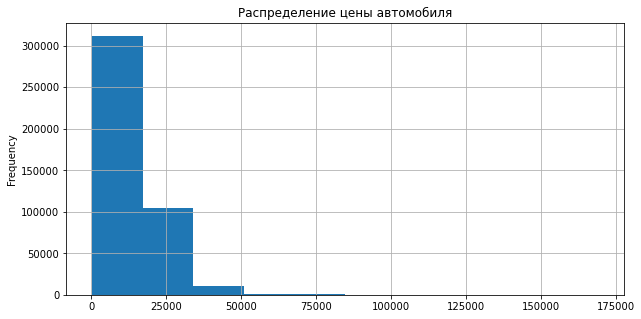

In [173]:
#смотрю значения цены, чтобы разбелить на категории
(
    data_train_new['sellingprice']
    .plot(kind='hist', figsize=(10, 5), 
    grid=True, title='Распределение цены автомобиля')

);

In [224]:
#добавляем метку класса: 0 - авто по цене до 20 000, 1 - все что выше
data_train_new['class'] = data_train_new['sellingprice'].apply(lambda x: 0 if x <= 20000 else 1)

print(data_train_new[['class', 'sellingprice']].head())

   class  sellingprice
0      0         12500
1      0         14500
2      0          9100
3      0         13300
4      0          1300


In [227]:
#обрабатываем данные также, как и предыдущие признаки
data_train_new['saledate'] = data_train_new['saledate'].apply(
    lambda x: x.timestamp()).astype(int) // 10**9

In [229]:
seller_counts = data_train_new['seller'].value_counts()  
frequent_sellers = seller_counts[seller_counts >= 5].index  

filtered_train_indices = data_train_new[data_train_new['seller'].isin(frequent_sellers)].index

data_train_new = data_train_new.loc[filtered_train_indices]

print('Значения из признака "seller", которые встречаются не менее 5 раз, успешно отделены!')

Значения из признака "seller", которые встречаются не менее 5 раз, успешно отделены!


In [230]:
#отделяем признаки
target_train_new = data_train_new['sellingprice']
features_train_new = data_train_new.drop(['sellingprice', 'vin'], axis=1)

print('Поздравляю! Признаки готовы')

Поздравляю! Признаки готовы


In [231]:
#масштабирование признаков
scaler.fit(features_train_new[['odometer']])
features_train_new['odometer'] = scaler.transform(features_train_new[['odometer']])
print('Поздравляю! Признаки приведены к одному масштабу')

Поздравляю! Признаки приведены к одному масштабу


In [232]:
features_train_new, features_valid_new, target_train_new, target_valid_new = train_test_split(
    features_train_new, target_train_new, test_size = 0.25, random_state = 12345)

print('Данные для валидации готовы')

Данные для валидации готовы


In [233]:
encoder.fit(features_train_new[categorical], target_train_new)

features_train_encoded_new = encoder.transform(features_train_new[categorical]).add_suffix('_encoded')

features_train_new = pd.concat([features_train_new[numeric], features_train_encoded_new], axis=1)

print('Тренировочную выборку закодировали!')

Тренировочную выборку закодировали!


In [234]:
#кодируем валидационную выборку
features_valid_encoded_new = encoder.transform(features_valid_new[categorical]).add_suffix('_encoded')

features_valid_new = pd.concat([features_valid_new[numeric], features_valid_encoded_new], axis=1)

print('Валидационную выборку закодировали!')

Валидационную выборку закодировали!


C:\Users\evdov\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


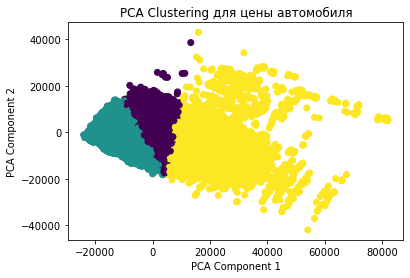

In [240]:
#делим данные на кластеры 
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_train_new)

kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(features_pca)

plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Clustering для цены автомобиля')
plt.show()

In [241]:
#смотрим важность признаков в каждом кластере
cluster_features = pca.inverse_transform(kmeans.cluster_centers_)

feature_names = features_train_new.columns

for i, cluster in enumerate(cluster_features):
    print(f"Кластер {i+1}:")
    cluster_importance = pd.Series(cluster, index=feature_names).sort_values(ascending=False)
    print(cluster_importance)
    print()

Кластер 1:
seller_encoded          14926.008257
state_encoded           13603.389532
interior_encoded        13505.636478
color_encoded           13476.636758
transmission_encoded    13399.132547
trim_encoded            13267.945835
body_encoded            13146.953367
make_encoded            13109.094091
model_encoded           12803.846566
year_sell                2014.919253
year                     2010.546098
condition                   3.498869
saledate                    1.000000
odometer                   -0.145709
dtype: float64

Кластер 2:
transmission_encoded    13339.364126
color_encoded           12911.248512
interior_encoded        12808.147184
state_encoded           12695.156033
body_encoded            12572.237884
make_encoded            11081.349001
trim_encoded             9802.002814
model_encoded            9577.202128
seller_encoded           8218.687121
year_sell                2014.895883
year                     2008.134913
condition                   2.983322


<div class="alert alert-info">
    вопрос про кластеры. Я х разделила, но не могу понять, как посмотреть значения по кластерам, чтобы понять, по какому принципу они разделены - например дороге машины дешевые машины, машины с побегом и т д. Код ниже - это я попыталась посмоотреть, но данные для закодированы уже. 
</div>

In [245]:
unique_clusters = np.unique(clusters)

for cluster in unique_clusters:
    cluster_values = features_train_new[clusters == cluster]
    print(f'Кластер {cluster}: {cluster_values}')


Кластер 0:         year  condition  odometer  saledate  year_sell  model_encoded  \
147872  2012        4.3  0.037134         1       2015   11089.946978   
214703  2011        3.5 -0.286117         1       2015   13278.442880   
111534  2014        4.7 -1.065102         1       2015   13558.084746   
169353  2014        4.4 -0.662407         1       2015   13805.968538   
234732  2009        3.5  0.084893         1       2014   21647.181636   
...      ...        ...       ...       ...        ...            ...   
391188  2012        2.8 -0.624381         1       2015    9355.639098   
435707  2014        4.7 -1.106077         1       2015   14018.674051   
422096  2014        3.9 -0.758272         1       2015   11089.946978   
395406  2007        1.9  2.140960         1       2015   17333.722892   
369296  2011        4.0 -0.832648         1       2015   12402.068146   

        trim_encoded  body_encoded  transmission_encoded  make_encoded  \
147872  13235.332353  11592.245494    

In [244]:
#попробуем CatBoost для кластеров
pipeline = Pipeline([
    ('pca', PCA(n_components=2)),
    ('kmeans', KMeans(n_clusters=3)),
    ('catboost', CatBoostRegressor())
])

pipeline.fit(features_train_new, target_train_new)

predictions_new = pipeline.predict(features_valid_new)

result_new_cat = mean_squared_error(target_valid_new, predictions_new) ** 0.5
print('RMSE модели на валидационной выборке:', result_new_cat)

C:\Users\evdov\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Learning rate set to 0.10139
0:	learn: 8794.8975501	total: 25.4ms	remaining: 25.4s
1:	learn: 8300.7319629	total: 47.1ms	remaining: 23.5s
2:	learn: 7872.5255190	total: 68.8ms	remaining: 22.9s
3:	learn: 7499.8370862	total: 89.6ms	remaining: 22.3s
4:	learn: 7187.3001017	total: 110ms	remaining: 21.9s
5:	learn: 6919.5526531	total: 131ms	remaining: 21.7s
6:	learn: 6693.3076733	total: 154ms	remaining: 21.9s
7:	learn: 6495.9080570	total: 185ms	remaining: 22.9s
8:	learn: 6334.0541424	total: 213ms	remaining: 23.4s
9:	learn: 6193.7783926	total: 236ms	remaining: 23.4s
10:	learn: 6076.2622346	total: 262ms	remaining: 23.6s
11:	learn: 5976.5293995	total: 289ms	remaining: 23.8s
12:	learn: 5893.8986340	total: 314ms	remaining: 23.8s
13:	learn: 5823.9068990	total: 339ms	remaining: 23.9s
14:	learn: 5764.0813764	total: 369ms	remaining: 24.2s
15:	learn: 5713.5200045	total: 396ms	remaining: 24.4s
16:	learn: 5668.4057879	total: 428ms	remaining: 24.7s
17:	learn: 5632.3280377	total: 459ms	remaining: 25s
18:	lea

152:	learn: 5268.2390681	total: 7.12s	remaining: 39.4s
153:	learn: 5267.6145712	total: 7.16s	remaining: 39.3s
154:	learn: 5267.0956489	total: 7.2s	remaining: 39.3s
155:	learn: 5266.5984527	total: 7.25s	remaining: 39.2s
156:	learn: 5266.0313960	total: 7.29s	remaining: 39.1s
157:	learn: 5265.6814495	total: 7.33s	remaining: 39.1s
158:	learn: 5264.7155117	total: 7.37s	remaining: 39s
159:	learn: 5264.2307769	total: 7.41s	remaining: 38.9s
160:	learn: 5263.6961158	total: 7.44s	remaining: 38.8s
161:	learn: 5263.2992090	total: 7.48s	remaining: 38.7s
162:	learn: 5262.3759699	total: 7.52s	remaining: 38.6s
163:	learn: 5261.8558277	total: 7.56s	remaining: 38.5s
164:	learn: 5261.5179854	total: 7.59s	remaining: 38.4s
165:	learn: 5261.2716039	total: 7.63s	remaining: 38.3s
166:	learn: 5260.8561528	total: 7.66s	remaining: 38.2s
167:	learn: 5260.1071809	total: 7.7s	remaining: 38.1s
168:	learn: 5259.4478808	total: 7.73s	remaining: 38s
169:	learn: 5259.0689846	total: 7.76s	remaining: 37.9s
170:	learn: 5258

305:	learn: 5205.6816468	total: 13s	remaining: 29.4s
306:	learn: 5205.5453117	total: 13s	remaining: 29.4s
307:	learn: 5205.3436288	total: 13.1s	remaining: 29.3s
308:	learn: 5205.0608208	total: 13.1s	remaining: 29.3s
309:	learn: 5204.8552794	total: 13.1s	remaining: 29.3s
310:	learn: 5204.7465089	total: 13.2s	remaining: 29.2s
311:	learn: 5204.2852353	total: 13.2s	remaining: 29.2s
312:	learn: 5203.9151337	total: 13.3s	remaining: 29.1s
313:	learn: 5203.6240522	total: 13.3s	remaining: 29s
314:	learn: 5203.4454191	total: 13.3s	remaining: 29s
315:	learn: 5203.3350693	total: 13.4s	remaining: 28.9s
316:	learn: 5202.9974802	total: 13.4s	remaining: 28.8s
317:	learn: 5202.7414539	total: 13.4s	remaining: 28.8s
318:	learn: 5202.2993309	total: 13.5s	remaining: 28.7s
319:	learn: 5202.0095237	total: 13.5s	remaining: 28.7s
320:	learn: 5201.7312708	total: 13.5s	remaining: 28.6s
321:	learn: 5201.4445857	total: 13.6s	remaining: 28.5s
322:	learn: 5201.1938899	total: 13.6s	remaining: 28.5s
323:	learn: 5200.9

460:	learn: 5169.1476153	total: 18.8s	remaining: 22s
461:	learn: 5169.0340642	total: 18.9s	remaining: 22s
462:	learn: 5168.9373604	total: 18.9s	remaining: 21.9s
463:	learn: 5168.7982167	total: 18.9s	remaining: 21.9s
464:	learn: 5168.5462041	total: 19s	remaining: 21.8s
465:	learn: 5168.3473227	total: 19s	remaining: 21.8s
466:	learn: 5168.1559028	total: 19.1s	remaining: 21.8s
467:	learn: 5167.8993355	total: 19.1s	remaining: 21.7s
468:	learn: 5167.6672603	total: 19.1s	remaining: 21.7s
469:	learn: 5167.4862924	total: 19.2s	remaining: 21.6s
470:	learn: 5167.2926395	total: 19.2s	remaining: 21.6s
471:	learn: 5167.1015606	total: 19.2s	remaining: 21.5s
472:	learn: 5166.9234669	total: 19.3s	remaining: 21.5s
473:	learn: 5166.7816982	total: 19.3s	remaining: 21.4s
474:	learn: 5166.6520631	total: 19.3s	remaining: 21.4s
475:	learn: 5166.5067192	total: 19.4s	remaining: 21.3s
476:	learn: 5166.3819623	total: 19.4s	remaining: 21.3s
477:	learn: 5166.2368185	total: 19.4s	remaining: 21.2s
478:	learn: 5166.0

613:	learn: 5143.0675884	total: 24.6s	remaining: 15.5s
614:	learn: 5142.9520567	total: 24.7s	remaining: 15.5s
615:	learn: 5142.7998216	total: 24.7s	remaining: 15.4s
616:	learn: 5142.7327800	total: 24.8s	remaining: 15.4s
617:	learn: 5142.4903048	total: 24.8s	remaining: 15.3s
618:	learn: 5142.3123447	total: 24.9s	remaining: 15.3s
619:	learn: 5142.1225806	total: 24.9s	remaining: 15.3s
620:	learn: 5141.9360914	total: 24.9s	remaining: 15.2s
621:	learn: 5141.6772501	total: 25s	remaining: 15.2s
622:	learn: 5141.4736917	total: 25s	remaining: 15.1s
623:	learn: 5141.3776648	total: 25.1s	remaining: 15.1s
624:	learn: 5141.1452461	total: 25.1s	remaining: 15.1s
625:	learn: 5140.9403677	total: 25.2s	remaining: 15s
626:	learn: 5140.8614031	total: 25.2s	remaining: 15s
627:	learn: 5140.6686094	total: 25.3s	remaining: 15s
628:	learn: 5140.5002223	total: 25.3s	remaining: 14.9s
629:	learn: 5140.4022484	total: 25.4s	remaining: 14.9s
630:	learn: 5140.3008860	total: 25.4s	remaining: 14.9s
631:	learn: 5140.096

768:	learn: 5121.4612455	total: 32.2s	remaining: 9.68s
769:	learn: 5121.3312693	total: 32.3s	remaining: 9.64s
770:	learn: 5121.1626988	total: 32.3s	remaining: 9.6s
771:	learn: 5121.0392393	total: 32.4s	remaining: 9.55s
772:	learn: 5120.9247274	total: 32.4s	remaining: 9.51s
773:	learn: 5120.8113237	total: 32.4s	remaining: 9.47s
774:	learn: 5120.7038449	total: 32.5s	remaining: 9.43s
775:	learn: 5120.6576463	total: 32.5s	remaining: 9.39s
776:	learn: 5120.5042729	total: 32.6s	remaining: 9.35s
777:	learn: 5120.4353085	total: 32.6s	remaining: 9.31s
778:	learn: 5120.2922388	total: 32.7s	remaining: 9.27s
779:	learn: 5120.2318299	total: 32.7s	remaining: 9.23s
780:	learn: 5120.1359994	total: 32.7s	remaining: 9.18s
781:	learn: 5120.0624333	total: 32.8s	remaining: 9.14s
782:	learn: 5119.9346578	total: 32.8s	remaining: 9.1s
783:	learn: 5119.8102901	total: 32.9s	remaining: 9.06s
784:	learn: 5119.6459617	total: 32.9s	remaining: 9.01s
785:	learn: 5119.5943163	total: 33s	remaining: 8.97s
786:	learn: 51

921:	learn: 5104.8987700	total: 38.7s	remaining: 3.28s
922:	learn: 5104.6809803	total: 38.8s	remaining: 3.23s
923:	learn: 5104.6293845	total: 38.8s	remaining: 3.19s
924:	learn: 5104.5087427	total: 38.9s	remaining: 3.15s
925:	learn: 5104.4626114	total: 38.9s	remaining: 3.11s
926:	learn: 5104.2842300	total: 39s	remaining: 3.07s
927:	learn: 5104.2002860	total: 39s	remaining: 3.03s
928:	learn: 5104.1132421	total: 39.1s	remaining: 2.98s
929:	learn: 5104.0103646	total: 39.1s	remaining: 2.94s
930:	learn: 5103.9090577	total: 39.2s	remaining: 2.9s
931:	learn: 5103.8461904	total: 39.2s	remaining: 2.86s
932:	learn: 5103.7921999	total: 39.2s	remaining: 2.82s
933:	learn: 5103.6455137	total: 39.3s	remaining: 2.78s
934:	learn: 5103.4609456	total: 39.3s	remaining: 2.73s
935:	learn: 5103.3657615	total: 39.4s	remaining: 2.69s
936:	learn: 5103.2609107	total: 39.4s	remaining: 2.65s
937:	learn: 5103.1719526	total: 39.5s	remaining: 2.61s
938:	learn: 5103.0957848	total: 39.6s	remaining: 2.57s
939:	learn: 510

### 8. Подготовка выводов по исследованию

Цена авто держится до 80 тыс, основная масса авто - до 20 тыс.

Влияние признаков на цену автомобиля посмотрела разными способами - матрица корреляции, feature_importances_, Recursive Feature Elimination, PCA. Результаты методов немного отличаются, но есть признаки, которые показывают стабильное сильное влияние на цену: год выпуска авто и пробег. 

Если смотреть по анализу кластеров, то есть автомобили, на цену которых влияет продавец, штат, отделка салона, цвет, трансмиссия. Второ кластер - то же самое, но продавец не влияет. Самый многочисленный кластер 3 с важными признаками: модель, отделка салона, продавец, марка. 

Интересно, что анализ по кластерам не видит зависимости между годом выпска авто и ценой. Лучшие результаты по обучению модели показывает CatBoost без подбора параметров и без разбивки на кластеры - cреднее RMSE: 2110. Модель CatBoost с кластерами показывает ошибку в 2 раза больше - 5266. 

<div class="alert alert-info">
   у меня получилось, что чем больше я услоняла модель, тем худший результат она показывала. кажется подозрительно) жду ваше мнение
</div>